# --- Importe ---
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import transform
import pyproj
import folium
from IPython.display import display

# --- 1) Datei laden (Pfad anpassen) ---
# Tipp: verwende raw-String r"" oder Vorwärtsschrägstriche, damit der Umlaut im Pfad kein Problem ist.
pfad = r"D:/Bahelorarbeit/QGIS/Data/Überlagerungslayer.gpkg"  # <- falls anders, anpassen

gdf = gpd.read_file(pfad)

# Optional: Spalten prüfen, falls du dir bei 'AUSSENDURC' unsicher bist
print("Spalten:", list(gdf.columns)[:30])
display(gdf.head())

# --- 2) Statische Übersichtskarte (Matplotlib) ---
# Nutzt das Feld 'AUSSENDURC' für die Farbgebung.
ax = gdf.plot(column="AUSSENDURC", cmap="plasma", legend=True, figsize=(8,6))
ax.set_title("Leitungen nach Außendurchmesser")
plt.show()

# --- 3) Interaktive Karte (Folium) ---
# a) Für Zentroid-Berechnung in metrisches CRS wechseln (z.B. EPSG:25833 für Brandenburg)
gdf_utm = gdf.to_crs(epsg=25833)

# b) Exakten Mittelpunkt berechnen (neu: union_all statt deprecated unary_union)
mitte_utm = gdf_utm.geometry.centroid.union_all().centroid

# c) Mittelpunkt nach WGS84 (EPSG:4326) transformieren
project = pyproj.Transformer.from_crs(25833, 4326, always_xy=True).transform
mitte_wgs84 = transform(project, mitte_utm)
mitte = [mitte_wgs84.y, mitte_wgs84.x]

# d) Geometrien für Webkarte ebenfalls nach WGS84 projizieren
gdf_wgs = gdf.to_crs(epsg=4326)

# e) Folium-Map erzeugen, Layer hinzufügen, im Notebook anzeigen & als HTML speichern
m = folium.Map(location=mitte, zoom_start=15)
folium.GeoJson(gdf_wgs, name="Leitungen").add_to(m)
folium.LayerControl().add_to(m)

# Im Notebook anzeigen:
m  # in Jupyter reicht es, das Objekt als letzte Zeile einer Zelle stehen zu lassen

# Zusätzlich als Datei speichern:
m.save("meine_karte.html")
print("Interaktive Karte gespeichert als: meine_karte.html")


In [1]:
import os
print(os.getcwd())


C:\Users\haziz


In [3]:
import geopandas as gpd

# Pfad zu deinem gespeicherten Layer
pfad = r"D:/Bahelorarbeit/QGIS/Data/Überlagerungslayer.gpkg"

# Layer laden
gdf = gpd.read_file(pfad)

# Optional prüfen
print(gdf.head())
print(gdf.columns)


  LEITUNGSAR MATERIAL  INNENDURCH  INNENBREIT  INNENHOEHE  AUSSENDURC  \
0         DS     PEHD         0.0       160.0       160.0       160.0   
1         DS     PEHD         0.0       160.0       160.0       160.0   
2         KS       UN         0.0         0.0         0.0         0.0   
3         KS      STZ       200.0       200.0       200.0         0.0   
4         KS      STZ       200.0       200.0       200.0         0.0   

   WANDDICKE  ROHRLAENGE  HALTUNGSLA STATUS  ... HOEHENSPEZ HOEHENBEZU  \
0       14.6    0.000000    0.000000  IBETR  ...       SOHL   DHHN2016   
1       14.6    0.000000    0.000000  IBETR  ...       SOHL   DHHN2016   
2        0.0    0.000000    0.000000  IBETR  ...         SI   DHHN2016   
3        0.0   20.419767   21.417802  IBETR  ...       SOHL   DHHN2016   
4        0.0   20.419767   21.417802  IBETR  ...       SOHL   DHHN2016   

                                BEMERKUNG_2                ANLAGENNAM  TYP  \
0                                     

C:\Users\haziz\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(


In [5]:
print(gdf_wgs.columns)


Index(['LEITUNGSAR', 'MATERIAL', 'INNENDURCH', 'INNENBREIT', 'INNENHOEHE',
       'AUSSENDURC', 'WANDDICKE', 'ROHRLAENGE', 'HALTUNGSLA', 'STATUS',
       'GEOGRAPHIS', 'BEMERKUNG', 'LEITUNGSNU', 'NENNWEITE', 'LAENGE_BER',
       'EG_PUMPWER', 'Shape_Leng', 'd_LEITUNGS', 'd_MATERIAL', 'd_STATUS',
       'd_GEOGRAPH', 'ALP_ID', 'OSTWERT', 'NORDWERT', 'GEOGRAPHIS_2',
       'GELAENDEHO', 'HOEHE', 'ABSTICHUEB', 'HOEHENSPEZ', 'HOEHENBEZU',
       'BEMERKUNG_2', 'ANLAGENNAM', 'TYP', 'SCHACHTID', 'd_GEOGRAPH_2',
       'd_HOEHENSP', 'd_TYP', 'geometry'],
      dtype='object')


In [6]:
# 1) Importe
import geopandas as gpd
import folium

# 2) Deinen Layer laden (Pfad ggf. anpassen)
pfad = r"D:/Bahelorarbeit/QGIS/Data/Überlagerungslayer.gpkg"
gdf = gpd.read_file(pfad)

# 3) Länge in Metern berechnen (im metrischen CRS) und als Spalte speichern
gdf_m = gdf.to_crs(epsg=25833)
gdf["LAENGE_M"] = gdf_m.geometry.length.round(2)

# 4) Für Webkarten nach WGS84 (Breite/Länge) umprojizieren
gdf_wgs = gdf.to_crs(epsg=4326)

# 5) Kartenmittelpunkt robust bestimmen (ohne centroid-Warnung)
minx, miny, maxx, maxy = gdf_wgs.total_bounds
mitte = [(miny + maxy)/2, (minx + maxx)/2]

# 6) Interaktive Karte mit Popups bauen
m = folium.Map(location=mitte, zoom_start=15)

tooltip = folium.GeoJsonTooltip(
    fields=["AUSSENDURC", "MATERIAL", "NENNWEITE", "ROHRLAENGE", "HOEHE", "GELAENDEHO", "LAENGE_M"],
    aliases=["Außendurchmesser (mm):", "Material:", "Nennweite:", "Rohrlänge [Attribut] (m):",
             "Höhe (m):", "Geländehöhe (m):", "Länge berechnet (m):"],
    localize=True
)

folium.GeoJson(
    gdf_wgs,
    name="Leitungen",
    tooltip=tooltip,
    highlight_function=lambda f: {"weight": 5}  # hebt Segment beim Hover hervor
).add_to(m)

folium.LayerControl().add_to(m)

# 7) Im Notebook anzeigen und zusätzlich speichern
m
m.save("meine_karte_mit_popups.html")
print("Gespeichert als: meine_karte_mit_popups.html")


C:\Users\haziz\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiLineString' is converted to 'MultiLineString Z'
  return ogr_read(


Gespeichert als: meine_karte_mit_popups.html


Betriebspunkt:
  Förderstrom Q* = 8.40 l/s
  Förderhöhe  H* = 6.47 m


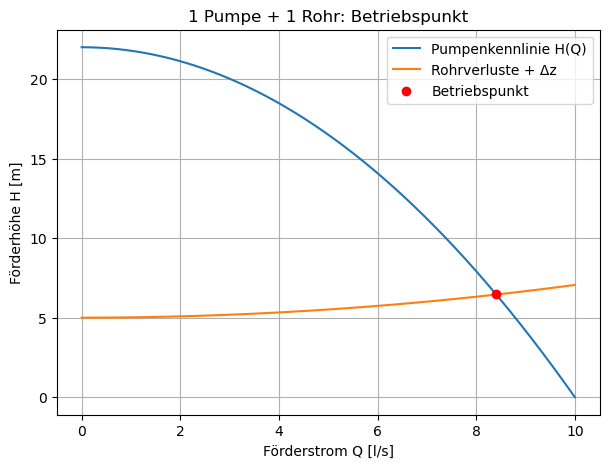

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ===== Eingaben (ANPASSEN an deine Daten) =====
# Rohr:
L_m       = 120.0      # Rohrlänge [m]  -> z.B. aus gdf["LAENGE_M"].iloc[0]
DN_mm     = 100.0      # Außendurchmesser [mm] -> z.B. gdf["AUSSENDURC"].iloc[0]
k_bends   = 3          # Anzahl Krümmer [-] (Annahme oder zählen)
K_each    = 0.3        # Verlustbeiwert je Krümmer [-] (typisch 0.2..0.5)
delta_z   = 5.0        # Höhenunterschied [m] (Förderziel höher als Quelle)

# Reibung:
f = 0.02               # Darcy-Reibungsbeiwert [-] (konservativ; später verfeinern)

# Pumpe (vereinfachte Kennlinie):
H0_m      = 22.0       # Förderhöhe bei Q=0 [m]
Qmax_lps  = 10.0       # Max. Förderstrom [l/s] (bei H≈0)
# ==============================================

# Einheiten/Geometrie
D = DN_mm / 1000.0                 # [m]
A = np.pi * (D**2) / 4.0           # Querschnitt [m²]
g = 9.81                           # [m/s²]
K_sum = k_bends * K_each           # Summe der Einzelverluste

# Kennlinien als Funktionen
def H_rohr(Q_m3s):
    """Rohrverlustkurve inkl. Krümmer + Höhendifferenz, in Metern."""
    v = Q_m3s / A                              # Strömungsgeschwindigkeit [m/s]
    dyn = (v**2) / (2*g)
    h_f = f * (L_m / D) * dyn                  # Rohrreibung
    h_k = K_sum * dyn                          # Einzelverluste (Krümmer etc.)
    return h_f + h_k + delta_z                 # + Höhendifferenz

def H_pumpe(Q_m3s):
    """Parabolische Pumpenkennlinie in Metern."""
    Qmax = Qmax_lps / 1000.0                   # [m³/s]
    # Negative Werte verhindern (numerische Robustheit)
    val = H0_m * (1.0 - (Q_m3s / Qmax)**2)
    return np.maximum(val, 0.0)

# Q-Achse: von 0 bis Qmax, fein auflösen
Q = np.linspace(0.0, Qmax_lps/1000.0, 400)     # [m³/s]
Hp = H_pumpe(Q)
Hr = H_rohr(Q)

# Betriebspunkt: Stelle, wo |Hp - Hr| minimal ist
idx = np.argmin(np.abs(Hp - Hr))
Q_star = Q[idx]                 # [m³/s]
H_star = (Hp[idx] + Hr[idx]) / 2.0

print(f"Betriebspunkt:")
print(f"  Förderstrom Q* = {Q_star*1000:.2f} l/s")
print(f"  Förderhöhe  H* = {H_star:.2f} m")

# Plot
plt.figure(figsize=(7,5))
plt.plot(Q*1000, Hp, label="Pumpenkennlinie H(Q)")
plt.plot(Q*1000, Hr, label="Rohrverluste + Δz")
plt.scatter([Q_star*1000], [H_star], color="red", zorder=5, label="Betriebspunkt")
plt.xlabel("Förderstrom Q [l/s]")
plt.ylabel("Förderhöhe H [m]")
plt.title("1 Pumpe + 1 Rohr: Betriebspunkt")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
# Beispiel: nimm die erste Zeile aus deinem GeoDataFrame
DN_mm    = float(gdf["AUSSENDURC"].iloc[0])  # Außendurchmesser in mm
L_m      = float(gdf["LAENGE_M"].iloc[0])    # zuvor berechnet (metrisches CRS!)
# delta_z musst du selbst festlegen (Höhendifferenz Quelle->Ziel in m)
# k_bends (Krümmer) nach Zählung/Annahme einsetzen


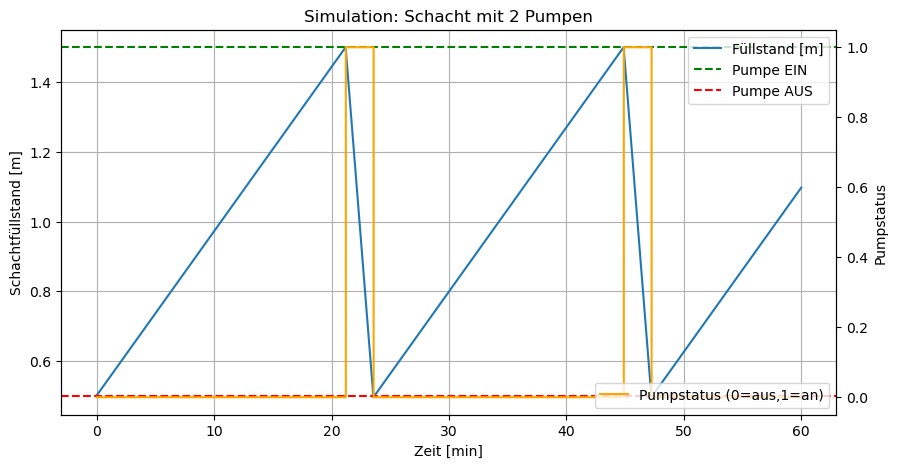

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Schacht-Parameter
# ----------------------------
d = 1.8     # Durchmesser [m]
h = 2.0     # Tiefe [m]
A = np.pi * (d/2)**2  # Querschnittsfläche [m²]

# ----------------------------
# 2. Pumpen-Parameter (vereinfachte Kennlinie)
# ----------------------------
Qmax = 0.01     # [m³/s] = 10 l/s pro Pumpe
Hmax = 20       # Förderhöhe bei Q=0 (nur symbolisch)
n_pumpen = 2    # Anzahl baugleicher Pumpen

# Start-/Stopp-Schwellen
h_on = 1.5   # Pumpe EIN bei Füllstand > 1.5 m
h_off = 0.5  # Pumpe AUS bei Füllstand < 0.5 m

# ----------------------------
# 3. Simulationseinstellungen
# ----------------------------
dt = 1.0      # Zeitschritt [s]
T = 3600      # Gesamtdauer [s] (1 Stunde)
t = np.arange(0, T, dt)

# Zufluss (z.B. Regen) konstant oder zeitabhängig
Q_in = np.zeros_like(t)
Q_in[:] = 0.002   # 2 l/s Zufluss

# ----------------------------
# 4. Simulation
# ----------------------------
h_schacht = 0.5  # Startfüllstand [m]
pumpe_an = False
pump_status = []
levels = []

for i in range(len(t)):
    # Pumpensteuerung
    if h_schacht > h_on:
        pumpe_an = True
    elif h_schacht < h_off:
        pumpe_an = False

    # Pumpenleistung (Abfluss)
    if pumpe_an:
        Q_out = Qmax * n_pumpen
    else:
        Q_out = 0

    # Wasserbilanz im Schacht
    dh = (Q_in[i] - Q_out) / A * dt
    h_schacht += dh

    # Begrenzen auf Schacht-Tiefe
    h_schacht = max(0, min(h, h_schacht))

    # Speichern
    levels.append(h_schacht)
    pump_status.append(int(pumpe_an))

# ----------------------------
# 5. Ergebnisse plotten
# ----------------------------
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(t/60, levels, label="Füllstand [m]")
ax1.axhline(h_on, color="green", linestyle="--", label="Pumpe EIN")
ax1.axhline(h_off, color="red", linestyle="--", label="Pumpe AUS")
ax1.set_xlabel("Zeit [min]")
ax1.set_ylabel("Schachtfüllstand [m]")
ax1.legend(loc="upper right")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.step(t/60, pump_status, color="orange", label="Pumpstatus (0=aus,1=an)", where="post")
ax2.set_ylabel("Pumpstatus")
ax2.legend(loc="lower right")

plt.title("Simulation: Schacht mit 2 Pumpen")
plt.show()


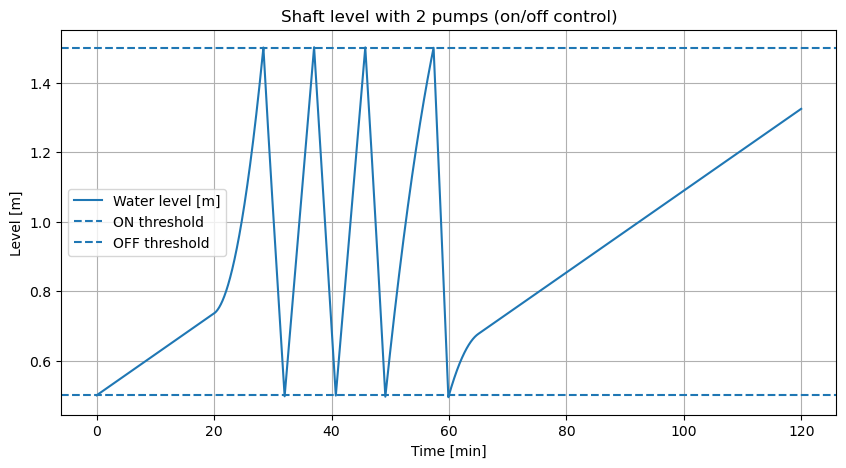

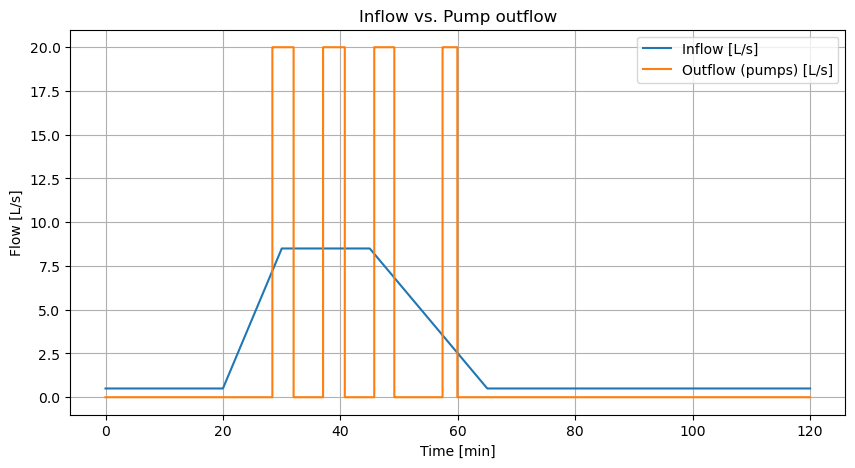

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# 1) PARAMETERS (edit here)
# =============================
# Shaft (cylindrical)
d = 1.8          # diameter [m]
h = 2.0          # depth [m]
A = np.pi * (d/2)**2  # cross-sectional area [m²]

# Pumps (two identical pumps in parallel)
n_pumps = 2
Qmax_pump_lps = 10.0   # max flow PER pump [L/s] (at ~0 head, simplified)
Hmax = 20.0            # not used here yet, kept for future
h_on  = 1.5            # pump ON threshold [m]
h_off = 0.5            # pump OFF threshold [m]

# Simulation time
dt = 1.0               # time step [s]
T_min = 120            # total duration [minutes] -> change as you like
T = int(T_min*60/dt)   # steps

# Inflow scenario (rain pulse on base inflow)
base_inflow_lps   = 0.5      # base inflow [L/s]
storm_start_min   = 20       # when storm starts [min]
storm_peak_lps    = 8.0      # peak inflow during storm [L/s]
storm_rise_min    = 10       # rise time to peak [min]
storm_plateau_min = 15       # peak duration [min]
storm_fall_min    = 20       # fall time back to base [min]
noise_lps         = 0.0      # optional small noise [L/s], e.g. 0.2
# =============================

# -----------------------------
# 2) Build inflow time series
# -----------------------------
t = np.arange(T)*dt
t_min = t/60.0

Q_in_lps = np.full(T, base_inflow_lps, dtype=float)

def add_triangular_pulse(arr, tmin, start_min, rise_min, plateau_min, fall_min, peak_lps):
    """Adds a trapezoid (rise-plateau-fall) pulse on top of the current series."""
    start = start_min
    rise_end = start + rise_min
    plat_end = rise_end + plateau_min
    fall_end = plat_end + fall_min
    for i, tm in enumerate(tmin):
        if start <= tm < rise_end:
            # linear rise from 0 to peak
            frac = (tm - start) / max(rise_min, 1e-9)
            arr[i] += frac * peak_lps
        elif rise_end <= tm < plat_end:
            arr[i] += peak_lps
        elif plat_end <= tm < fall_end:
            # linear fall from peak to 0
            frac = 1.0 - (tm - plat_end) / max(fall_min, 1e-9)
            arr[i] += max(frac, 0.0) * peak_lps

# add one storm pulse
add_triangular_pulse(Q_in_lps, t_min, storm_start_min, storm_rise_min, storm_plateau_min, storm_fall_min, storm_peak_lps)

# optional noise
if noise_lps > 0:
    rng = np.random.default_rng(42)
    Q_in_lps += rng.normal(0, noise_lps, size=T)
    Q_in_lps = np.clip(Q_in_lps, 0, None)

# convert L/s -> m³/s
Q_in = Q_in_lps / 1000.0

# -----------------------------
# 3) Simple pump + tank dynamics
# -----------------------------
h_level = 0.5     # initial level [m]
on = False
levels = np.empty(T)
pump_status = np.empty(T, dtype=int)
Q_out = np.empty(T)

Q_pump_each = Qmax_pump_lps/1000.0  # m³/s per pump

for i in range(T):
    # hysteresis control
    if h_level > h_on:
        on = True
    elif h_level < h_off:
        on = False

    # outflow when pumps on (simplified fixed-Q per pump)
    qout = (Q_pump_each * n_pumps) if on else 0.0

    # water balance
    dh = (Q_in[i] - qout) / A * dt
    h_level += dh
    h_level = max(0.0, min(h, h_level))

    # store
    levels[i] = h_level
    pump_status[i] = 1 if on else 0
    Q_out[i] = qout

# -----------------------------
# 4) Plots
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(t_min, levels, label="Water level [m]")
plt.axhline(h_on, linestyle="--", label="ON threshold")
plt.axhline(h_off, linestyle="--", label="OFF threshold")
plt.xlabel("Time [min]")
plt.ylabel("Level [m]")
plt.title("Shaft level with 2 pumps (on/off control)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(t_min, Q_in_lps, label="Inflow [L/s]")
plt.step(t_min, Q_out*1000.0, where="post", label="Outflow (pumps) [L/s]")
plt.xlabel("Time [min]")
plt.ylabel("Flow [L/s]")
plt.title("Inflow vs. Pump outflow")
plt.legend()
plt.grid(True)
plt.show()


Static operating point with 2 pumps: Q*=15.34 L/s, H*=10.83 m


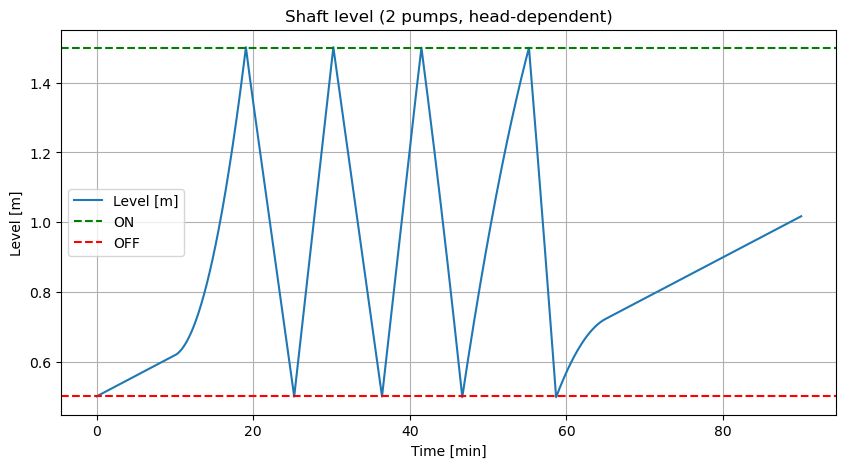

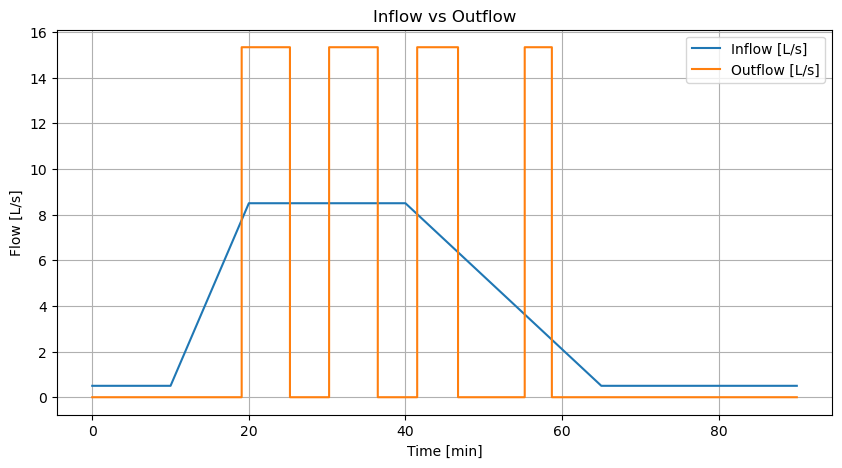

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# 1) Physical constants & helpers
# =============================
g = 9.81       # m/s²
rho = 1000.0   # kg/m³
nu = 1.0e-6    # kinematic viscosity of water ~ 20°C [m²/s]

def swamee_jain_f(Re, rel_rough):
    """Darcy friction factor (Swamee-Jain) for turbulent flow; for laminar fallback use 64/Re."""
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    # Swamee-Jain explicit approximation
    return 0.25 / (np.log10(rel_rough/3.7 + 5.74/(Re**0.9))**2)

# =============================
# 2) Shaft & pipe parameters (EDIT!)
# =============================
# Shaft geometry
d_shaft = 1.8
h_shaft = 2.0
A_shaft = np.pi * (d_shaft/2)**2

# Pipe geometry
L_m    = 120.0     # length [m]
DN_mm  = 100.0     # diameter [mm]  (use inner diameter ideally)
D      = DN_mm/1000.0
A_pipe = np.pi * (D**2) / 4.0

# Elevation and minor losses
delta_z   = 5.0    # static head difference [m]
K_bends   = 3      # number of bends
K_each    = 0.3    # per bend
K_entry   = 0.5    # inlet loss (typical)
K_exit    = 1.0    # outlet loss (typical)
K_sum     = K_bends*K_each + K_entry + K_exit

# Roughness (absolute) for pipe material (adjust if known)
eps_abs = 0.00015  # [m] e.g., 0.15 mm (aged PVC/PE ~0.01–0.1mm; concrete more)

rel_rough = eps_abs / D

# =============================
# 3) Pump curve (EDIT!)
# =============================
# Option A: define points inline (Q in L/s, H in m)
pump_Q_lps = np.array([0, 3, 6, 8, 10, 11])    # example points
pump_H_m   = np.array([22, 20, 15, 10, 5, 0])  # example points

# Create interpolation functions
def H_pump_from_Q(Q_m3s):
    """Head provided by ONE pump at flow Q [m³/s]. Outside range -> clamp."""
    Q_lps = Q_m3s * 1000.0
    Qmin, Qmax = pump_Q_lps[0], pump_Q_lps[-1]
    Q_lps = np.clip(Q_lps, Qmin, Qmax)
    return np.interp(Q_lps, pump_Q_lps, pump_H_m)

n_pumps = 2  # identical pumps in parallel

def H_pumps_parallel(Q_total_m3s):
    """Equivalent head for two identical pumps in parallel at total flow Q_total."""
    # For identical pumps in parallel: head is same as one pump at half the total flow
    return H_pump_from_Q(Q_total_m3s / n_pumps)

# =============================
# 4) Pipe headloss function
# =============================
def H_pipe_required(Q_m3s):
    """Total required head across the line for a given flow Q [m³/s]."""
    if Q_m3s <= 0:
        return delta_z  # need at least static lift
    v = Q_m3s / A_pipe
    Re = v * D / nu
    f = swamee_jain_f(Re, rel_rough)
    h_f = f * (L_m/D) * (v**2)/(2*g)     # friction
    h_k = K_sum * (v**2)/(2*g)           # minor losses
    return delta_z + h_f + h_k

# =============================
# 5) Solver for operating point H_pumps(Q) = H_pipe(Q)
# =============================
def operating_point():
    # bracket search on Q in [0, Q_max_guess]
    Qmax_guess = pump_Q_lps[-1] / 1000.0 * n_pumps  # m³/s (max parallel capacity)
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a) - H_pipe_required(a)
    Hb = H_pumps_parallel(b) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:
        # pumps cannot overcome static + losses -> no flow
        return 0.0, H_pipe_required(0.0)
    # bisection
    for _ in range(60):
        m = 0.5*(a+b)
        Hm = H_pumps_parallel(m) - H_pipe_required(m)
        if Hm == 0:
            a = b = m
            break
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8:
            break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star)
    return Q_star, H_star

# Quick check of static operating point (for info)
Q0, H0 = operating_point()
print(f"Static operating point with 2 pumps: Q*={Q0*1000:.2f} L/s, H*={H0:.2f} m")

# =============================
# 6) Time simulation with variable inflow (reuse or build new)
# =============================
dt = 1.0          # s
T_min = 90        # minutes
T = int(T_min*60/dt)
t = np.arange(T)*dt
t_min = t/60

# Build a storm-like inflow [L/s]
base_in = 0.5
Q_in_lps = np.full(T, base_in)
# one pulse
start, rise, plat, fall = 10, 10, 20, 25  # min
peak = 8.0
def add_pulse(arr, tmin, start, rise, plat, fall, peak):
    a, b, c, d = start, start+rise, start+rise+plat, start+rise+plat+fall
    for i, tm in enumerate(tmin):
        if a <= tm < b:
            arr[i] += peak * (tm - a)/max(rise,1e-9)
        elif b <= tm < c:
            arr[i] += peak
        elif c <= tm < d:
            arr[i] += peak * (1 - (tm - c)/max(fall,1e-9))
add_pulse(Q_in_lps, t_min, start, rise, plat, fall, peak)
Q_in = Q_in_lps/1000.0  # m³/s

# Level simulation with on/off control and head-dependent Q_out
h_level = 0.5
h_on, h_off = 1.5, 0.5

levels = np.empty(T)
pump_on = np.zeros(T, dtype=int)
Q_out = np.zeros(T)

for i in range(T):
    # simple hysteresis on/off based on level
    if h_level > h_on:
        pump_on[i] = 1
    elif h_level < h_off:
        pump_on[i] = 0
    else:
        pump_on[i] = pump_on[i-1] if i>0 else 0

    # if pumps ON -> compute operating-point flow; else 0
    if pump_on[i] == 1:
        q_star, _ = operating_point()
        qout = q_star
    else:
        qout = 0.0

    # mass balance in the shaft
    dh = (Q_in[i] - qout) / A_shaft * dt
    h_level = np.clip(h_level + dh, 0.0, h_shaft)

    # store
    levels[i] = h_level
    Q_out[i] = qout

# =============================
# 7) Plots
# =============================
plt.figure(figsize=(10,5))
plt.plot(t_min, levels, label="Level [m]")
plt.axhline(h_on, ls="--", c="g", label="ON")
plt.axhline(h_off, ls="--", c="r", label="OFF")
plt.xlabel("Time [min]"); plt.ylabel("Level [m]"); plt.title("Shaft level (2 pumps, head-dependent)")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(t_min, Q_in_lps, label="Inflow [L/s]")
plt.step(t_min, Q_out*1000.0, where="post", label="Outflow [L/s]")
plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]"); plt.title("Inflow vs Outflow")
plt.grid(True); plt.legend(); plt.show()


Total energy over 120 min: 0.51 kWh


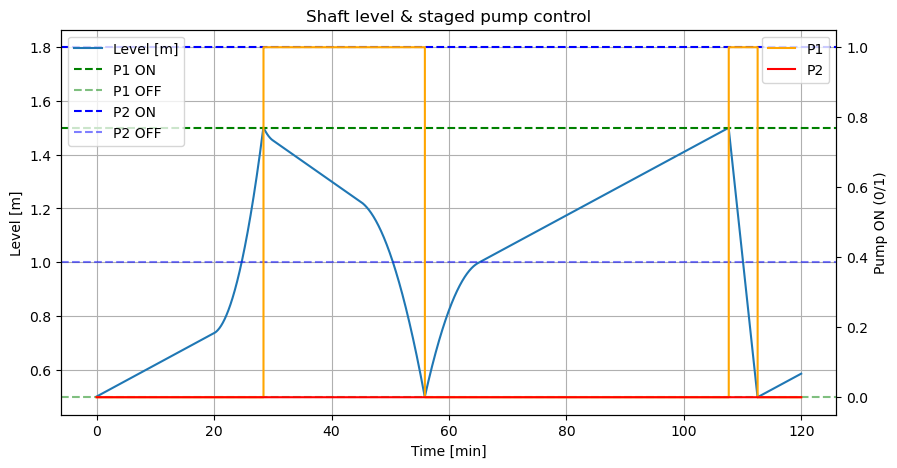

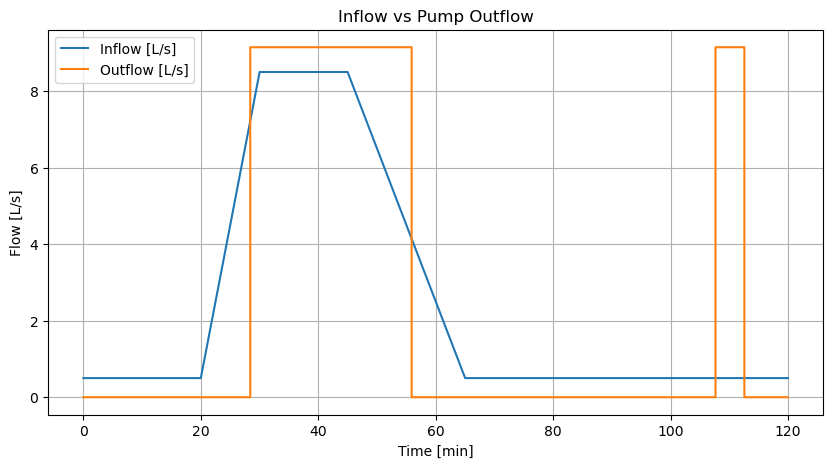

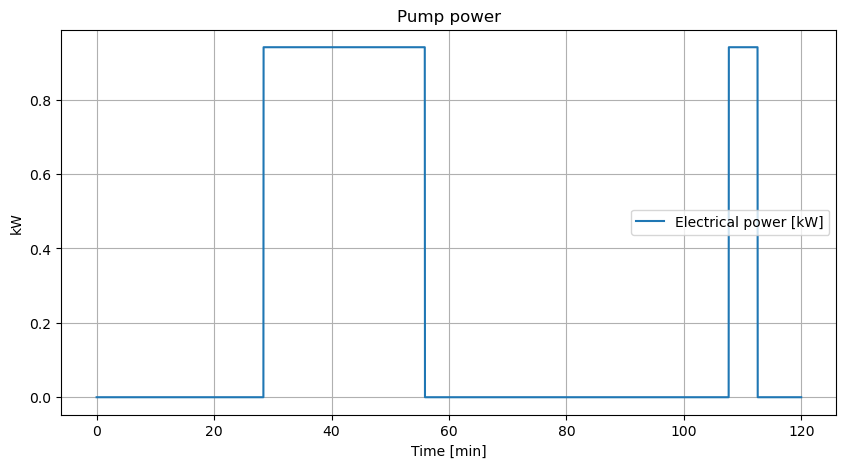

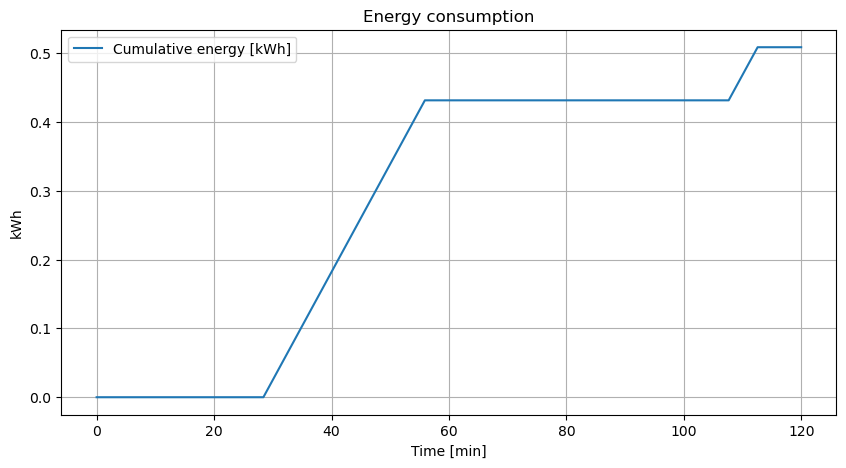

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# 1) CONSTANTS
# =============================
g   = 9.81        # m/s²
rho = 1000.0      # kg/m³
nu  = 1.0e-6      # m²/s (kinematic viscosity water)

# =============================
# 2) SHAFT & PIPE (EDIT if needed)
# =============================
# Shaft
d_shaft = 1.8
h_shaft = 2.0
A_shaft = np.pi*(d_shaft/2)**2

# Pipe
L_m    = 120.0          # [m]
DN_mm  = 100.0          # inner/nominal diameter [mm] (use inner if known)
D      = DN_mm/1000.0   # [m]
A_pipe = np.pi*(D**2)/4
delta_z = 5.0           # static head lift [m]

# Minor losses (typical values; tune if you have better data)
K_bends = 3
K_each  = 0.3
K_entry = 0.5
K_exit  = 1.0
K_sum   = K_bends*K_each + K_entry + K_exit

# Roughness (absolute) — adjust to your material (PVC/PE ~0.01–0.1 mm, concrete larger)
eps_abs   = 0.00015    # m (0.15 mm)
rel_rough = eps_abs/D

def friction_factor(Re, rr):
    """Swamee–Jain (laminar fallback 64/Re)."""
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    """System (pipe) head requirement for flow Q."""
    if Q_m3s <= 0:
        return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f * (L_m/D) * (v**2)/(2*g)     # friction
    h_k = K_sum * (v**2)/(2*g)           # minor losses
    return delta_z + h_f + h_k

# =============================
# 3) PUMPS: HEAD CURVE + EFFICIENCY
# =============================
# One KSB pump curve (Q in L/s, H in m). Replace with real values when you have them.
pump_Q_lps = np.array([0, 3, 6, 8, 10, 11])
pump_H_m   = np.array([22,20,15,10,  5,  0])

# Efficiency curve for the SAME pump (η as 0..1) — edit to your data if available.
# Typically peaks around BEP (best efficiency point).
pump_eta_Q_lps = np.array([0,  3,  6,  8, 10, 11])
pump_eta       = np.array([0.4,0.55,0.70,0.72,0.65,0.40])  # example

def H_pump_one(Q_m3s):
    """Head of ONE pump at flow Q (m³/s)."""
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def eta_pump_one(Q_m3s):
    """Hydraulic efficiency of ONE pump at flow Q (m³/s)."""
    ql = np.clip(Q_m3s*1000.0, pump_eta_Q_lps[0], pump_eta_Q_lps[-1])
    return float(np.interp(ql, pump_eta_Q_lps, pump_eta))

def H_pumps_parallel(Q_total_m3s, n_on):
    """Equivalent head of n_on identical pumps in parallel at total flow Q_total."""
    if n_on <= 0:
        return 0.0
    return H_pump_one(Q_total_m3s / n_on)

# =============================
# 4) OPERATING POINT SOLVER
# =============================
def operating_point(n_on):
    """Solve H_pumps(Q) = H_pipe(Q) for given number of pumps ON."""
    if n_on <= 0:
        return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a, n_on) - H_pipe_required(a)
    Hb = H_pumps_parallel(b, n_on) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:
        return 0.0, H_pipe_required(0.0)   # cannot overcome static/system head
    for _ in range(60):  # bisection
        m  = 0.5*(a+b)
        Hm = H_pumps_parallel(m, n_on) - H_pipe_required(m)
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8:
            break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star, n_on)
    return Q_star, H_star

# =============================
# 5) CONTROL + INFLOW (SCENARIO)
# =============================
dt    = 1.0        # s
T_min = 120        # min
T     = int(T_min*60/dt)
t     = np.arange(T)*dt
tmin  = t/60

# Build storm inflow [L/s]
Q_in_lps = np.full(T, 0.5)   # base inflow
def add_trapezoid(arr, start, rise, plat, fall, peak):
    a, b, c, d = start, start+rise, start+rise+plat, start+rise+plat+fall
    for i, tm in enumerate(tmin):
        if a <= tm < b:
            arr[i] += peak*(tm-a)/max(rise,1e-9)
        elif b <= tm < c:
            arr[i] += peak
        elif c <= tm < d:
            arr[i] += peak*(1 - (tm-c)/max(fall,1e-9))
add_trapezoid(Q_in_lps, start=20, rise=10, plat=15, fall=20, peak=8.0)

Q_in = Q_in_lps/1000.0  # m³/s

# Staged control: P1 first, P2 only at higher level
h_on1, h_off1 = 1.5, 0.5
h_on2, h_off2 = 1.8, 1.0

# =============================
# 6) TIME SIMULATION (energy included)
# =============================
level   = 0.5       # initial level [m]
n_on    = 0         # pumps ON
levels  = np.zeros(T)
Q_out   = np.zeros(T)     # total outflow [m³/s]
H_out   = np.zeros(T)     # pump head [m] at operating point
P_elec  = np.zeros(T)     # electrical power [W]
pump_on1 = np.zeros(T, dtype=int)
pump_on2 = np.zeros(T, dtype=int)

for i in range(T):
    # Decide pump states (hysteresis)
    if level > h_on1:
        pump_on1[i] = 1
    elif level < h_off1:
        pump_on1[i] = 0
    else:
        pump_on1[i] = pump_on1[i-1] if i>0 else 0

    if level > h_on2:
        pump_on2[i] = 1
    elif level < h_off2:
        pump_on2[i] = 0
    else:
        pump_on2[i] = pump_on2[i-1] if i>0 else 0

    n_on = int(pump_on1[i]) + int(pump_on2[i])

    # Outflow via operating point if pumps are ON
    if n_on > 0:
        q_star, h_star = operating_point(n_on)
        # Per-pump flow and efficiency for power calc
        q_per = q_star / n_on
        eta   = max(eta_pump_one(q_per), 0.05)  # avoid divide-by-zero; clamp min η
        P_hyd = rho * g * q_star * h_star       # hydraulic power [W] (total)
        P_el  = P_hyd / eta                     # electrical input [W] (approx)
        Q_out[i] = q_star
        H_out[i] = h_star
        P_elec[i] = P_el
    else:
        Q_out[i] = 0.0
        H_out[i] = 0.0
        P_elec[i] = 0.0

    # Mass balance in shaft
    dh = (Q_in[i] - Q_out[i]) / A_shaft * dt
    level = np.clip(level + dh, 0.0, h_shaft)
    levels[i] = level

# Cumulative energy (kWh)
E_kWh = np.cumsum(P_elec*dt) / 3.6e6

print(f"Total energy over {T_min} min: {E_kWh[-1]:.2f} kWh")

# =============================
# 7) PLOTS
# =============================
# Level + thresholds + pump states
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(tmin, levels, label="Level [m]")
ax1.axhline(h_on1,  ls="--", c="g", label="P1 ON")
ax1.axhline(h_off1, ls="--", c="g", alpha=0.5, label="P1 OFF")
ax1.axhline(h_on2,  ls="--", c="b", label="P2 ON")
ax1.axhline(h_off2, ls="--", c="b", alpha=0.5, label="P2 OFF")
ax1.set_xlabel("Time [min]"); ax1.set_ylabel("Level [m]")
ax1.grid(True); ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.step(tmin, pump_on1, where="post", label="P1", color="orange")
ax2.step(tmin, pump_on2, where="post", label="P2", color="red")
ax2.set_ylabel("Pump ON (0/1)")
ax2.legend(loc="upper right")
plt.title("Shaft level & staged pump control")
plt.show()

# Inflow vs outflow
plt.figure(figsize=(10,5))
plt.plot(tmin, Q_in*1000, label="Inflow [L/s]")
plt.step(tmin, Q_out*1000, where="post", label="Outflow [L/s]")
plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]")
plt.title("Inflow vs Pump Outflow")
plt.grid(True); plt.legend(); plt.show()

# Power and cumulative energy
plt.figure(figsize=(10,5))
plt.plot(tmin, P_elec/1000, label="Electrical power [kW]")
plt.xlabel("Time [min]"); plt.ylabel("kW"); plt.title("Pump power")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(tmin, E_kWh, label="Cumulative energy [kWh]")
plt.xlabel("Time [min]"); plt.ylabel("kWh"); plt.title("Energy consumption")
plt.grid(True); plt.legend(); plt.show()


BEFORE: total energy = 0.75 kWh | peak level = 1.50 m | max outflow = 10.0 L/s
AFTER : total energy = 0.51 kWh | peak level = 1.50 m | max outflow = 9.1 L/s


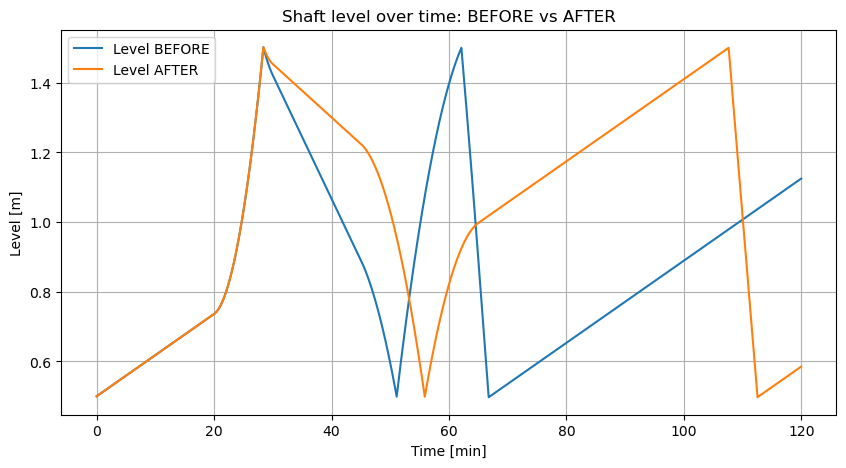

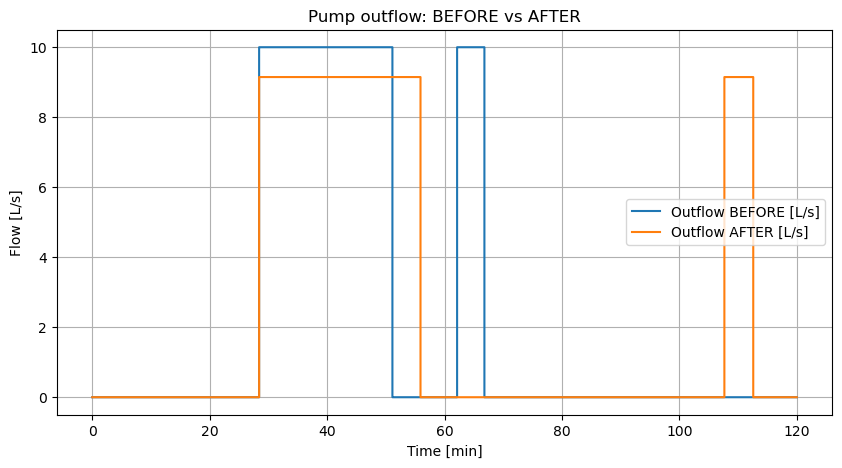

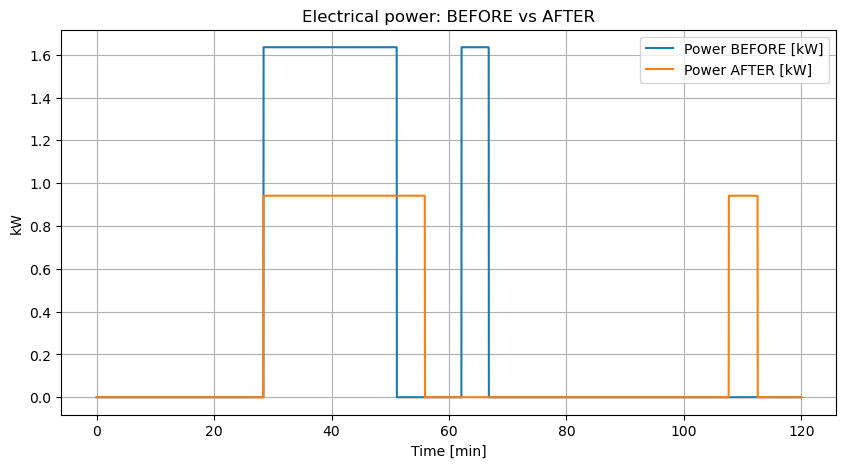

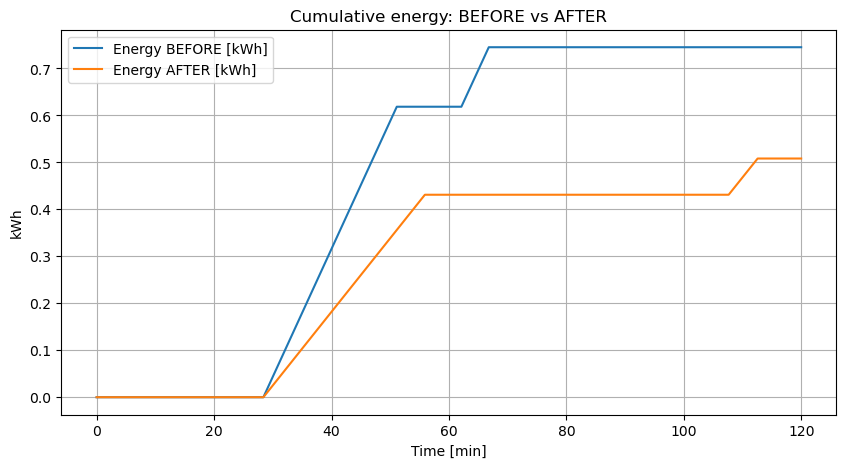

In [13]:
# BEFORE vs AFTER pumping-station simulation with energy
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Shared parameters (edit if needed)
# ------------------------------
g   = 9.81       # m/s²
rho = 1000.0     # kg/m³
nu  = 1.0e-6     # m²/s

# Shaft
d_shaft = 1.8
h_shaft = 2.0
A_shaft = np.pi*(d_shaft/2)**2

# Pipe
L_m    = 120.0          # m
DN_mm  = 100.0          # mm (use inner diameter ideally)
D      = DN_mm/1000.0   # m
A_pipe = np.pi*(D**2)/4
delta_z = 5.0           # m static lift

# Minor losses (typical)
K_bends = 3
K_each  = 0.3
K_entry = 0.5
K_exit  = 1.0
K_sum   = K_bends*K_each + K_entry + K_exit

# Roughness
eps_abs   = 0.00015    # m
rel_rough = eps_abs/D

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    if Q_m3s <= 0:
        return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f * (L_m/D) * (v**2)/(2*g)     # friction
    h_k = K_sum * (v**2)/(2*g)           # minor losses
    return delta_z + h_f + h_k

# Pump curve (example) and efficiency (replace with real KSB data later)
pump_Q_lps = np.array([0, 3, 6, 8, 10, 11])
pump_H_m   = np.array([22,20,15,10,  5,  0])
pump_eta_Q_lps = pump_Q_lps.copy()
pump_eta       = np.array([0.40,0.55,0.70,0.72,0.65,0.40])

def H_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def eta_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_eta_Q_lps[0], pump_eta_Q_lps[-1])
    return float(np.interp(ql, pump_eta_Q_lps, pump_eta))

def H_pumps_parallel(Q_total_m3s, n_on):
    if n_on <= 0:
        return 0.0
    return H_pump_one(Q_total_m3s / n_on)

def operating_point(n_on):
    """Solve H_pumps(Q) = H_pipe(Q) for given number of pumps ON."""
    if n_on <= 0:
        return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a, n_on) - H_pipe_required(a)
    Hb = H_pumps_parallel(b, n_on) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:
        return 0.0, H_pipe_required(0.0)
    for _ in range(60):  # bisection
        m  = 0.5*(a+b)
        Hm = H_pumps_parallel(m, n_on) - H_pipe_required(m)
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8:
            break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star, n_on)
    return Q_star, H_star

# ------------------------------
# Inflow scenario (storm pulse)
# ------------------------------
dt    = 1.0
T_min = 120
T     = int(T_min*60/dt)
t     = np.arange(T)*dt
tmin  = t/60

Q_in_lps = np.full(T, 0.5)  # base inflow [L/s]

def add_trapezoid(arr, start, rise, plat, fall, peak):
    a, b, c, d = start, start+rise, start+rise+plat, start+rise+plat+fall
    for i, tm in enumerate(tmin):
        if a <= tm < b:
            arr[i] += peak*(tm-a)/max(rise,1e-9)
        elif b <= tm < c:
            arr[i] += peak
        elif c <= tm < d:
            arr[i] += peak*(1 - (tm-c)/max(fall,1e-9))

add_trapezoid(Q_in_lps, start=20, rise=10, plat=15, fall=20, peak=8.0)
Q_in = Q_in_lps/1000.0  # m³/s

# Control thresholds
h_on1, h_off1 = 1.5, 0.5
h_on2, h_off2 = 1.8, 1.0

# ------------------------------
# BEFORE: fixed outflow, fixed head & efficiency
# ------------------------------
Q_pump_fixed_lps = 10.0
Q_pump_fixed     = Q_pump_fixed_lps/1000.0  # m³/s per pump
eta_fixed        = 0.60
H_fixed          = delta_z + 5.0            # rough guess

def simulate_before():
    level   = 0.5
    pump1, pump2 = 0, 0
    levels  = np.zeros(T)
    Q_out   = np.zeros(T)
    P_elec  = np.zeros(T)
    for i in range(T):
        # staged control
        if level > h_on1: pump1 = 1
        elif level < h_off1: pump1 = 0
        if level > h_on2: pump2 = 1
        elif level < h_off2: pump2 = 0
        n_on = pump1 + pump2

        qout = n_on * Q_pump_fixed
        Phyd = rho*g*qout*H_fixed
        Pel  = Phyd/max(eta_fixed, 1e-6) if n_on>0 else 0.0

        # mass balance
        dh = (Q_in[i] - qout)/A_shaft * dt
        level = np.clip(level + dh, 0.0, h_shaft)

        levels[i] = level
        Q_out[i]  = qout
        P_elec[i] = Pel
    E_kWh = np.cumsum(P_elec*dt)/3.6e6
    return levels, Q_out, P_elec, E_kWh

# ------------------------------
# AFTER: operating point + efficiency curve
# ------------------------------
def simulate_after():
    level   = 0.5
    pump1, pump2 = 0, 0
    levels  = np.zeros(T)
    Q_out   = np.zeros(T)
    P_elec  = np.zeros(T)
    for i in range(T):
        # staged control
        if level > h_on1: pump1 = 1
        elif level < h_off1: pump1 = 0
        if level > h_on2: pump2 = 1
        elif level < h_off2: pump2 = 0
        n_on = pump1 + pump2

        if n_on > 0:
            q_star, h_star = operating_point(n_on)
            q_per = q_star / n_on
            eta   = max(eta_pump_one(q_per), 0.05)
            Phyd  = rho*g*q_star*h_star
            Pel   = Phyd/eta
            qout  = q_star
        else:
            qout, Pel = 0.0, 0.0

        dh = (Q_in[i] - qout)/A_shaft * dt
        level = np.clip(level + dh, 0.0, h_shaft)

        levels[i] = level
        Q_out[i]  = qout
        P_elec[i] = Pel
    E_kWh = np.cumsum(P_elec*dt)/3.6e6
    return levels, Q_out, P_elec, E_kWh

# Run
levels_b, Qout_b, Pel_b, E_b = simulate_before()
levels_a, Qout_a, Pel_a, E_a = simulate_after()

print(
    f"BEFORE: total energy = {E_b[-1]:.2f} kWh | peak level = {levels_b.max():.2f} m | max outflow = {Qout_b.max()*1000:.1f} L/s\n"
    f"AFTER : total energy = {E_a[-1]:.2f} kWh | peak level = {levels_a.max():.2f} m | max outflow = {Qout_a.max()*1000:.1f} L/s"
)

# ------------------------------
# Charts (4 figures)
# ------------------------------
plt.figure(figsize=(10,5))
plt.plot(tmin, levels_b, label="Level BEFORE")
plt.plot(tmin, levels_a, label="Level AFTER")
plt.xlabel("Time [min]"); plt.ylabel("Level [m]")
plt.title("Shaft level over time: BEFORE vs AFTER")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.step(tmin, Qout_b*1000, where="post", label="Outflow BEFORE [L/s]")
plt.step(tmin, Qout_a*1000, where="post", label="Outflow AFTER [L/s]")
plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]")
plt.title("Pump outflow: BEFORE vs AFTER")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(tmin, Pel_b/1000, label="Power BEFORE [kW]")
plt.plot(tmin, Pel_a/1000, label="Power AFTER [kW]")
plt.xlabel("Time [min]"); plt.ylabel("kW")
plt.title("Electrical power: BEFORE vs AFTER")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(10,5))
plt.plot(tmin, E_b, label="Energy BEFORE [kWh]")
plt.plot(tmin, E_a, label="Energy AFTER [kWh]")
plt.xlabel("Time [min]"); plt.ylabel("kWh")
plt.title("Cumulative energy: BEFORE vs AFTER")
plt.grid(True); plt.legend(); plt.show()

# # Optional: save figures as PNG for your thesis (uncomment to save)
# plt.figure(1); plt.savefig("level_before_after.png", dpi=200, bbox_inches="tight")
# plt.figure(2); plt.savefig("outflow_before_after.png", dpi=200, bbox_inches="tight")
# plt.figure(3); plt.savefig("power_before_after.png", dpi=200, bbox_inches="tight")
# plt.figure(4); plt.savefig("energy_before_after.png", dpi=200, bbox_inches="tight")


In [14]:
# SCENARIO RUNNER: pumping station simulation (saves PNGs & CSVs)
import os, csv, json, numpy as np, matplotlib.pyplot as plt

# ------------------------------
# Physics & fluid properties
# ------------------------------
g   = 9.81        # m/s²
rho = 1000.0      # kg/m³
nu  = 1.0e-6      # m²/s

# ------------------------------
# Geometry & hydraulics (edit if you have better data)
# ------------------------------
# Shaft
d_shaft = 1.8
h_shaft = 2.0
A_shaft = np.pi*(d_shaft/2)**2

# Pipe (use INNER diameter ideally)
L_m    = 120.0
DN_mm  = 100.0
D      = DN_mm/1000.0
A_pipe = np.pi*(D**2)/4
delta_z = 5.0

# Minor losses
K_bends = 3
K_each  = 0.3
K_entry = 0.5
K_exit  = 1.0
K_sum   = K_bends*K_each + K_entry + K_exit

# Roughness (adjust for material)
eps_abs   = 0.00015   # m (0.15 mm)
rel_rough = eps_abs/D

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    if Q_m3s <= 0:
        return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f * (L_m/D) * (v**2)/(2*g)
    h_k = K_sum * (v**2)/(2*g)
    return delta_z + h_f + h_k

# ------------------------------
# Pump curve & efficiency (replace with real KSB data when available)
# ------------------------------
pump_Q_lps = np.array([0, 3, 6, 8, 10, 11])     # Q (L/s) for ONE pump
pump_H_m   = np.array([22,20,15,10,  5,  0])    # H (m)
pump_eta   = np.array([0.40,0.55,0.70,0.72,0.65,0.40])  # η (0..1)
pump_eta_Q_lps = pump_Q_lps.copy()

def H_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def eta_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_eta_Q_lps[0], pump_eta_Q_lps[-1])
    return float(np.interp(ql, pump_eta_Q_lps, pump_eta))

def H_pumps_parallel(Q_total_m3s, n_on):
    if n_on <= 0:
        return 0.0
    return H_pump_one(Q_total_m3s / n_on)

def operating_point(n_on):
    """Solve H_pumps(Q) = H_pipe(Q) via bisection."""
    if n_on <= 0:
        return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a, n_on) - H_pipe_required(a)
    Hb = H_pumps_parallel(b, n_on) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:
        return 0.0, H_pipe_required(0.0)
    for _ in range(60):
        m  = 0.5*(a+b)
        Hm = H_pumps_parallel(m, n_on) - H_pipe_required(m)
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8:
            break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star, n_on)
    return Q_star, H_star

# ------------------------------
# Scenario builder
# ------------------------------
def build_inflow(T, dt, base_lps=0.5, pulses=None, add_const_lps=0.0):
    """Return Q_in [m³/s] and Q_in_lps [L/s] time series."""
    t  = np.arange(T)*dt
    tm = t/60.0
    Q_in_lps = np.full(T, base_lps + add_const_lps, dtype=float)

    def add_trapezoid(arr, start, rise, plat, fall, peak):
        a, b, c, d = start, start+rise, start+rise+plat, start+rise+plat+fall
        for i, m in enumerate(tm):
            if a <= m < b:   arr[i] += peak*(m-a)/max(rise,1e-9)
            elif b <= m < c: arr[i] += peak
            elif c <= m < d: arr[i] += peak*(1 - (m-c)/max(fall,1e-9))

    pulses = pulses or []
    for p in pulses:
        add_trapezoid(Q_in_lps, **p)

    return Q_in_lps/1000.0, Q_in_lps, tm

def simulate_scenario(name, cfg, outdir="results"):
    """
    cfg keys:
      dt, T_min
      staged_control: True/False
      thresholds: dict(h_on1,h_off1,h_on2,h_off2)  # used if staged_control
      both_on_thresholds: dict(h_on,h_off)         # used if not staged_control
      n_pumps_max: 1 or 2
      inflow: dict(base_lps, pulses=[{start, rise, plat, fall, peak}], add_const_lps)
    """
    os.makedirs(os.path.join(outdir, name), exist_ok=True)

    dt    = cfg.get("dt", 1.0)
    T_min = cfg.get("T_min", 120)
    T     = int(T_min*60/dt)

    Q_in, Q_in_lps, tmin = build_inflow(T, dt, **cfg["inflow"])

    staged = cfg.get("staged_control", True)
    th1 = cfg.get("thresholds", {"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0})
    thB = cfg.get("both_on_thresholds", {"h_on":1.6,"h_off":0.6})
    n_pumps_max = cfg.get("n_pumps_max", 2)

    level = 0.5
    pump1 = pump2 = 0
    levels  = np.zeros(T)
    Q_out   = np.zeros(T)
    H_out   = np.zeros(T)
    P_elec  = np.zeros(T)
    p1_on   = np.zeros(T, dtype=int)
    p2_on   = np.zeros(T, dtype=int)

    for i in range(T):
        # Control
        if staged:
            # staged two-pump hysteresis
            if level > th1["h_on1"]:  pump1 = 1
            elif level < th1["h_off1"]: pump1 = 0

            if level > th1["h_on2"] and n_pumps_max>=2:  pump2 = 1
            elif level < th1["h_off2"]: pump2 = 0
        else:
            # both pumps act as a block
            if level > thB["h_on"]:
                pump1 = 1
                pump2 = 1 if n_pumps_max>=2 else 0
            elif level < thB["h_off"]:
                pump1 = 0
                pump2 = 0

        n_on = pump1 + pump2
        p1_on[i], p2_on[i] = pump1, pump2

        if n_on > 0:
            q_star, h_star = operating_point(n_on)
            q_per = q_star / n_on
            eta   = max(eta_pump_one(q_per), 0.05)
            Phyd  = rho*g*q_star*h_star
            Pel   = Phyd/eta
            qout  = q_star
        else:
            qout, h_star, Pel = 0.0, 0.0, 0.0

        # Water balance
        dh    = (Q_in[i] - qout)/A_shaft * dt
        level = np.clip(level + dh, 0.0, h_shaft)

        # Store
        levels[i] = level
        Q_out[i]  = qout
        H_out[i]  = h_star
        P_elec[i] = Pel

    E_kWh = np.cumsum(P_elec*dt)/3.6e6

    # -------- Save CSV
    folder = os.path.join(outdir, name)
    csv_path = os.path.join(folder, "timeseries.csv")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["time_min","level_m","Q_in_lps","Q_out_lps","pump1_on","pump2_on","head_m","power_kW","energy_kWh"])
        for i in range(T):
            w.writerow([
                tmin[i], levels[i], Q_in_lps[i], Q_out[i]*1000.0,
                p1_on[i], p2_on[i], H_out[i], P_elec[i]/1000.0, E_kWh[i]
            ])

    # -------- Save CONFIG as JSON
    with open(os.path.join(folder,"config.json"), "w", encoding="utf-8") as jf:
        json.dump(cfg, jf, indent=2)

    # -------- Plots (saved as PNGs)
    plt.figure(figsize=(10,5))
    plt.plot(tmin, levels, label="Level [m]")
    if staged:
        plt.axhline(th1["h_on1"],  ls="--", label="P1 ON")
        plt.axhline(th1["h_off1"], ls="--", label="P1 OFF")
        if n_pumps_max>=2:
            plt.axhline(th1["h_on2"],  ls="--", label="P2 ON")
            plt.axhline(th1["h_off2"], ls="--", label="P2 OFF")
    else:
        plt.axhline(thB["h_on"],  ls="--", label="Both ON")
        plt.axhline(thB["h_off"], ls="--", label="Both OFF")
    plt.xlabel("Time [min]"); plt.ylabel("Level [m]"); plt.title(f"Level – {name}")
    plt.grid(True); plt.legend(); 
    plt.savefig(os.path.join(folder,"level.png"), dpi=200, bbox_inches="tight"); plt.close()

    plt.figure(figsize=(10,5))
    plt.plot(tmin, Q_in_lps, label="Inflow [L/s]")
    plt.step(tmin, Q_out*1000.0, where="post", label="Outflow [L/s]")
    plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]"); plt.title(f"Flows – {name}")
    plt.grid(True); plt.legend(); 
    plt.savefig(os.path.join(folder,"flows.png"), dpi=200, bbox_inches="tight"); plt.close()

    plt.figure(figsize=(10,5))
    plt.plot(tmin, P_elec/1000.0, label="Power [kW]")
    plt.xlabel("Time [min]"); plt.ylabel("kW"); plt.title(f"Power – {name}")
    plt.grid(True); plt.legend(); 
    plt.savefig(os.path.join(folder,"power.png"), dpi=200, bbox_inches="tight"); plt.close()

    plt.figure(figsize=(10,5))
    plt.plot(tmin, E_kWh, label="Energy [kWh]")
    plt.xlabel("Time [min]"); plt.ylabel("kWh"); plt.title(f"Energy – {name}")
    plt.grid(True); plt.legend(); 
    plt.savefig(os.path.join(folder,"energy.png"), dpi=200, bbox_inches="tight"); plt.close()

    # Summary metrics
    summary = dict(
        scenario=name,
        total_energy_kWh=float(E_kWh[-1]),
        peak_level_m=float(levels.max()),
        max_outflow_Lps=float((Q_out*1000.0).max()),
        pumps_runtime_min=float(np.sum((p1_on+p2_on)>0)* (dt/60.0))
    )
    return summary

# ------------------------------
# Define scenarios
# ------------------------------
scenarios = {
    # Baseline staged control
    "baseline": {
        "dt":1.0, "T_min":120,
        "staged_control": True,
        "thresholds": {"h_on1":1.5, "h_off1":0.5, "h_on2":1.8, "h_off2":1.0},
        "n_pumps_max": 2,
        "inflow": {
            "base_lps": 0.5,
            "add_const_lps": 0.0,
            "pulses":[{"start":20,"rise":10,"plat":15,"fall":20,"peak":8.0}]
        }
    },
    # Heavy rain: stronger, longer pulse
    "heavy_rain": {
        "dt":1.0, "T_min":160,
        "staged_control": True,
        "thresholds": {"h_on1":1.5, "h_off1":0.5, "h_on2":1.8, "h_off2":1.0},
        "n_pumps_max": 2,
        "inflow": {
            "base_lps": 0.5,
            "add_const_lps": 0.0,
            "pulses":[{"start":15,"rise":15,"plat":30,"fall":30,"peak":12.0}]
        }
    },
    # Pump failure: only one pump available
    "pump_failure": {
        "dt":1.0, "T_min":120,
        "staged_control": True,
        "thresholds": {"h_on1":1.5, "h_off1":0.5, "h_on2":1.8, "h_off2":1.0},
        "n_pumps_max": 1,  # one pump out
        "inflow": {
            "base_lps": 0.5,
            "add_const_lps": 0.0,
            "pulses":[{"start":20,"rise":10,"plat":15,"fall":20,"peak":8.0}]
        }
    },
    # Fremdwasser: higher base inflow
    "fremdwasser": {
        "dt":1.0, "T_min":120,
        "staged_control": True,
        "thresholds": {"h_on1":1.5, "h_off1":0.5, "h_on2":1.8, "h_off2":1.0},
        "n_pumps_max": 2,
        "inflow": {
            "base_lps": 0.5,
            "add_const_lps": 1.0,  # +1 L/s groundwater intrusion
            "pulses":[{"start":25,"rise":10,"plat":10,"fall":15,"peak":6.0}]
        }
    },
    # Energy strategy: both pumps together vs staged (block control)
    "both_pumps_block_control": {
        "dt":1.0, "T_min":120,
        "staged_control": False,  # not staged: both act together
        "both_on_thresholds": {"h_on":1.6, "h_off":0.6},
        "n_pumps_max": 2,
        "inflow": {
            "base_lps": 0.5,
            "add_const_lps": 0.0,
            "pulses":[{"start":20,"rise":10,"plat":15,"fall":20,"peak":8.0}]
        }
    }
}

# ------------------------------
# Run all scenarios and write a summary CSV
# ------------------------------
os.makedirs("results", exist_ok=True)
summary_rows = []
for name, cfg in scenarios.items():
    s = simulate_scenario(name, cfg, outdir="results")
    summary_rows.append(s)
    print(f"{name:>26} | peak level={s['peak_level_m']:.2f} m | max Q_out={s['max_outflow_Lps']:.1f} L/s | energy={s['total_energy_kWh']:.2f} kWh")

# Save summary table
with open("results/summary.csv","w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["scenario","peak_level_m","max_outflow_Lps","total_energy_kWh","pumps_runtime_min"])
    w.writeheader()
    for r in summary_rows:
        w.writerow(r)

print("\nAll done. Files saved under ./results/<scenario_name>/ (PNGs + timeseries.csv) and ./results/summary.csv")


                  baseline | peak level=1.50 m | max Q_out=9.1 L/s | energy=0.51 kWh
                heavy_rain | peak level=1.80 m | max Q_out=15.3 L/s | energy=1.45 kWh
              pump_failure | peak level=1.50 m | max Q_out=9.1 L/s | energy=0.51 kWh
               fremdwasser | peak level=1.50 m | max Q_out=9.1 L/s | energy=0.49 kWh
  both_pumps_block_control | peak level=1.60 m | max Q_out=15.3 L/s | energy=0.73 kWh

All done. Files saved under ./results/<scenario_name>/ (PNGs + timeseries.csv) and ./results/summary.csv


In [15]:
# LOAD REAL PUMP CURVE FROM CSV, VALIDATE, AND APPLY
import numpy as np, csv, matplotlib.pyplot as plt, os

# --------------- CONFIG ---------------
csv_path = "pump_curve.csv"   # put the file next to your notebook
save_dir = "results/pump_curve_check"
os.makedirs(save_dir, exist_ok=True)

# If these exist from your previous cells, we'll reuse them; otherwise set typical defaults:
try:
    D
except NameError:
    # Pipe default (inner diameter!), length, losses, etc. (edit to your system)
    D = 0.100  # m
    L_m = 120.0
    delta_z = 5.0
    K_bends, K_each, K_entry, K_exit = 3, 0.3, 0.5, 1.0
    K_sum = K_bends*K_each + K_entry + K_exit
    g, rho, nu = 9.81, 1000.0, 1.0e-6
    A_pipe = np.pi*(D**2)/4
    eps_abs = 0.00015
    rel_rough = eps_abs/D

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    if Q_m3s <= 0:
        return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f * (L_m/D) * (v**2)/(2*g)
    h_k = K_sum * (v**2)/(2*g)
    return delta_z + h_f + h_k

# --------------- READ CSV ---------------
Q_lps, H_m, eta = [], [], []
with open(csv_path, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    for row in r:
        Q_lps.append(float(row["Q_lps"]))
        H_m.append(float(row["H_m"]))
        eta.append(float(row["eta"]))
pump_Q_lps = np.array(Q_lps)
pump_H_m   = np.array(H_m)
pump_eta   = np.array(eta)
pump_eta_Q_lps = pump_Q_lps.copy()

# Basic checks
assert np.all(np.diff(pump_Q_lps) >= 0), "Q_lps must be sorted ascending."
assert pump_Q_lps.ndim==pump_H_m.ndim==pump_eta.ndim==1, "Columns must be 1D."
assert len(pump_Q_lps)==len(pump_H_m)==len(pump_eta), "All columns must have same length."

# --------------- INTERPOLATORS ---------------
def H_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def eta_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_eta_Q_lps[0], pump_eta_Q_lps[-1])
    return float(np.interp(ql, pump_eta_Q_lps, pump_eta))

def H_pumps_parallel(Q_total_m3s, n_on):
    if n_on <= 0: return 0.0
    return H_pump_one(Q_total_m3s / n_on)

def operating_point(n_on):
    if n_on <= 0: return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a, n_on) - H_pipe_required(a)
    Hb = H_pumps_parallel(b, n_on) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:  # pumps can’t overcome system head
        return 0.0, H_pipe_required(0.0)
    for _ in range(60):
        m  = 0.5*(a+b)
        Hm = H_pumps_parallel(m, n_on) - H_pipe_required(m)
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8: break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star, n_on)
    return Q_star, H_star

# --------------- PLOTS: PUMP CURVES ---------------
plt.figure(figsize=(8,5))
plt.plot(pump_Q_lps, pump_H_m, marker="o", label="Pump H–Q (one pump)")
plt.xlabel("Flow Q [L/s]"); plt.ylabel("Head H [m]")
plt.title("Pump curve (from CSV)"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(save_dir,"pump_curve.png"), dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(pump_eta_Q_lps, pump_eta, marker="o", label="Pump efficiency η")
plt.xlabel("Flow Q [L/s]"); plt.ylabel("Efficiency η [-]")
plt.title("Pump efficiency curve (from CSV)"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(save_dir,"pump_efficiency.png"), dpi=200, bbox_inches="tight")
plt.show()

# --------------- STATIC OPERATING POINT (1 and 2 pumps) ---------------
Q_axis = np.linspace(0, pump_Q_lps[-1]*2, 400)  # up to 2x single-pump max
Q_axis_m3s = Q_axis/1000.0

H_sys = np.array([H_pipe_required(q) for q in Q_axis_m3s])
H_1p  = np.array([H_pumps_parallel(q, 1) for q in Q_axis_m3s])
H_2p  = np.array([H_pumps_parallel(q, 2) for q in Q_axis_m3s])

Q1, H1 = operating_point(1)
Q2, H2 = operating_point(2)

plt.figure(figsize=(8,5))
plt.plot(Q_axis, H_sys, label="System curve (pipe)")
plt.plot(Q_axis, H_1p,  label="Pump curve (1 pump)")
plt.plot(Q_axis, H_2p,  label="Pump curve (2 pumps)")
plt.scatter([Q1*1000],[H1], label=f"Operating point (1p): {Q1*1000:.1f} L/s, {H1:.1f} m", zorder=5)
plt.scatter([Q2*1000],[H2], label=f"Operating point (2p): {Q2*1000:.1f} L/s, {H2:.1f} m", zorder=5)
plt.xlabel("Flow Q_total [L/s]"); plt.ylabel("Head H [m]")
plt.title("Operating points with real pump curve")
plt.grid(True); plt.legend()
plt.savefig(os.path.join(save_dir,"operating_points.png"), dpi=200, bbox_inches="tight")
plt.show()

print("Real pump curve loaded and applied. Plots saved under:", save_dir)

FileNotFoundError: [Errno 2] No such file or directory: 'pump_curve.csv'

In [16]:
import csv

# Example pump curve (replace later with real KSB values!)
rows = [
    ["Q_lps","H_m","eta"],
    [0,   22, 0.40],
    [3,   20, 0.55],
    [6,   15, 0.70],
    [8,   10, 0.72],
    [10,   5, 0.65],
    [11,   0, 0.40],
]

with open("pump_curve.csv","w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(rows)

print("✅ pump_curve.csv created in your notebook folder")


✅ pump_curve.csv created in your notebook folder


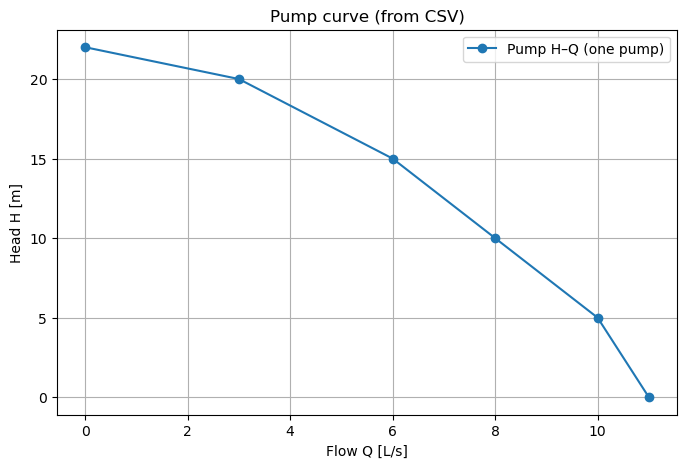

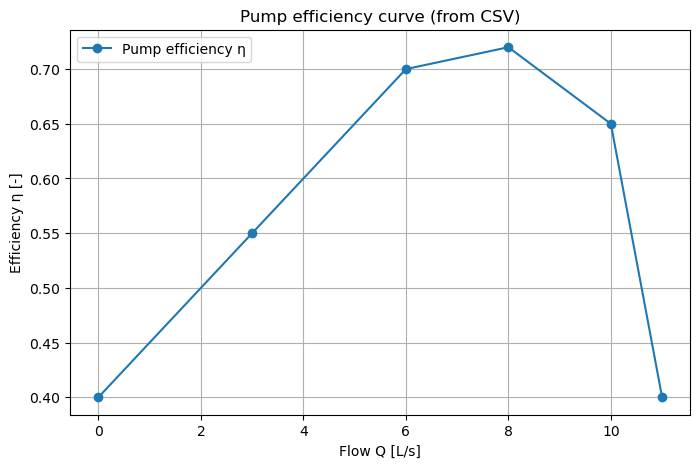

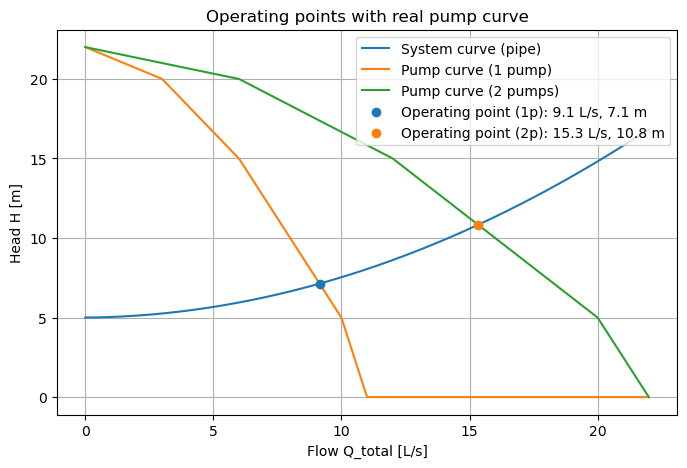

Real pump curve loaded and applied. Plots saved under: results/pump_curve_check


In [17]:
# LOAD REAL PUMP CURVE FROM CSV, VALIDATE, AND APPLY
import numpy as np, csv, matplotlib.pyplot as plt, os

# --------------- CONFIG ---------------
csv_path = "pump_curve.csv"   # put the file next to your notebook
save_dir = "results/pump_curve_check"
os.makedirs(save_dir, exist_ok=True)

# If these exist from your previous cells, we'll reuse them; otherwise set typical defaults:
try:
    D
except NameError:
    # Pipe default (inner diameter!), length, losses, etc. (edit to your system)
    D = 0.100  # m
    L_m = 120.0
    delta_z = 5.0
    K_bends, K_each, K_entry, K_exit = 3, 0.3, 0.5, 1.0
    K_sum = K_bends*K_each + K_entry + K_exit
    g, rho, nu = 9.81, 1000.0, 1.0e-6
    A_pipe = np.pi*(D**2)/4
    eps_abs = 0.00015
    rel_rough = eps_abs/D

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    if Q_m3s <= 0:
        return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f * (L_m/D) * (v**2)/(2*g)
    h_k = K_sum * (v**2)/(2*g)
    return delta_z + h_f + h_k

# --------------- READ CSV ---------------
Q_lps, H_m, eta = [], [], []
with open(csv_path, "r", encoding="utf-8") as f:
    r = csv.DictReader(f)
    for row in r:
        Q_lps.append(float(row["Q_lps"]))
        H_m.append(float(row["H_m"]))
        eta.append(float(row["eta"]))
pump_Q_lps = np.array(Q_lps)
pump_H_m   = np.array(H_m)
pump_eta   = np.array(eta)
pump_eta_Q_lps = pump_Q_lps.copy()

# Basic checks
assert np.all(np.diff(pump_Q_lps) >= 0), "Q_lps must be sorted ascending."
assert pump_Q_lps.ndim==pump_H_m.ndim==pump_eta.ndim==1, "Columns must be 1D."
assert len(pump_Q_lps)==len(pump_H_m)==len(pump_eta), "All columns must have same length."

# --------------- INTERPOLATORS ---------------
def H_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def eta_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_eta_Q_lps[0], pump_eta_Q_lps[-1])
    return float(np.interp(ql, pump_eta_Q_lps, pump_eta))

def H_pumps_parallel(Q_total_m3s, n_on):
    if n_on <= 0: return 0.0
    return H_pump_one(Q_total_m3s / n_on)

def operating_point(n_on):
    if n_on <= 0: return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a, n_on) - H_pipe_required(a)
    Hb = H_pumps_parallel(b, n_on) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:  # pumps can’t overcome system head
        return 0.0, H_pipe_required(0.0)
    for _ in range(60):
        m  = 0.5*(a+b)
        Hm = H_pumps_parallel(m, n_on) - H_pipe_required(m)
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8: break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star, n_on)
    return Q_star, H_star

# --------------- PLOTS: PUMP CURVES ---------------
plt.figure(figsize=(8,5))
plt.plot(pump_Q_lps, pump_H_m, marker="o", label="Pump H–Q (one pump)")
plt.xlabel("Flow Q [L/s]"); plt.ylabel("Head H [m]")
plt.title("Pump curve (from CSV)"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(save_dir,"pump_curve.png"), dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(pump_eta_Q_lps, pump_eta, marker="o", label="Pump efficiency η")
plt.xlabel("Flow Q [L/s]"); plt.ylabel("Efficiency η [-]")
plt.title("Pump efficiency curve (from CSV)"); plt.grid(True); plt.legend()
plt.savefig(os.path.join(save_dir,"pump_efficiency.png"), dpi=200, bbox_inches="tight")
plt.show()

# --------------- STATIC OPERATING POINT (1 and 2 pumps) ---------------
Q_axis = np.linspace(0, pump_Q_lps[-1]*2, 400)  # up to 2x single-pump max
Q_axis_m3s = Q_axis/1000.0

H_sys = np.array([H_pipe_required(q) for q in Q_axis_m3s])
H_1p  = np.array([H_pumps_parallel(q, 1) for q in Q_axis_m3s])
H_2p  = np.array([H_pumps_parallel(q, 2) for q in Q_axis_m3s])

Q1, H1 = operating_point(1)
Q2, H2 = operating_point(2)

plt.figure(figsize=(8,5))
plt.plot(Q_axis, H_sys, label="System curve (pipe)")
plt.plot(Q_axis, H_1p,  label="Pump curve (1 pump)")
plt.plot(Q_axis, H_2p,  label="Pump curve (2 pumps)")
plt.scatter([Q1*1000],[H1], label=f"Operating point (1p): {Q1*1000:.1f} L/s, {H1:.1f} m", zorder=5)
plt.scatter([Q2*1000],[H2], label=f"Operating point (2p): {Q2*1000:.1f} L/s, {H2:.1f} m", zorder=5)
plt.xlabel("Flow Q_total [L/s]"); plt.ylabel("Head H [m]")
plt.title("Operating points with real pump curve")
plt.grid(True); plt.legend()
plt.savefig(os.path.join(save_dir,"operating_points.png"), dpi=200, bbox_inches="tight")
plt.show()

print("Real pump curve loaded and applied. Plots saved under:", save_dir)


In [ ]:
# CONTROL OPTIMIZATION: sweep ON/OFF thresholds to minimize energy without overflow
import os, csv, numpy as np, matplotlib.pyplot as plt

# ---- assumptions: these exist from your notebook ----
# A_shaft, h_shaft, operating_point(n_on), H_pipe_required, rho, g
# If not, define them above as in your previous cells.

# Baseline inflow (reuse your earlier storm). Adjust if you like.
def build_inflow_series(T_min=120, dt=1.0, base_lps=0.5, pulse=(20,10,15,20,8.0)):
    T = int(T_min*60/dt)
    t = np.arange(T)*dt
    tm = t/60.0
    Q_in_lps = np.full(T, base_lps, dtype=float)
    start, rise, plat, fall, peak = pulse
    a, b, c, d = start, start+rise, start+rise+plat, start+rise+plat+fall
    for i, m in enumerate(tm):
        if a <= m < b:   Q_in_lps[i] += peak*(m-a)/max(rise,1e-9)
        elif b <= m < c: Q_in_lps[i] += peak
        elif c <= m < d: Q_in_lps[i] += peak*(1 - (m-c)/max(fall,1e-9))
    return t, tm, Q_in_lps/1000.0, Q_in_lps

# Simulation with staged thresholds
def simulate_with_thresholds(h_on1, h_off1, h_on2, h_off2, T_min=120, dt=1.0):
    t, tm, Q_in, Q_in_lps = build_inflow_series(T_min=T_min, dt=dt)
    T = len(t)
    level = 0.5
    p1 = p2 = 0
    Q_out = np.zeros(T)
    P_el  = np.zeros(T)
    levels= np.zeros(T)

    for i in range(T):
        # hysteresis
        if level > h_on1: p1 = 1
        elif level < h_off1: p1 = 0
        if level > h_on2: p2 = 1
        elif level < h_off2: p2 = 0

        n_on = p1 + p2
        if n_on > 0:
            q_star, h_star = operating_point(n_on)
            # efficiency & power (reuse your eta_pump_one if defined; else simple η=0.65)
            try:
                q_per = q_star / n_on
                eta = max(eta_pump_one(q_per), 0.05)
            except NameError:
                eta = 0.65
            P_el[i] = (rho * g * q_star * h_star) / eta
            Q_out[i] = q_star
        else:
            P_el[i] = 0.0
            Q_out[i] = 0.0

        # water balance
        level = np.clip(level + (Q_in[i] - Q_out[i]) / A_shaft * dt, 0.0, h_shaft)
        levels[i] = level

        # early stop if overflow hits ceiling
        if level >= h_shaft - 1e-6:
            # punish overflow hard
            E_kWh = np.cumsum(P_el*dt)/3.6e6
            return dict(overflow=True, peak=float(levels.max()), energy=float(E_kWh[-1]), levels=levels, tm=tm)

    E_kWh = np.cumsum(P_el*dt)/3.6e6
    return dict(overflow=False, peak=float(levels.max()), energy=float(E_kWh[-1]), levels=levels, tm=tm)

# Sweep ranges (meters). Keep logical order: h_on2 > h_on1 > h_off2 > h_off1
h_off1_vals = np.arange(0.3, 0.7, 0.1)   # e.g., 0.3, 0.4, 0.5, 0.6
h_off2_vals = np.arange(0.7, 1.1, 0.1)   # e.g., 0.7..1.0
h_on1_vals  = np.arange(1.3, 1.8, 0.1)   # e.g., 1.3..1.7
h_on2_vals  = np.arange(1.6, 2.0, 0.1)   # e.g., 1.6..1.9

results = []
tested = 0
for h_off1 in h_off1_vals:
    for h_off2 in h_off2_vals:
        if h_off2 <= h_off1: 
            continue
        for h_on1 in h_on1_vals:
            if h_on1 <= h_off2:
                continue
            for h_on2 in h_on2_vals:
                if h_on2 <= h_on1:
                    continue
                tested += 1
                sim = simulate_with_thresholds(h_on1, h_off1, h_on2, h_off2, T_min=120, dt=1.0)
                if not sim["overflow"]:
                    results.append(dict(
                        h_on1=round(h_on1,2), h_off1=round(h_off1,2),
                        h_on2=round(h_on2,2), h_off2=round(h_off2,2),
                        energy_kWh=sim["energy"], peak_m=sim["peak"]
                    ))

print(f"Tested combos: {tested}, feasible (no overflow): {len(results)}")

# Sort by energy then peak
results_sorted = sorted(results, key=lambda r: (r["energy_kWh"], r["peak_m"]))

# Save top-20 to CSV
os.makedirs("results/optimize", exist_ok=True)
with open("results/optimize/best_thresholds.csv","w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["h_on1","h_off1","h_on2","h_off2","energy_kWh","peak_m"])
    w.writeheader()
    for r in results_sorted[:20]:
        w.writerow(r)

print("Top-5 configs:")
for r in results_sorted[:5]:
    print(r)

# Scatter plot: Energy vs Peak level
E = [r["energy_kWh"] for r in results_sorted]
P = [r["peak_m"]      for r in results_sorted]

plt.figure(figsize=(8,5))
plt.scatter(P, E)
plt.xlabel("Peak level [m]")
plt.ylabel("Total energy [kWh]")
plt.title("Feasible control settings: Energy vs Peak Level")
plt.grid(True)
plt.savefig("results/optimize/energy_vs_peak.png", dpi=200, bbox_inches="tight")
plt.show()


In [2]:
# ---- Minimal pump curve + operating point function ----
g   = 9.81
rho = 1000.0
nu  = 1.0e-6

# Example pump curve (replace with your CSV loader if you have it)
pump_Q_lps = np.array([0, 3, 6, 8, 10, 11])
pump_H_m   = np.array([22,20,15,10,  5,  0])

D = 0.1       # m, pipe inner diameter
L_m = 120.0   # m, pipe length
delta_z = 5.0 # m static lift
A_pipe = np.pi*(D**2)/4
eps_abs = 0.00015
rel_rough = eps_abs/D
K_sum = 3*0.3 + 0.5 + 1.0

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    if Q_m3s <= 0: return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f*(L_m/D)*(v**2)/(2*g)
    h_k = K_sum*(v**2)/(2*g)
    return delta_z + h_f + h_k

def H_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def H_pumps_parallel(Q_total_m3s, n_on):
    if n_on <= 0: return 0.0
    return H_pump_one(Q_total_m3s/n_on)

def operating_point(n_on):
    """Find intersection of pump curve(s) with system curve."""
    if n_on <= 0: return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a,n_on)-H_pipe_required(a)
    Hb = H_pumps_parallel(b,n_on)-H_pipe_required(b)
    if Ha<0 and Hb<0: return 0.0, H_pipe_required(0.0)
    for _ in range(60):
        m = 0.5*(a+b)
        Hm = H_pumps_parallel(m,n_on)-H_pipe_required(m)
        if np.sign(Hm)==np.sign(Ha): a,Ha = m,Hm
        else: b,Hb = m,Hm
        if b-a<1e-8: break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star,n_on)
    return Q_star,H_star


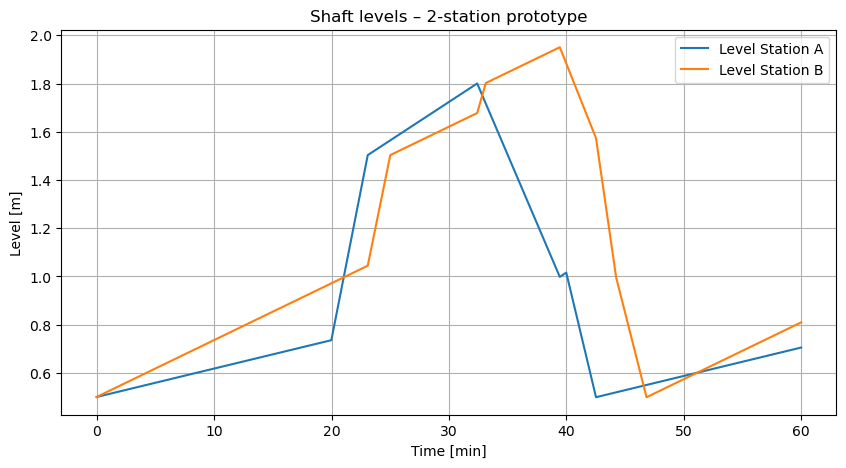

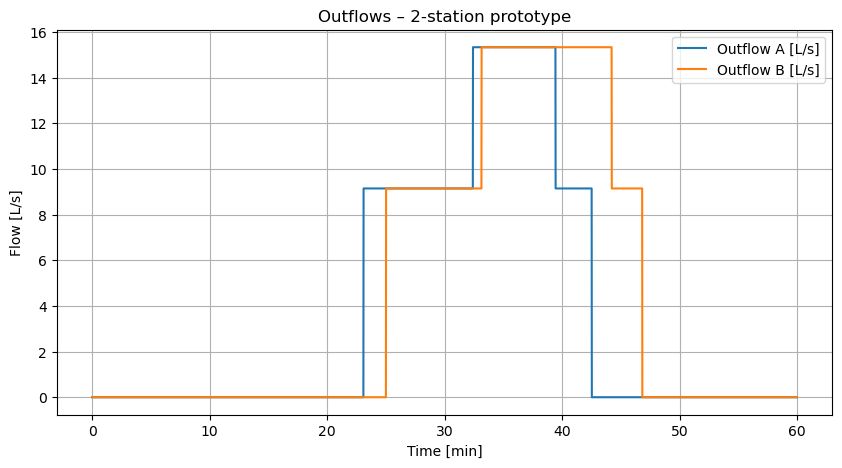

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Basic PumpStation class
# ------------------------
class PumpStation:
    def __init__(self, name, A_shaft, h_shaft, thresholds, inflow_func, pumps=2):
        self.name = name
        self.A_shaft = A_shaft
        self.h_shaft = h_shaft
        self.th = thresholds
        self.inflow_func = inflow_func
        self.n_pumps_max = pumps
        
        # State variables
        self.level = 0.5
        self.pump1 = 0
        self.pump2 = 0
        
        # Time series
        self.levels = []
        self.inflows = []
        self.outflows = []
        
    def step(self, t, dt, inflow_external):
        """Advance one timestep with given external inflow [m³/s]."""
        inflow_total = self.inflow_func(t) + inflow_external
        self.inflows.append(inflow_total)
        
        # Hysteresis control
        if self.level > self.th["h_on1"]:
            self.pump1 = 1
        elif self.level < self.th["h_off1"]:
            self.pump1 = 0
        if self.n_pumps_max >= 2:
            if self.level > self.th["h_on2"]:
                self.pump2 = 1
            elif self.level < self.th["h_off2"]:
                self.pump2 = 0
        
        n_on = self.pump1 + self.pump2
        if n_on > 0:
            # Simplified outflow: use your operating_point(n_on) function
            q_star, h_star = operating_point(n_on)
            qout = q_star
        else:
            qout = 0.0
        
        # Water balance
        dh = (inflow_total - qout)/self.A_shaft * dt
        self.level = np.clip(self.level + dh, 0.0, self.h_shaft)
        
        # Save time series
        self.levels.append(self.level)
        self.outflows.append(qout)
        
        return qout  # pass to downstream
    
    def results(self):
        return dict(name=self.name,
                    levels=np.array(self.levels),
                    inflows=np.array(self.inflows),
                    outflows=np.array(self.outflows))

# ------------------------
# Example setup for 2 stations
# ------------------------
# Shaft geometry
d_shaft = 1.8
h_shaft = 2.0
A_shaft = np.pi*(d_shaft/2)**2

# Thresholds (reuse from before)
thresholds = {"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0}

# Inflow functions
def inflow_A(t):
    """Rain pulse inflow for Station A [m³/s]."""
    # Base inflow = 0.5 L/s
    q = 0.0005
    # Storm event between 20–40 min
    if 20*60 <= t < 40*60:
        q += 0.01  # +10 L/s
    return q

def inflow_B(t):
    """Base Fremdwasser for Station B [m³/s]."""
    return 0.001  # = 1 L/s

# Create stations
stationA = PumpStation("Station A", A_shaft, h_shaft, thresholds, inflow_A, pumps=2)
stationB = PumpStation("Station B", A_shaft, h_shaft, thresholds, inflow_B, pumps=2)

# ------------------------
# Simulation loop
# ------------------------
dt = 1.0
T_min = 60
T = int(T_min*60/dt)
t = np.arange(T)*dt
tmin = t/60.0

for ti in t:
    outA = stationA.step(ti, dt, inflow_external=0.0)  # no upstream
    _    = stationB.step(ti, dt, inflow_external=outA) # A feeds into B

resA = stationA.results()
resB = stationB.results()

# ------------------------
# Plot results
# ------------------------
plt.figure(figsize=(10,5))
plt.plot(tmin, resA["levels"], label="Level Station A")
plt.plot(tmin, resB["levels"], label="Level Station B")
plt.xlabel("Time [min]"); plt.ylabel("Level [m]")
plt.title("Shaft levels – 2-station prototype")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(tmin, resA["outflows"]*1000, label="Outflow A [L/s]")
plt.plot(tmin, resB["outflows"]*1000, label="Outflow B [L/s]")
plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]")
plt.title("Outflows – 2-station prototype")
plt.legend(); plt.grid(True)
plt.show()


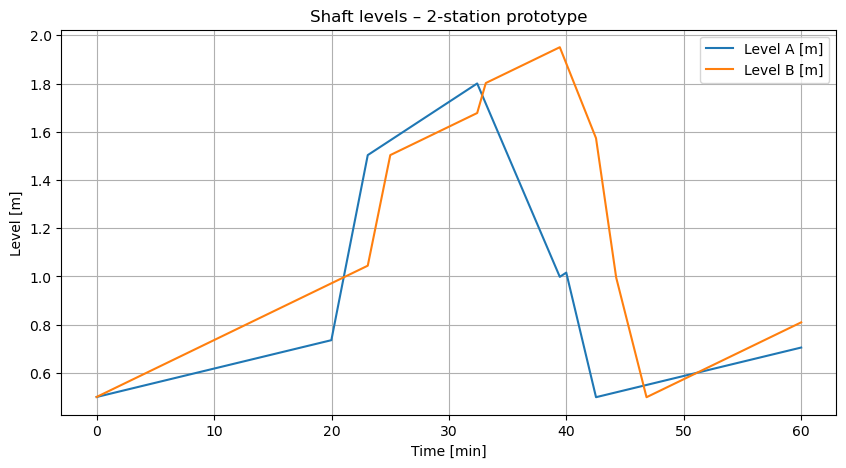

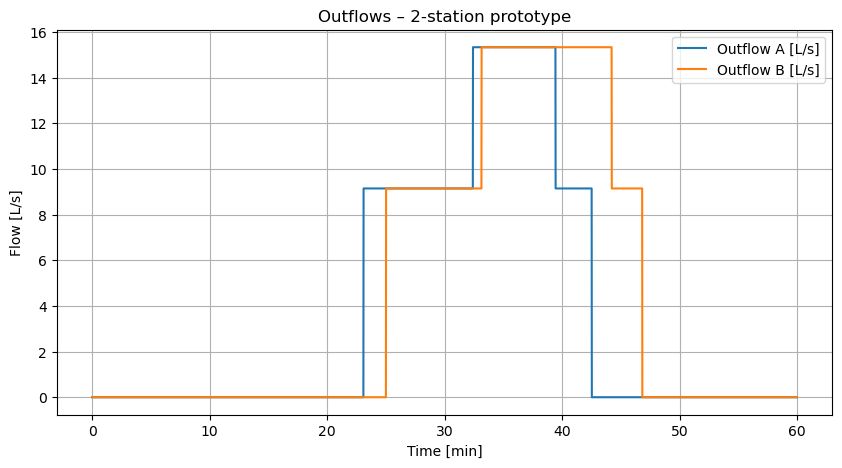

Saved to: results/2station


In [11]:
# 2-STATION NETWORK (A -> B): simulate, plot, and SAVE PNG + CSV
import os, csv, numpy as np, matplotlib.pyplot as plt

# ------------------------
# Minimal hydraulics + operating point (self-contained)
# ------------------------
g   = 9.81
rho = 1000.0
nu  = 1.0e-6

# Example pump curve for ONE pump (replace later with your CSV loader)
pump_Q_lps = np.array([0, 3, 6, 8, 10, 11])
pump_H_m   = np.array([22,20,15,10,  5,  0])

# Pipe/system parameters (shared for simplicity; you can make per-station later)
D = 0.10       # m (inner diameter)
L_m = 120.0    # m
delta_z = 5.0  # m static lift
A_pipe = np.pi*(D**2)/4
eps_abs = 0.00015
rel_rough = eps_abs/D
K_sum = 3*0.3 + 0.5 + 1.0  # bends + entry + exit

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def H_pipe_required(Q_m3s):
    if Q_m3s <= 0: return delta_z
    v  = Q_m3s / A_pipe
    Re = v*D/nu
    f  = friction_factor(Re, rel_rough)
    h_f = f*(L_m/D)*(v**2)/(2*g)
    h_k = K_sum*(v**2)/(2*g)
    return delta_z + h_f + h_k

def H_pump_one(Q_m3s):
    ql = np.clip(Q_m3s*1000.0, pump_Q_lps[0], pump_Q_lps[-1])
    return float(np.interp(ql, pump_Q_lps, pump_H_m))

def H_pumps_parallel(Q_total_m3s, n_on):
    if n_on <= 0: return 0.0
    return H_pump_one(Q_total_m3s/n_on)

def operating_point(n_on):
    """Find Q where pump head (n_on pumps) = system head."""
    if n_on <= 0: return 0.0, H_pipe_required(0.0)
    Qmax_guess = (pump_Q_lps[-1]/1000.0) * n_on
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a,n_on)-H_pipe_required(a)
    Hb = H_pumps_parallel(b,n_on)-H_pipe_required(b)
    if Ha<0 and Hb<0: return 0.0, H_pipe_required(0.0)
    for _ in range(60):
        m = 0.5*(a+b)
        Hm = H_pumps_parallel(m,n_on)-H_pipe_required(m)
        if np.sign(Hm)==np.sign(Ha): a,Ha = m,Hm
        else: b,Hb = m,Hm
        if b-a<1e-8: break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star,n_on)
    return Q_star,H_star

# ------------------------
# PumpStation class (saves series internally)
# ------------------------
class PumpStation:
    def __init__(self, name, d_shaft=1.8, h_shaft=2.0, thresholds=None, pumps=2, level0=0.5, base_inflow_func=None):
        self.name = name
        self.h_shaft = h_shaft
        self.A_shaft = np.pi*(d_shaft/2)**2
        self.th = thresholds or {"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0}
        self.n_pumps_max = pumps
        self.level = level0
        self.base_inflow_func = base_inflow_func or (lambda t: 0.0)
        self.p1 = 0
        self.p2 = 0
        # logs
        self.t_min = []
        self.levels = []
        self.inflows = []
        self.outflows = []

    def step(self, t, dt, inflow_external):
        # total inflow = external (upstream) + local/base (rain, Fremdwasser)
        inflow = inflow_external + self.base_inflow_func(t)

        # hysteresis control
        if self.level > self.th["h_on1"]: self.p1 = 1
        elif self.level < self.th["h_off1"]: self.p1 = 0
        if self.n_pumps_max>=2:
            if self.level > self.th["h_on2"]: self.p2 = 1
            elif self.level < self.th["h_off2"]: self.p2 = 0

        n_on = self.p1 + self.p2
        if n_on>0:
            q_star, _ = operating_point(n_on)
            qout = q_star
        else:
            qout = 0.0

        # water balance
        dh = (inflow - qout)/self.A_shaft * dt
        self.level = np.clip(self.level + dh, 0.0, self.h_shaft)

        # log
        self.t_min.append(t/60.0)
        self.levels.append(self.level)
        self.inflows.append(inflow)
        self.outflows.append(qout)

        return qout

    def to_csv(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f)
            w.writerow(["time_min","level_m","inflow_Lps","outflow_Lps"])
            for tm, h, qi, qo in zip(self.t_min, self.levels, self.inflows, self.outflows):
                w.writerow([tm, h, qi*1000.0, qo*1000.0])

# ------------------------
# Build 2 stations (A -> B)
# ------------------------
thresholds = {"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0}

def inflow_A(t):
    # base 0.5 L/s + storm 10 L/s from 20–40 min
    q = 0.0005
    if 20*60 <= t < 40*60:
        q += 0.010
    return q

def inflow_B(t):
    # constant Fremdwasser 1 L/s
    return 0.001

A = PumpStation("Station_A", thresholds=thresholds, base_inflow_func=inflow_A)
B = PumpStation("Station_B", thresholds=thresholds, base_inflow_func=inflow_B)

# ------------------------
# Simulate
# ------------------------
dt = 1.0
T_min = 60
T = int(T_min*60/dt)
t = np.arange(T)*dt
for ti in t:
    outA = A.step(ti, dt, inflow_external=0.0)
    _    = B.step(ti, dt, inflow_external=outA)

# ------------------------
# SAVE results
# ------------------------
outdir = "results/2station"
os.makedirs(outdir, exist_ok=True)

# CSVs
A.to_csv(os.path.join(outdir, "station_A_timeseries.csv"))
B.to_csv(os.path.join(outdir, "station_B_timeseries.csv"))

# Plots
tmin = np.array(A.t_min)
plt.figure(figsize=(10,5))
plt.plot(tmin, A.levels, label="Level A [m]")
plt.plot(tmin, B.levels, label="Level B [m]")
plt.xlabel("Time [min]"); plt.ylabel("Level [m]")
plt.title("Shaft levels – 2-station prototype")
plt.grid(True); plt.legend()
plt.savefig(os.path.join(outdir, "levels.png"), dpi=200, bbox_inches="tight")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(tmin, np.array(A.outflows)*1000.0, label="Outflow A [L/s]")
plt.plot(tmin, np.array(B.outflows)*1000.0, label="Outflow B [L/s]")
plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]")
plt.title("Outflows – 2-station prototype")
plt.grid(True); plt.legend()
plt.savefig(os.path.join(outdir, "flows.png"), dpi=200, bbox_inches="tight")
plt.show()

print("Saved to:", outdir)


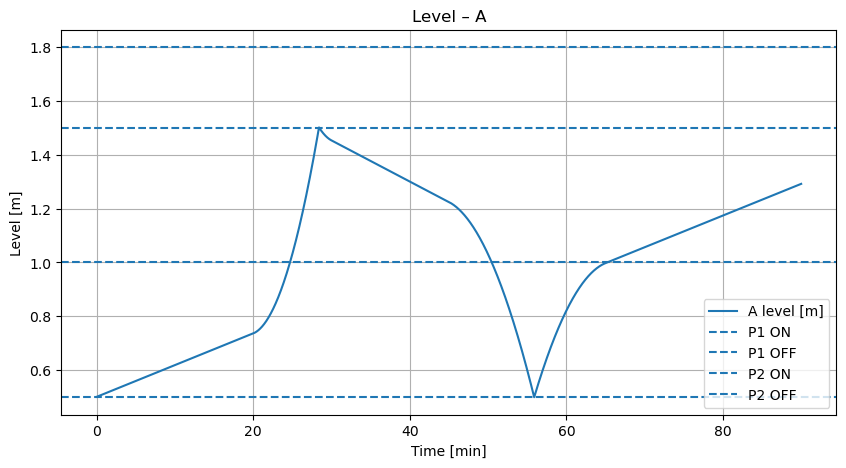

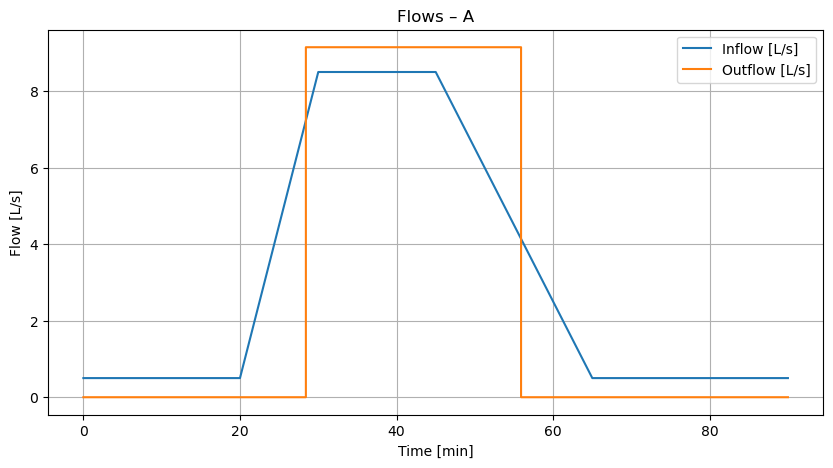

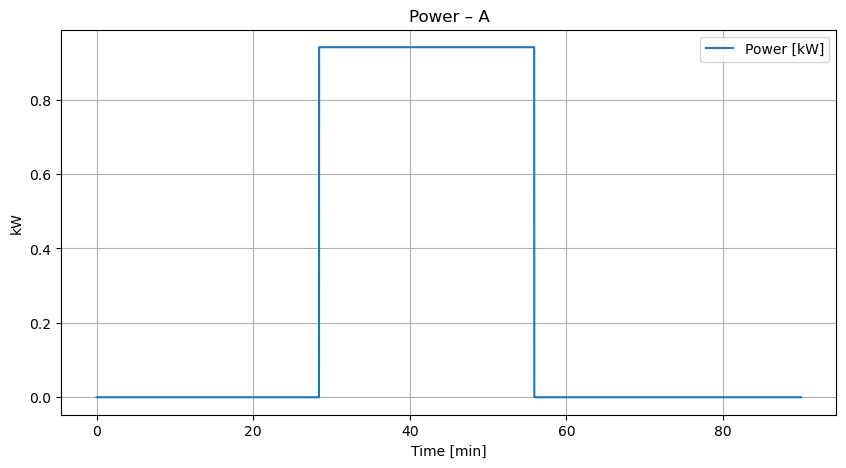

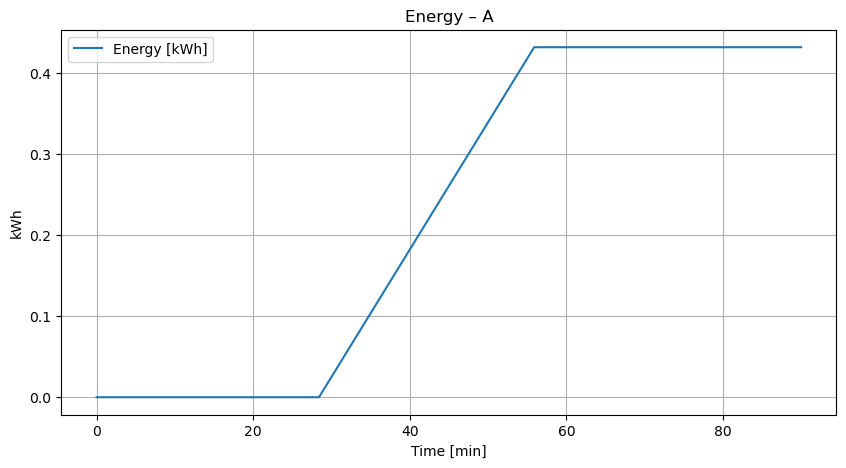

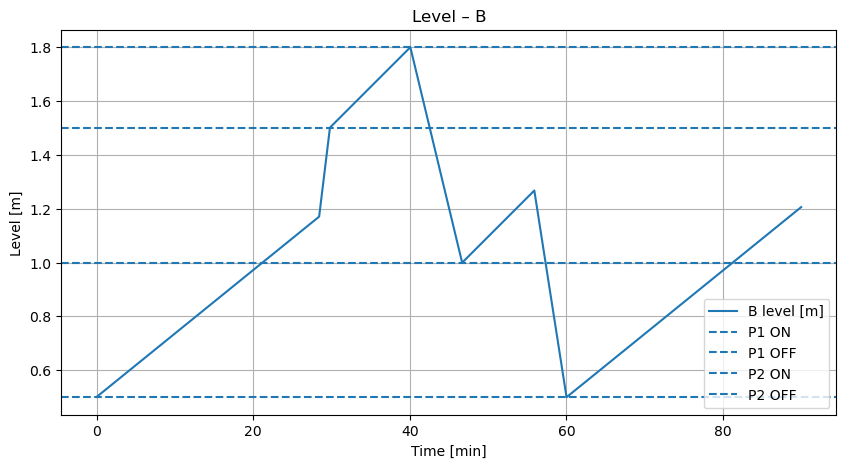

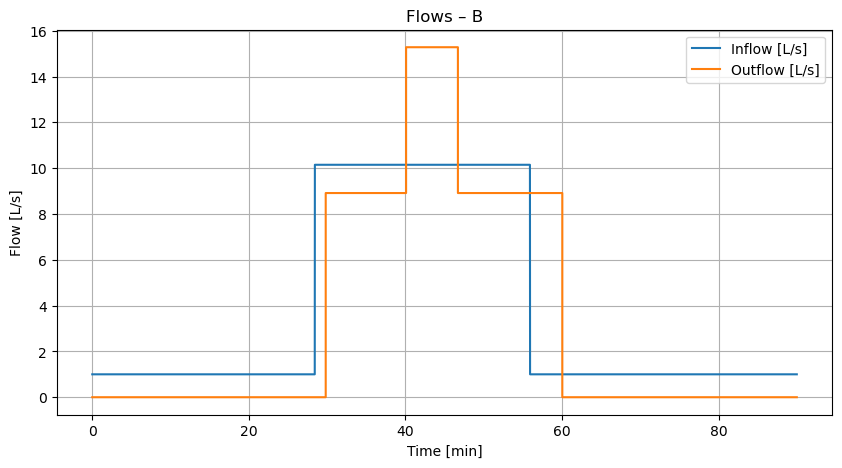

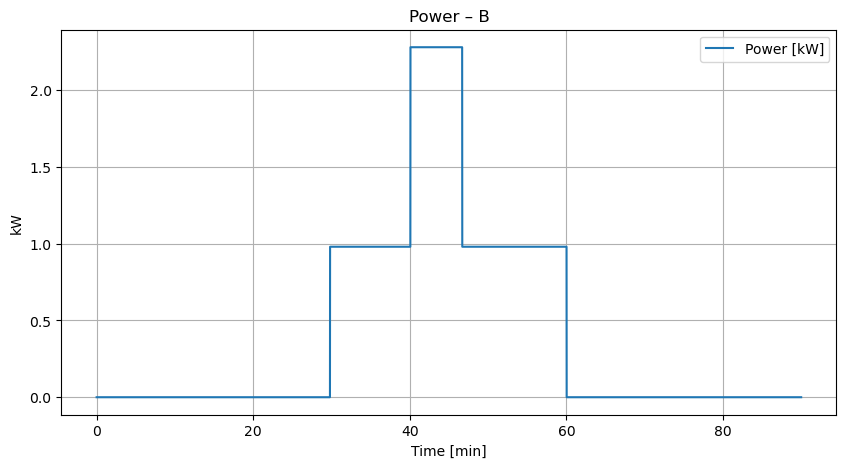

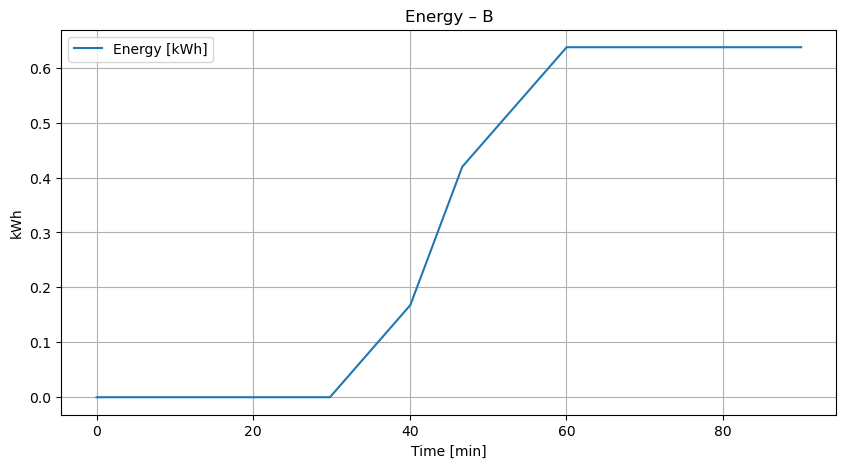

Saved per-station figures/CSVs under: results/network
Summary:
{'station': 'A', 'peak_level_m': 1.5018115961090945, 'total_energy_kWh': 0.4311612940767567, 'max_outflow_Lps': 9.147625684738157, 'runtime_min': 27.483333333333334}
{'station': 'B', 'peak_level_m': 1.8000478248263394, 'total_energy_kWh': 0.6372142143769065, 'max_outflow_Lps': 15.279531717300413, 'runtime_min': 30.216666666666665}


In [12]:
# N-STATION PUMPING NETWORK — simulate, route flows, and save outputs
# Paste this in one cell in Jupyter and run.

import os, csv, json, numpy as np, matplotlib.pyplot as plt

# =========================
# 0) Hydraulics (self-contained)
# =========================
g   = 9.81
rho = 1000.0
nu  = 1.0e-6

# Example ONE-PUMP curve (Q_lps vs H_m) and efficiency (eta) — replace with real KSB later
PUMP_Q_LPS = np.array([0, 3, 6, 8, 10, 11], dtype=float)
PUMP_H_M   = np.array([22,20,15,10,  5,  0], dtype=float)
PUMP_ETA   = np.array([0.40,0.55,0.70,0.72,0.65,0.40], dtype=float)

def H_pump_one(Q_m3s, Q_lps=PUMP_Q_LPS, H_m=PUMP_H_M):
    ql = np.clip(Q_m3s*1000.0, Q_lps[0], Q_lps[-1])
    return float(np.interp(ql, Q_lps, H_m))

def eta_pump_one(Q_m3s, Q_lps=PUMP_Q_LPS, ETA=PUMP_ETA):
    ql = np.clip(Q_m3s*1000.0, Q_lps[0], Q_lps[-1])
    return float(np.interp(ql, Q_lps, ETA))

def friction_factor(Re, rr):
    if Re < 2300:
        return 64.0 / max(Re, 1e-12)
    return 0.25 / (np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def make_system_funcs(D=0.10, L_m=120.0, delta_z=5.0, K_sum=3*0.3+0.5+1.0, eps_abs=0.00015):
    """Return (H_pipe_required, A_pipe, rel_rough) for given line."""
    A_pipe   = np.pi*(D**2)/4
    rel_rough= eps_abs/D
    def H_pipe_required(Q_m3s):
        if Q_m3s <= 0: 
            return delta_z
        v  = Q_m3s / A_pipe
        Re = v*D/nu
        f  = friction_factor(Re, rel_rough)
        h_f = f*(L_m/D)*(v**2)/(2*g)
        h_k = K_sum*(v**2)/(2*g)
        return delta_z + h_f + h_k
    return H_pipe_required, A_pipe, rel_rough

def operating_point(n_on, H_pipe_required, Q_lps=PUMP_Q_LPS, H_m=PUMP_H_M):
    """Solve H_pumps(Q) = H_pipe(Q) for n_on identical pumps in parallel."""
    if n_on <= 0:
        return 0.0, H_pipe_required(0.0)
    Qmax_guess = (Q_lps[-1]/1000.0) * n_on
    def H_pumps_parallel(Q_total):
        return H_pump_one(Q_total/n_on, Q_lps, H_m)
    a, b = 0.0, Qmax_guess
    Ha = H_pumps_parallel(a) - H_pipe_required(a)
    Hb = H_pumps_parallel(b) - H_pipe_required(b)
    if Ha < 0 and Hb < 0:
        return 0.0, H_pipe_required(0.0)
    for _ in range(60):
        m  = 0.5*(a+b)
        Hm = H_pumps_parallel(m) - H_pipe_required(m)
        if np.sign(Hm) == np.sign(Ha):
            a, Ha = m, Hm
        else:
            b, Hb = m, Hm
        if b - a < 1e-8:
            break
    Q_star = 0.5*(a+b)
    H_star = H_pumps_parallel(Q_star)
    return Q_star, H_star

# =========================
# 1) PumpStation class
# =========================
class PumpStation:
    def __init__(
        self, name,
        d_shaft=1.8, h_shaft=2.0, level0=0.5,
        thresholds=None, pumps=2,
        inflow_func=None,
        # per-station hydraulics (can override defaults)
        D=0.10, L_m=120.0, delta_z=5.0, K_sum=3*0.3+0.5+1.0, eps_abs=0.00015,
        # per-station pump curves (optional override)
        pump_Q_lps=None, pump_H_m=None, pump_eta=None
    ):
        self.name = name
        self.h_shaft = h_shaft
        self.A_shaft = np.pi*(d_shaft/2)**2
        self.level = level0
        self.th = thresholds or {"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0}
        self.n_pumps_max = pumps
        self.inflow_func = inflow_func or (lambda t: 0.0)

        # hydraulics
        self.H_pipe_required, self.A_pipe, self.rel_rough = make_system_funcs(D, L_m, delta_z, K_sum, eps_abs)

        # pump curves (can override globally)
        self.pump_Q_lps = pump_Q_lps if pump_Q_lps is not None else PUMP_Q_LPS
        self.pump_H_m   = pump_H_m   if pump_H_m   is not None else PUMP_H_M
        self.pump_ETA   = pump_eta   if pump_eta   is not None else PUMP_ETA

        # states
        self.p1 = 0
        self.p2 = 0

        # logs
        self.t_min   = []
        self.levels  = []
        self.inflows = []
        self.outflows= []
        self.p1_on   = []
        self.p2_on   = []
        self.power_W = []
        self.energy_kWh = []

        self._E_acc = 0.0

    def step(self, t, dt, inflow_external=0.0):
        inflow = inflow_external + self.inflow_func(t)

        # hysteresis control
        if self.level > self.th["h_on1"]:  self.p1 = 1
        elif self.level < self.th["h_off1"]: self.p1 = 0
        if self.n_pumps_max >= 2:
            if self.level > self.th["h_on2"]:  self.p2 = 1
            elif self.level < self.th["h_off2"]: self.p2 = 0

        n_on = self.p1 + self.p2
        if n_on > 0:
            # operating point with this station's system curve
            Q_star, H_star = operating_point(n_on, self.H_pipe_required, self.pump_Q_lps, self.pump_H_m)
            q_per = max(Q_star / n_on, 0.0)
            eta   = max(eta_pump_one(q_per, self.pump_Q_lps, self.pump_ETA), 0.05)
            Phyd  = rho*g*Q_star*H_star
            Pel   = Phyd/eta
            qout  = Q_star
        else:
            Pel = 0.0
            qout= 0.0

        # water balance
        self.level = np.clip(self.level + (inflow - qout)/self.A_shaft * dt, 0.0, self.h_shaft)

        # energy accumulation
        self._E_acc += Pel*dt/3.6e6  # Wh->kWh

        # logs
        self.t_min.append(t/60.0)
        self.levels.append(self.level)
        self.inflows.append(inflow)
        self.outflows.append(qout)
        self.p1_on.append(self.p1)
        self.p2_on.append(self.p2)
        self.power_W.append(Pel)
        self.energy_kWh.append(self._E_acc)

        return qout

    def save_timeseries(self, folder):
        os.makedirs(folder, exist_ok=True)
        csv_path = os.path.join(folder, f"{self.name}_timeseries.csv")
        with open(csv_path, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f)
            w.writerow(["time_min","level_m","Q_in_Lps","Q_out_Lps","p1_on","p2_on","power_kW","energy_kWh"])
            for tm, h, qi, qo, s1, s2, P, E in zip(
                self.t_min, self.levels, self.inflows, self.outflows, self.p1_on, self.p2_on, self.power_W, self.energy_kWh
            ):
                w.writerow([tm, h, qi*1000.0, qo*1000.0, s1, s2, P/1000.0, E])

    def plot_and_save(self, folder):
        os.makedirs(folder, exist_ok=True)
        tm = np.array(self.t_min)

        # Level
        plt.figure(figsize=(10,5))
        plt.plot(tm, self.levels, label=f"{self.name} level [m]")
        plt.axhline(self.th["h_on1"],  ls="--", label="P1 ON")
        plt.axhline(self.th["h_off1"], ls="--", label="P1 OFF")
        if self.n_pumps_max >= 2:
            plt.axhline(self.th["h_on2"],  ls="--", label="P2 ON")
            plt.axhline(self.th["h_off2"], ls="--", label="P2 OFF")
        plt.xlabel("Time [min]"); plt.ylabel("Level [m]"); plt.title(f"Level – {self.name}")
        plt.grid(True); plt.legend()
        plt.savefig(os.path.join(folder, f"{self.name}_level.png"), dpi=200, bbox_inches="tight")
        plt.show()

        # Flows
        plt.figure(figsize=(10,5))
        plt.plot(tm, np.array(self.inflows)*1000.0, label="Inflow [L/s]")
        plt.step(tm, np.array(self.outflows)*1000.0, where="post", label="Outflow [L/s]")
        plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]"); plt.title(f"Flows – {self.name}")
        plt.grid(True); plt.legend()
        plt.savefig(os.path.join(folder, f"{self.name}_flows.png"), dpi=200, bbox_inches="tight")
        plt.show()

        # Power & Energy
        plt.figure(figsize=(10,5))
        plt.plot(tm, np.array(self.power_W)/1000.0, label="Power [kW]")
        plt.xlabel("Time [min]"); plt.ylabel("kW"); plt.title(f"Power – {self.name}")
        plt.grid(True); plt.legend()
        plt.savefig(os.path.join(folder, f"{self.name}_power.png"), dpi=200, bbox_inches="tight")
        plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(tm, self.energy_kWh, label="Energy [kWh]")
        plt.xlabel("Time [min]"); plt.ylabel("kWh"); plt.title(f"Energy – {self.name}")
        plt.grid(True); plt.legend()
        plt.savefig(os.path.join(folder, f"{self.name}_energy.png"), dpi=200, bbox_inches="tight")
        plt.show()

# =========================
# 2) Network configuration
# =========================
# Time
dt    = 1.0     # s
T_min = 90      # minutes
T     = int(T_min*60/dt)

# Example inflow functions (edit per station)
def rain_pulse(base_lps=0.5, start=20, rise=10, plat=15, fall=20, peak_lps=8.0):
    def f(t):
        tm = t/60.0
        q = base_lps/1000.0
        a,b,c,d = start, start+rise, start+rise+plat, start+rise+plat+fall
        if a <= tm < b:
            q += (peak_lps*(tm-a)/max(rise,1e-9))/1000.0
        elif b <= tm < c:
            q += (peak_lps)/1000.0
        elif c <= tm < d:
            q += (peak_lps*(1 - (tm-c)/max(fall,1e-9)))/1000.0
        return q
    return f

def constant_lps(lps=1.0):
    return lambda t: lps/1000.0

# Stations dictionary: key=name -> config
stations_cfg = {
    # Example two stations; copy & adapt until you have all 11
    "A": dict(d_shaft=1.8, h_shaft=2.0, thresholds={"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0},
              pumps=2, inflow_func=rain_pulse(base_lps=0.5, start=20, rise=10, plat=15, fall=20, peak_lps=8.0),
              D=0.10, L_m=120.0, delta_z=5.0, K_sum=3*0.3+0.5+1.0),
    "B": dict(d_shaft=1.8, h_shaft=2.0, thresholds={"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0},
              pumps=2, inflow_func=constant_lps(1.0),  # Fremdwasser
              D=0.10, L_m=100.0, delta_z=6.0, K_sum=3*0.3+0.5+1.0),
    # Add more like:
    # "C": dict(...),
    # ...
}

# Routing: for each upstream station, list of (downstream_name, fraction)
# Fractions should sum to <= 1.0. A special sink "WWTP" discards flow from network.
routing = {
    "A": [("B", 1.0)],   # all of A's outflow goes to B
    "B": [("WWTP", 1.0)] # B discharges to sink (wastewater treatment plant)
    # Add more edges as needed
}

# Build station objects
stations = {name: PumpStation(name, **cfg) for name, cfg in stations_cfg.items()}
names = list(stations.keys())

# =========================
# 3) Network simulation
# =========================
results_dir = "results/network"
os.makedirs(results_dir, exist_ok=True)

# Initialize external inflow accumulators per node (from upstream routing)
external_inflow = {name: 0.0 for name in names}

for k in range(T):
    t = k*dt

    # 1) At the start of the step, use the carried external inflows from previous step
    step_outflows = {name: 0.0 for name in names}

    # 2) Step each station with its current external inflow
    for name in names:
        qout = stations[name].step(t, dt, inflow_external=external_inflow[name])
        step_outflows[name] = qout

    # 3) Reset external inflow buckets for next step
    external_inflow = {name: 0.0 for name in names}

    # 4) Route outflows to downstream nodes for the next step
    for up_name, qout in step_outflows.items():
        if qout <= 0.0:
            continue
        if up_name not in routing:
            # no routing declared -> sink
            continue
        for down_name, frac in routing[up_name]:
            q_to_down = qout * frac
            if down_name == "WWTP":
                # sink: do nothing (removed from network)
                continue
            if down_name in external_inflow:
                external_inflow[down_name] += q_to_down
            else:
                # unknown node name in routing
                pass

# =========================
# 4) Save per-station outputs & summary
# =========================
summary_rows = []
for name, st in stations.items():
    folder = os.path.join(results_dir, name)
    st.save_timeseries(folder)
    st.plot_and_save(folder)
    row = dict(
        station=name,
        peak_level_m=float(np.max(st.levels)),
        total_energy_kWh=float(st.energy_kWh[-1] if st.energy_kWh else 0.0),
        max_outflow_Lps=float(np.max(np.array(st.outflows))*1000.0 if st.outflows else 0.0),
        runtime_min=float(np.sum((np.array(st.p1_on)+np.array(st.p2_on))>0) * (dt/60.0))
    )
    summary_rows.append(row)

with open(os.path.join(results_dir, "summary.csv"), "w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["station","peak_level_m","max_outflow_Lps","total_energy_kWh","runtime_min"])
    w.writeheader()
    for r in summary_rows:
        w.writerow(r)

print("Saved per-station figures/CSVs under:", results_dir)
print("Summary:")
for r in summary_rows:
    print(r)


In [13]:
import csv, os

# Example directory (adapt if needed)
base_dir = "."

stations_file = os.path.join(base_dir, "stations.csv")

# Example data for 2 stations (extend to all 11)
stations = [
    {
        "name":"A",
        "d_shaft":1.8, "h_shaft":2.0, "pumps":2,
        "h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
        "D_m":0.10,"L_m":120.0,"delta_z_m":5.0,"K_sum":2.4,
        "base_lps":0.5,
        "storm_start_min":20,"storm_rise_min":10,"storm_plat_min":15,"storm_fall_min":20,"storm_peak_lps":8.0,
        "pump_curve_csv":"pumps/ksb_A.csv"
    },
    {
        "name":"B",
        "d_shaft":1.8, "h_shaft":2.0, "pumps":2,
        "h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
        "D_m":0.10,"L_m":100.0,"delta_z_m":6.0,"K_sum":2.4,
        "base_lps":1.0,  # Fremdwasser 1 L/s
        "storm_start_min":"","storm_rise_min":"","storm_plat_min":"","storm_fall_min":"","storm_peak_lps":"",
        "pump_curve_csv":"pumps/ksb_B.csv"
    }
]

# Save CSV
with open(stations_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=stations[0].keys())
    writer.writeheader()
    writer.writerows(stations)

print("Created:", stations_file)


Created: .\stations.csv


In [14]:
routing_file = os.path.join(base_dir, "routing.csv")

# Example routing: A → B, B → WWTP
routing = [
    {"upstream":"A","downstream":"B","fraction":1.0},
    {"upstream":"B","downstream":"WWTP","fraction":1.0}
]

with open(routing_file, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["upstream","downstream","fraction"])
    writer.writeheader()
    writer.writerows(routing)

print("Created:", routing_file)


Created: .\routing.csv


In [15]:
os.makedirs("pumps", exist_ok=True)

example_curve = [
    {"Q_lps":0,"H_m":22,"eta":0.40},
    {"Q_lps":3,"H_m":20,"eta":0.55},
    {"Q_lps":6,"H_m":15,"eta":0.70},
    {"Q_lps":8,"H_m":10,"eta":0.72},
    {"Q_lps":10,"H_m":5,"eta":0.65},
    {"Q_lps":11,"H_m":0,"eta":0.40}
]

for pumpname in ["ksb_A.csv","ksb_B.csv"]:
    with open(os.path.join("pumps", pumpname), "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["Q_lps","H_m","eta"])
        writer.writeheader()
        writer.writerows(example_curve)

print("Created pump curves in ./pumps/")


Created pump curves in ./pumps/


In [17]:
import os, csv

# ---------------------------------------
# 1) Create pump curve CSVs (mock values)
# ---------------------------------------
os.makedirs("pumps", exist_ok=True)

example_curve = [
    {"Q_lps":0,"H_m":22,"eta":0.40},
    {"Q_lps":3,"H_m":20,"eta":0.55},
    {"Q_lps":6,"H_m":15,"eta":0.70},
    {"Q_lps":8,"H_m":10,"eta":0.72},
    {"Q_lps":10,"H_m":5,"eta":0.65},
    {"Q_lps":11,"H_m":0,"eta":0.40},
]

station_names = list("ABCDEFGHIJK")  # 11 stations

for name in station_names:
    path = os.path.join("pumps", f"ksb_{name}.csv")
    with open(path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=["Q_lps","H_m","eta"])
        w.writeheader()
        w.writerows(example_curve)

# -------------------------------------------------
# 2) Create stations.csv with 11 mock station rows
# -------------------------------------------------
stations = [
    # name, d_shaft, h_shaft, pumps, thresholds, pipe (D, L, dz, K_sum), base flow, storm (optional), pump curve path
    # Tip: adjust base_lps / storm_* later to match real inflows
    {"name":"A","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.10,"L_m":120.0,"delta_z_m":5.0,"K_sum":2.4,
     "base_lps":0.6,"storm_start_min":20,"storm_rise_min":10,"storm_plat_min":15,"storm_fall_min":20,"storm_peak_lps":8.0,
     "pump_curve_csv":"pumps/ksb_A.csv"},
    {"name":"B","d_shaft":1.8,"h_shaft":2.0,"pumps":1,"h_on1":1.4,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.08,"L_m":90.0,"delta_z_m":4.0,"K_sum":2.4,
     "base_lps":0.8,"storm_start_min":"","storm_rise_min":"","storm_plat_min":"","storm_fall_min":"","storm_peak_lps":"",
     "pump_curve_csv":"pumps/ksb_B.csv"},
    {"name":"C","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.6,"h_off1":0.6,"h_on2":1.9,"h_off2":1.0,
     "D_m":0.12,"L_m":150.0,"delta_z_m":6.0,"K_sum":2.7,
     "base_lps":0.5,"storm_start_min":25,"storm_rise_min":10,"storm_plat_min":10,"storm_fall_min":15,"storm_peak_lps":6.0,
     "pump_curve_csv":"pumps/ksb_C.csv"},
    {"name":"D","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.10,"L_m":110.0,"delta_z_m":5.0,"K_sum":2.4,
     "base_lps":0.7,"storm_start_min":"","storm_rise_min":"","storm_plat_min":"","storm_fall_min":"","storm_peak_lps":"",
     "pump_curve_csv":"pumps/ksb_D.csv"},
    {"name":"E","d_shaft":1.8,"h_shaft":2.0,"pumps":1,"h_on1":1.4,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.10,"L_m":130.0,"delta_z_m":5.0,"K_sum":2.6,
     "base_lps":0.9,"storm_start_min":30,"storm_rise_min":10,"storm_plat_min":10,"storm_fall_min":10,"storm_peak_lps":5.0,
     "pump_curve_csv":"pumps/ksb_E.csv"},
    {"name":"F","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.12,"L_m":180.0,"delta_z_m":7.0,"K_sum":2.8,
     "base_lps":0.6,"storm_start_min":"","storm_rise_min":"","storm_plat_min":"","storm_fall_min":"","storm_peak_lps":"",
     "pump_curve_csv":"pumps/ksb_F.csv"},
    {"name":"G","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.6,"h_off1":0.6,"h_on2":1.9,"h_off2":1.0,
     "D_m":0.15,"L_m":200.0,"delta_z_m":8.0,"K_sum":3.0,
     "base_lps":0.5,"storm_start_min":22,"storm_rise_min":8,"storm_plat_min":12,"storm_fall_min":20,"storm_peak_lps":7.0,
     "pump_curve_csv":"pumps/ksb_G.csv"},
    {"name":"H","d_shaft":1.8,"h_shaft":2.0,"pumps":1,"h_on1":1.4,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.10,"L_m":95.0,"delta_z_m":4.0,"K_sum":2.3,
     "base_lps":1.2,"storm_start_min":"","storm_rise_min":"","storm_plat_min":"","storm_fall_min":"","storm_peak_lps":"",
     "pump_curve_csv":"pumps/ksb_H.csv"},
    {"name":"I","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.15,"L_m":220.0,"delta_z_m":8.0,"K_sum":3.0,
     "base_lps":0.7,"storm_start_min":28,"storm_rise_min":12,"storm_plat_min":15,"storm_fall_min":18,"storm_peak_lps":9.0,
     "pump_curve_csv":"pumps/ksb_I.csv"},
    {"name":"J","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.12,"L_m":160.0,"delta_z_m":6.0,"K_sum":2.7,
     "base_lps":0.6,"storm_start_min":"","storm_rise_min":"","storm_plat_min":"","storm_fall_min":"","storm_peak_lps":"",
     "pump_curve_csv":"pumps/ksb_J.csv"},
    {"name":"K","d_shaft":1.8,"h_shaft":2.0,"pumps":2,"h_on1":1.5,"h_off1":0.5,"h_on2":1.8,"h_off2":1.0,
     "D_m":0.20,"L_m":250.0,"delta_z_m":9.0,"K_sum":3.2,
     "base_lps":0.8,"storm_start_min":35,"storm_rise_min":10,"storm_plat_min":10,"storm_fall_min":15,"storm_peak_lps":10.0,
     "pump_curve_csv":"pumps/ksb_K.csv"},
]

with open("stations.csv","w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=list(stations[0].keys()))
    w.writeheader()
    w.writerows(stations)

# --------------------------------------------
# 3) Create routing.csv (branched mock network)
# --------------------------------------------
# Structure example:
#   A -> D
#   B -> D
#   C -> E
#   D -> F
#   E -> F
#   F -> I
#   G -> H
#   H -> I
#   I -> J
#   J -> K
#   K -> WWTP
routing = [
    {"upstream":"A","downstream":"D","fraction":1.0},
    {"upstream":"B","downstream":"D","fraction":1.0},
    {"upstream":"C","downstream":"E","fraction":1.0},
    {"upstream":"D","downstream":"F","fraction":1.0},
    {"upstream":"E","downstream":"F","fraction":1.0},
    {"upstream":"F","downstream":"I","fraction":1.0},
    {"upstream":"G","downstream":"H","fraction":1.0},
    {"upstream":"H","downstream":"I","fraction":1.0},
    {"upstream":"I","downstream":"J","fraction":1.0},
    {"upstream":"J","downstream":"K","fraction":1.0},
    {"upstream":"K","downstream":"WWTP","fraction":1.0},
]

with open("routing.csv","w", newline="", encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["upstream","downstream","fraction"])
    w.writeheader()
    w.writerows(routing)

print("✅ Created:")
print("  - pumps/ksb_*.csv (11 files)")
print("  - stations.csv")
print("  - routing.csv")


✅ Created:
  - pumps/ksb_*.csv (11 files)
  - stations.csv
  - routing.csv


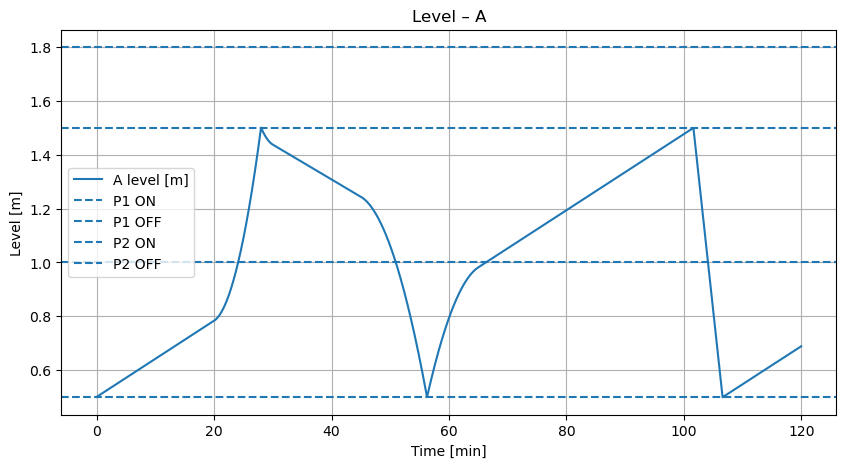

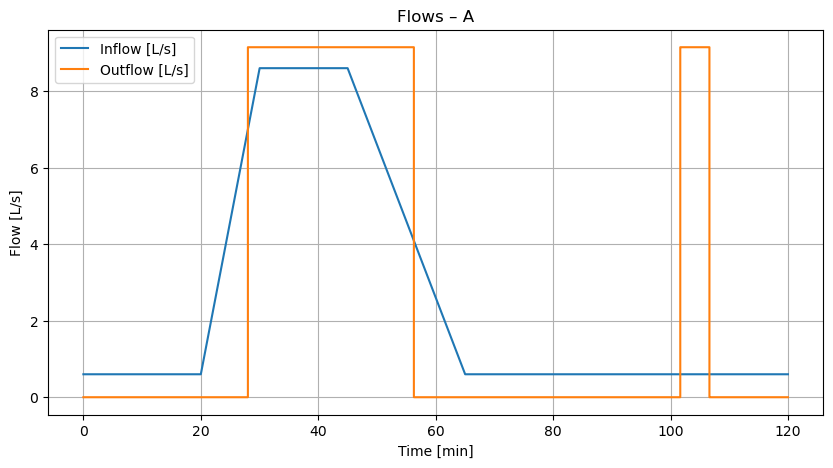

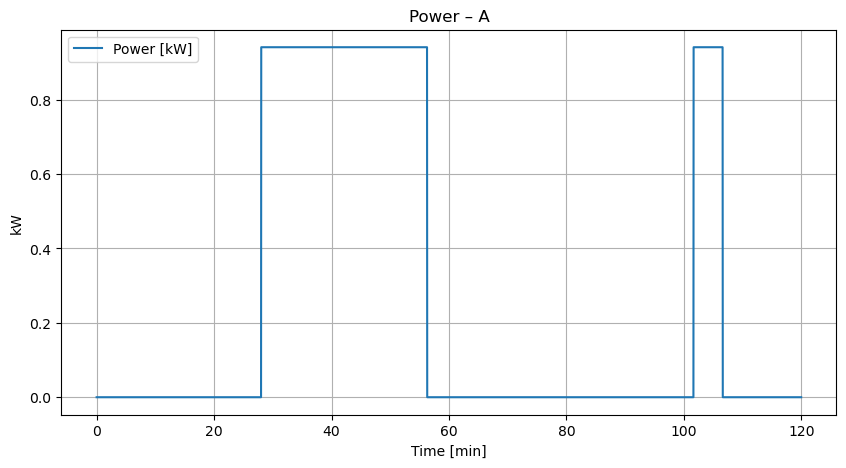

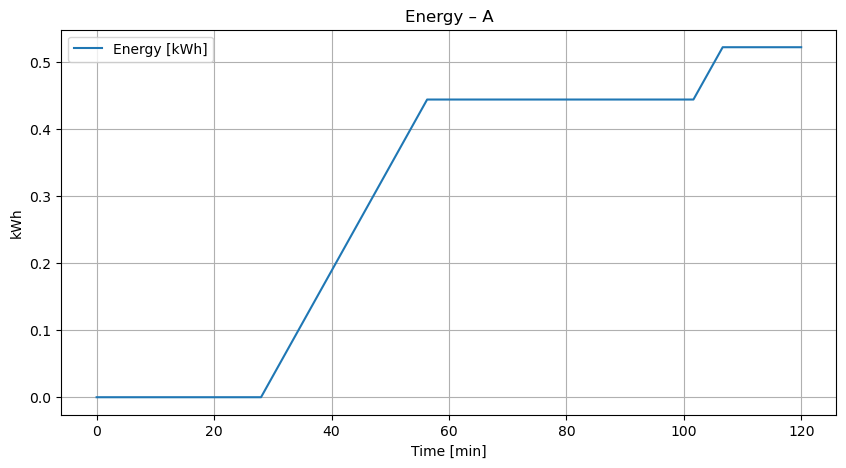

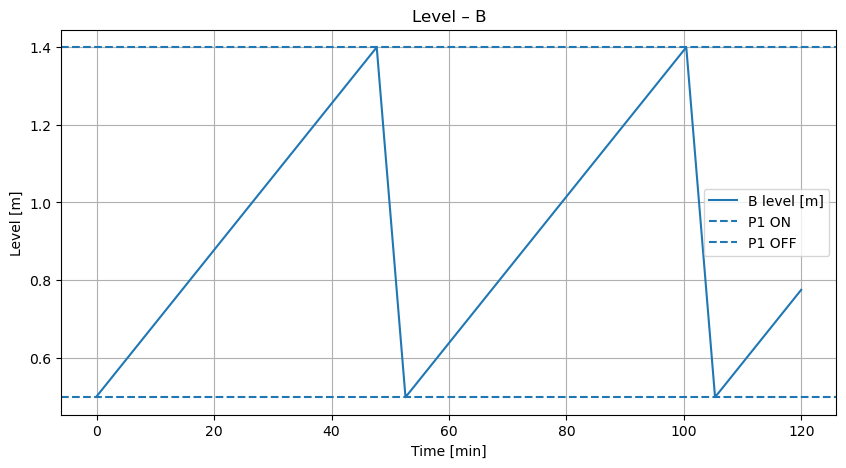

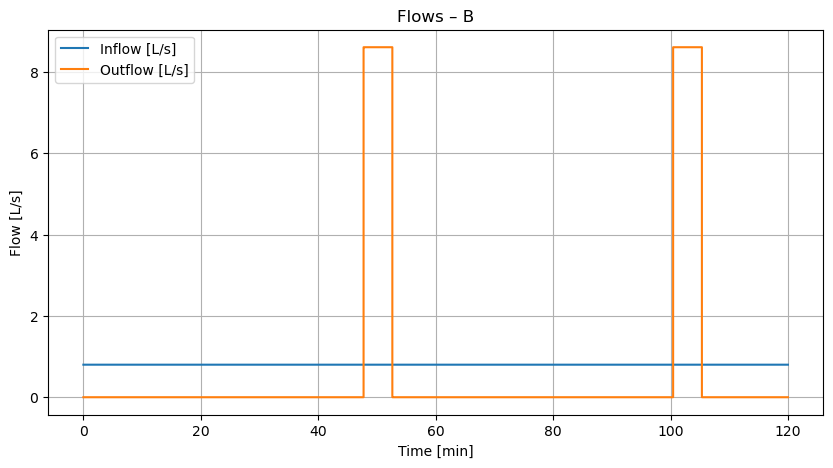

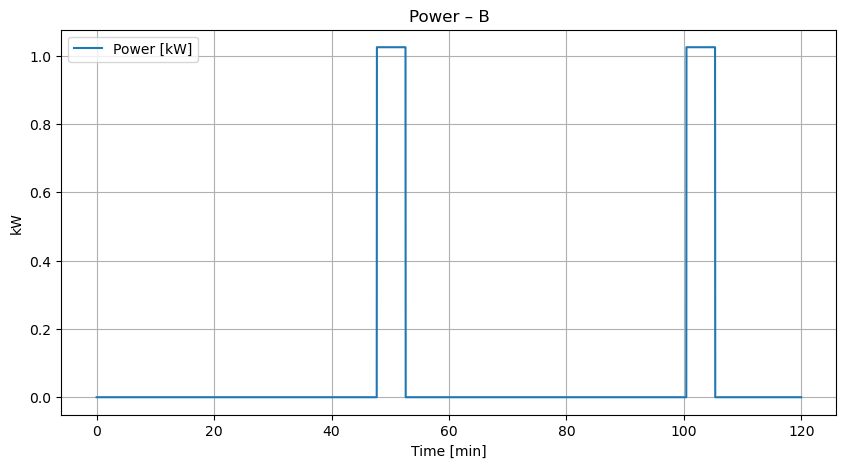

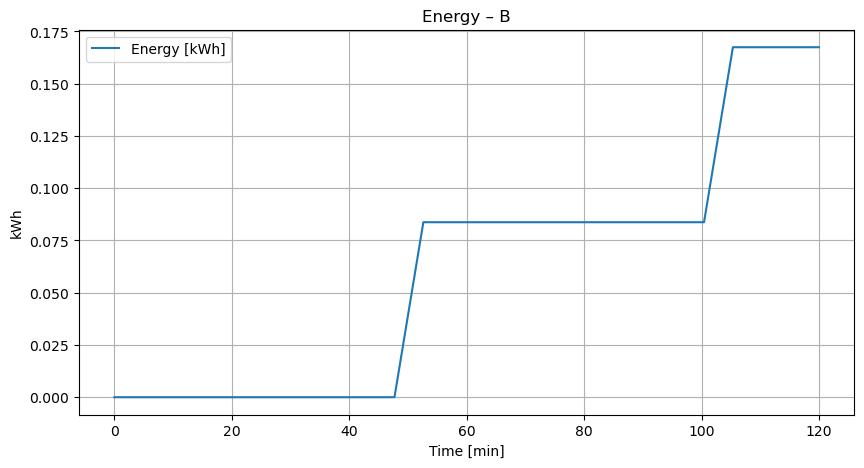

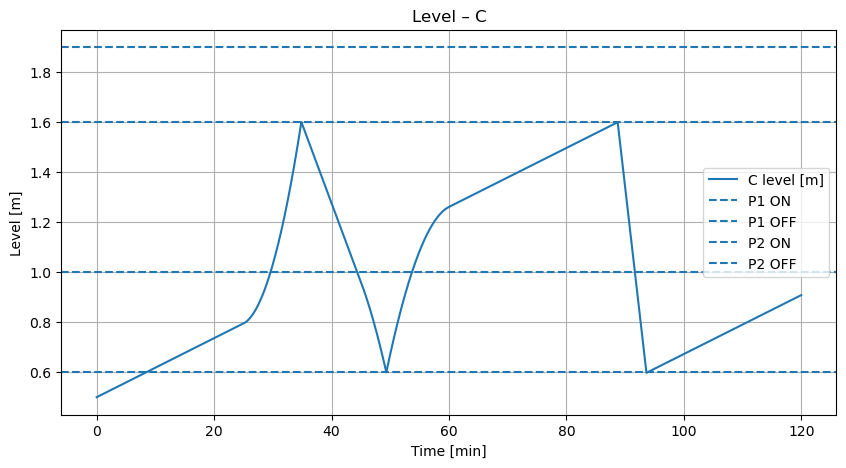

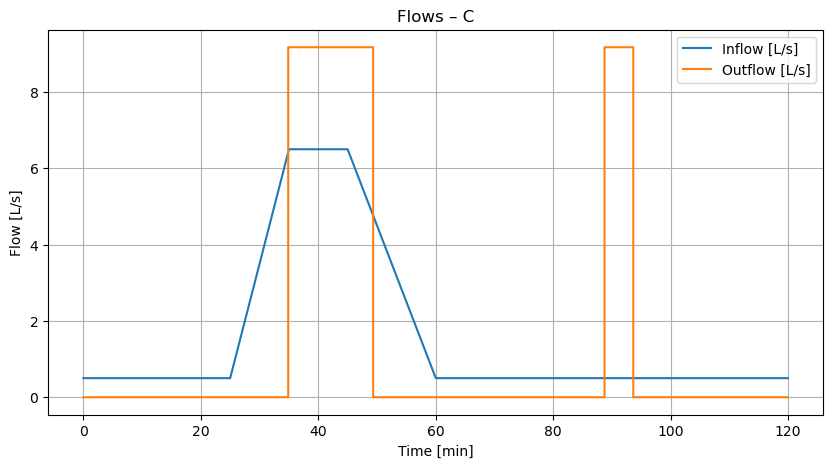

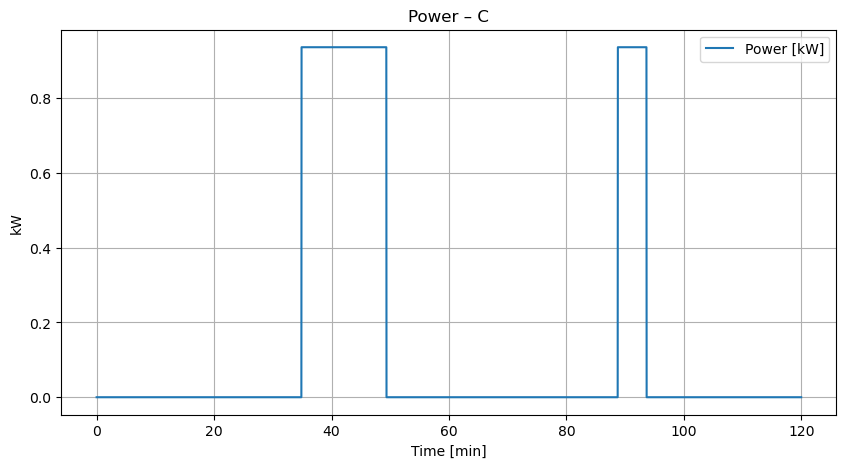

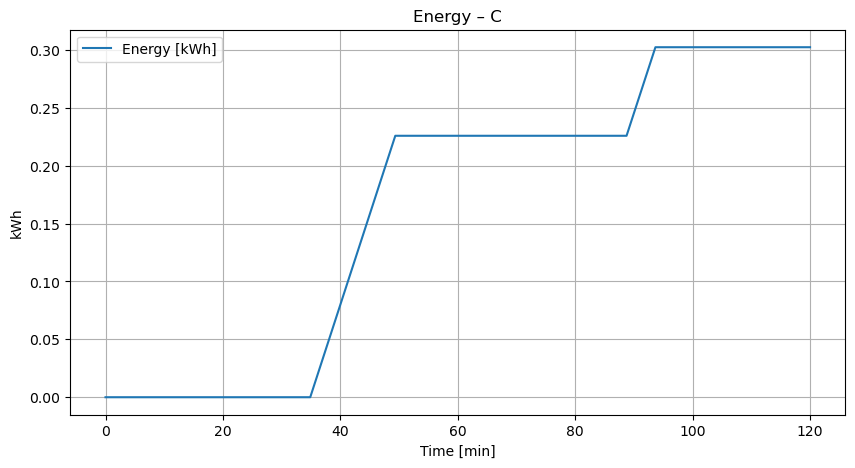

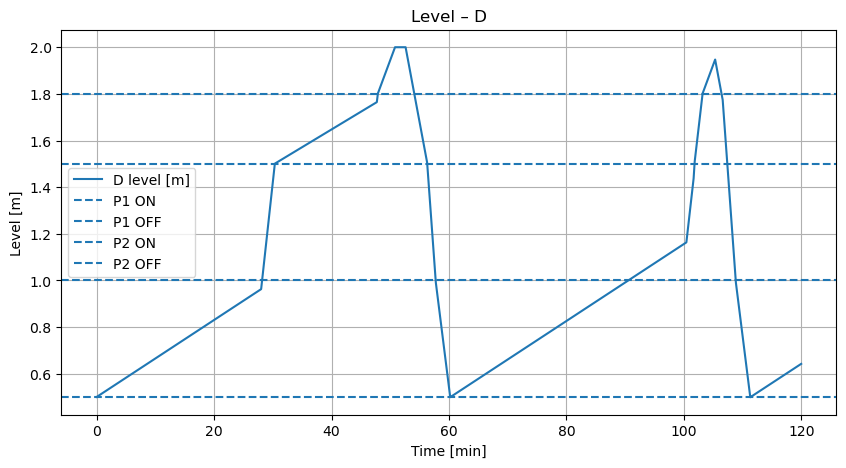

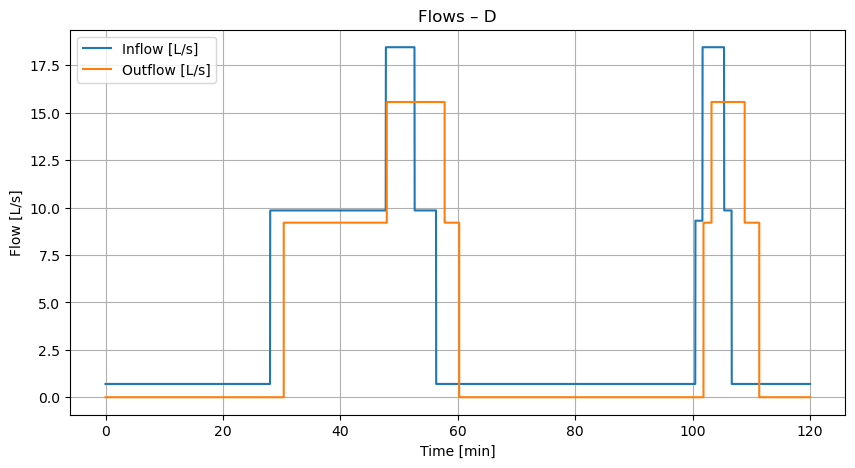

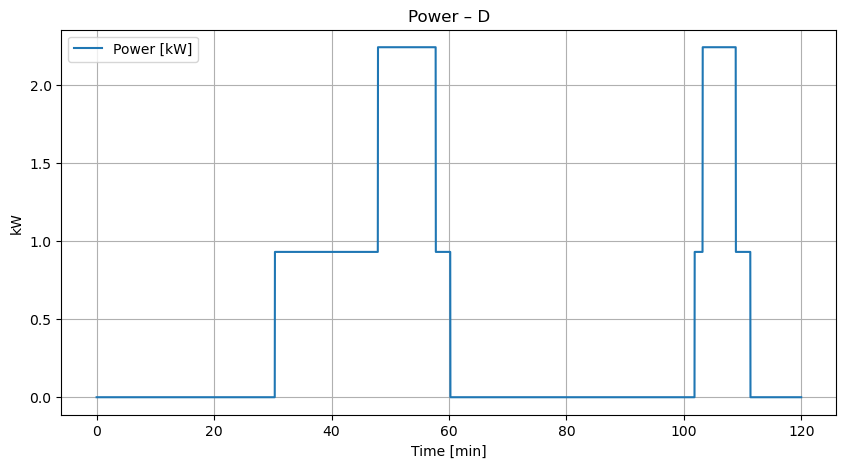

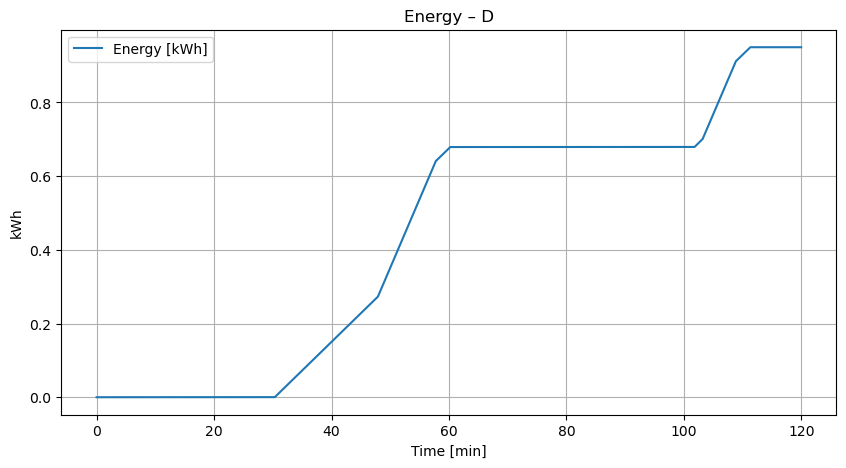

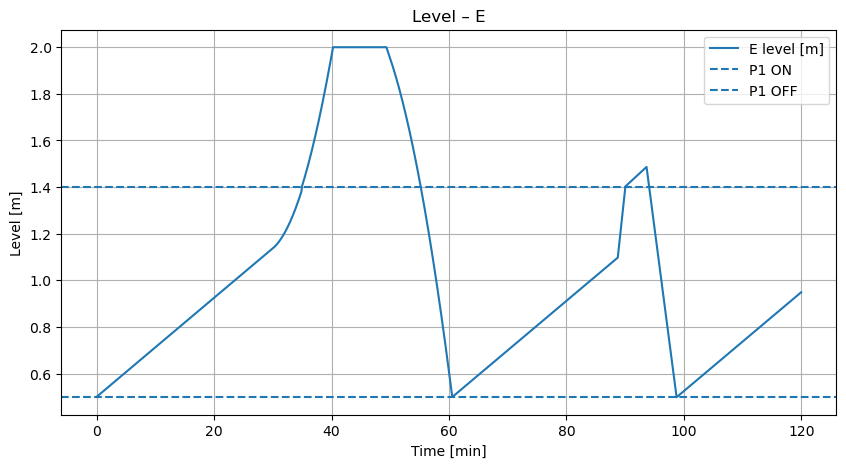

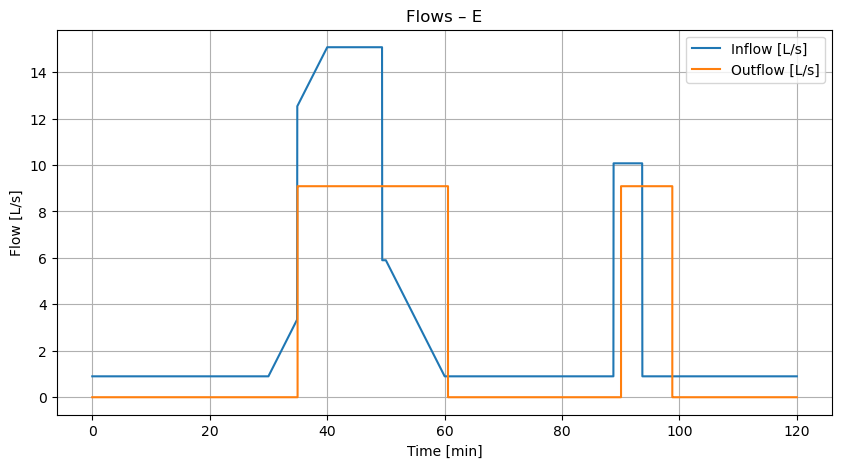

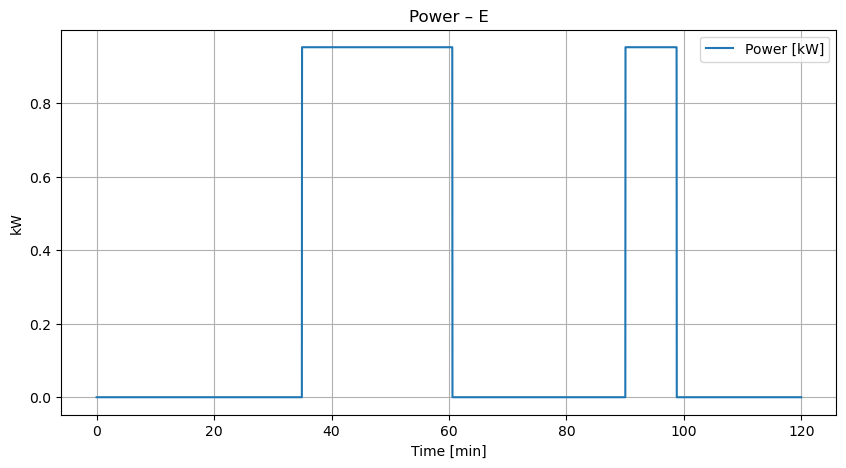

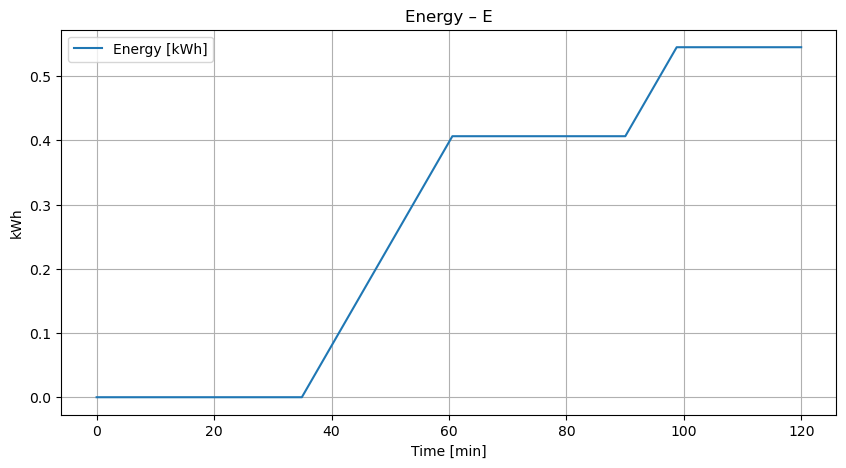

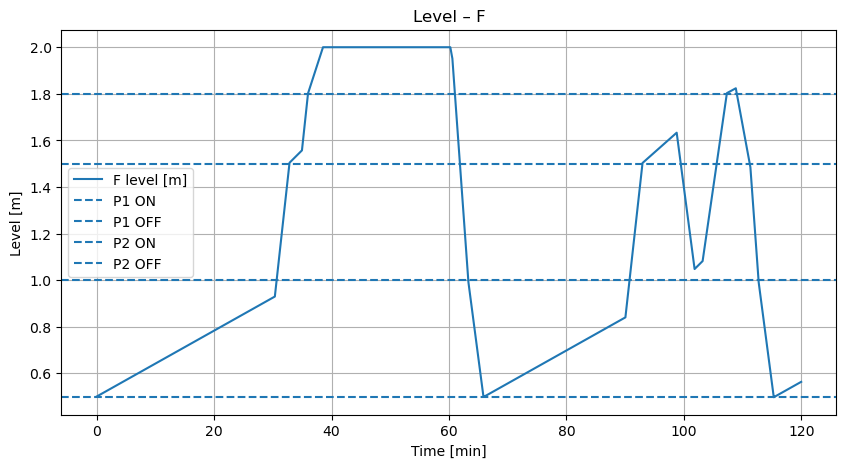

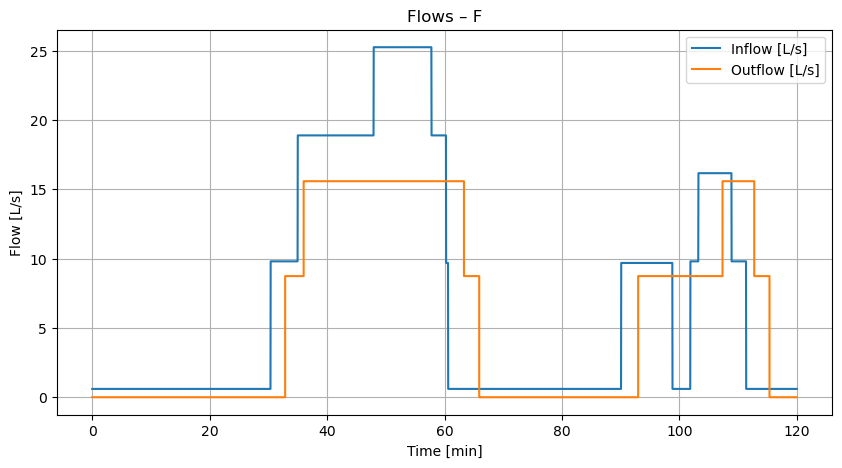

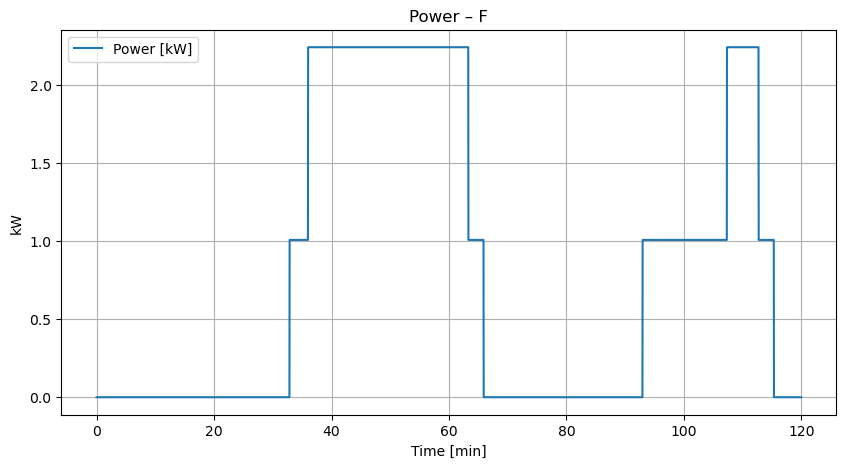

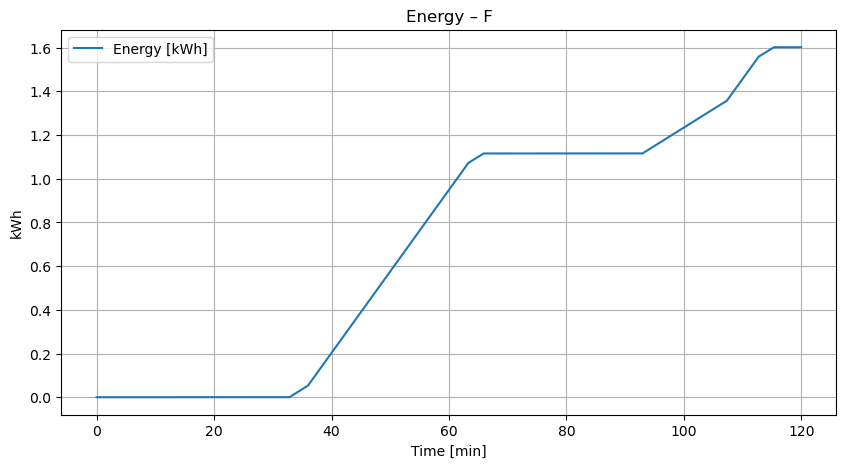

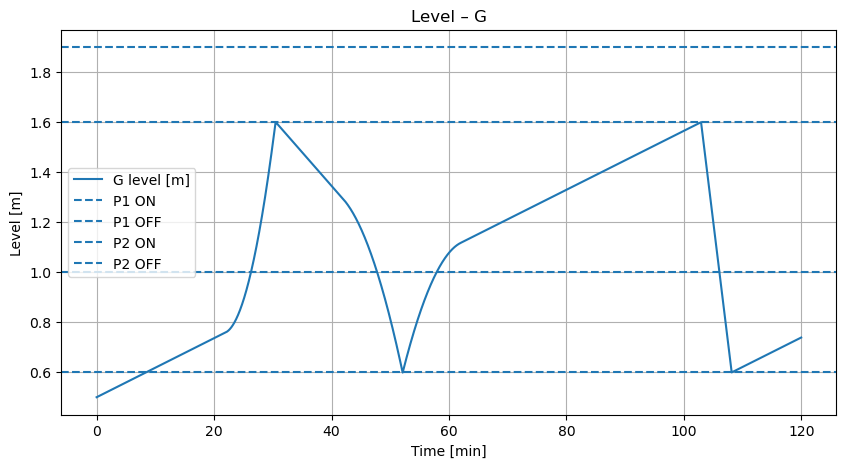

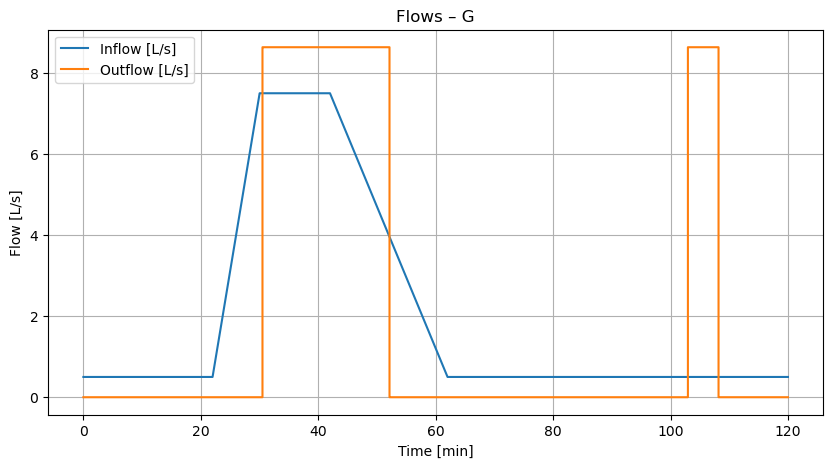

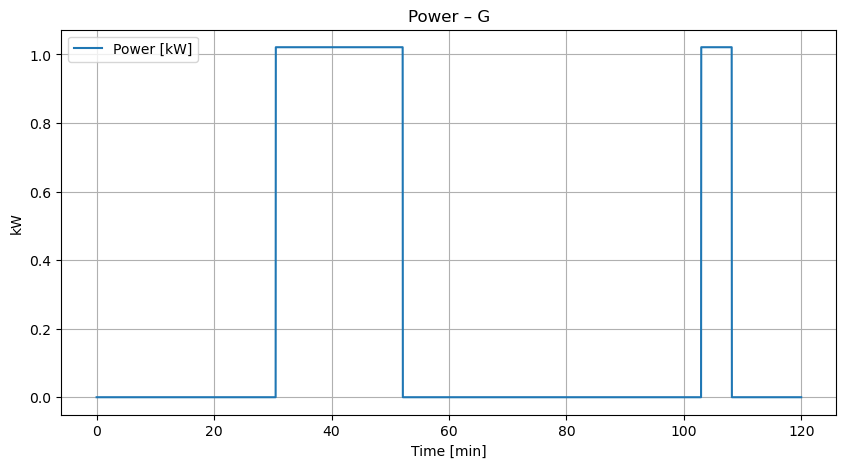

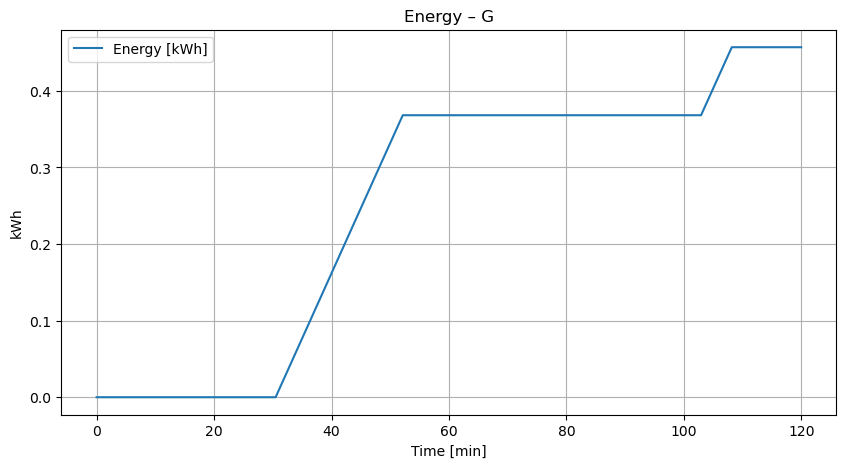

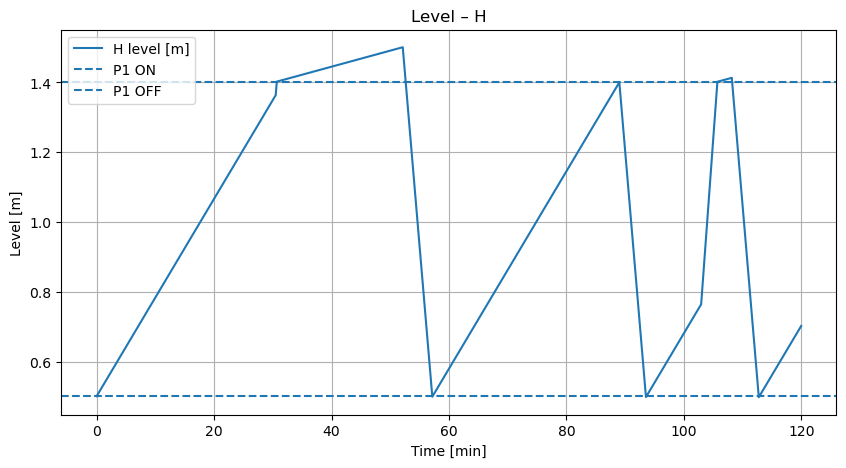

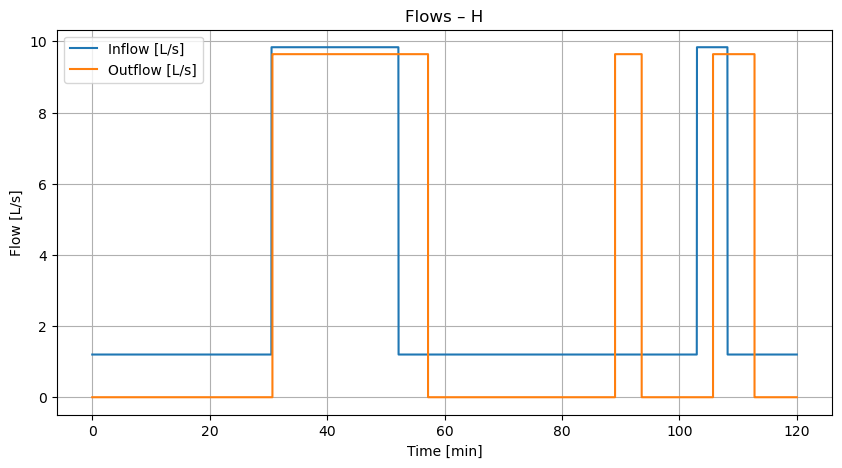

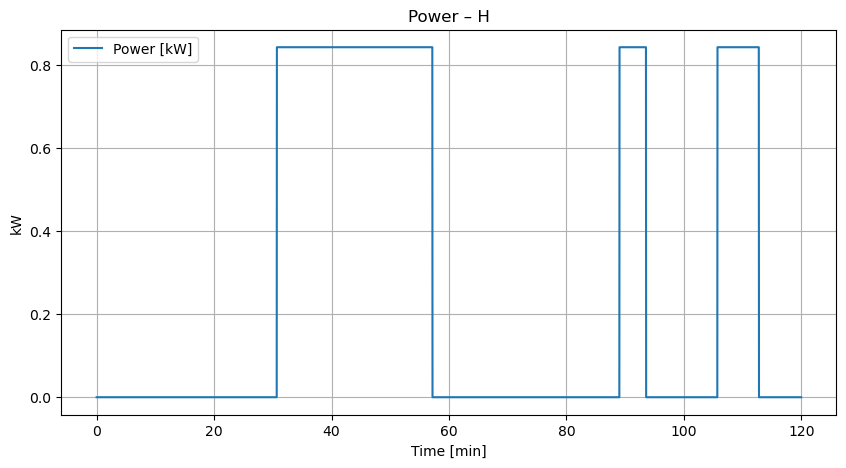

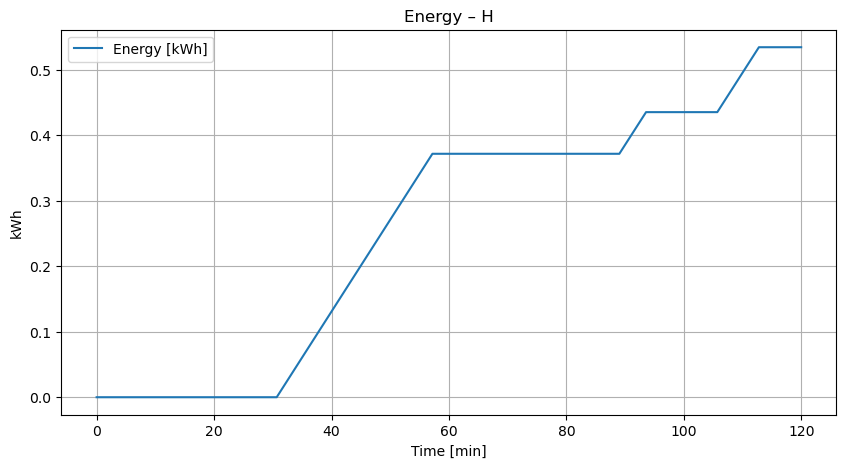

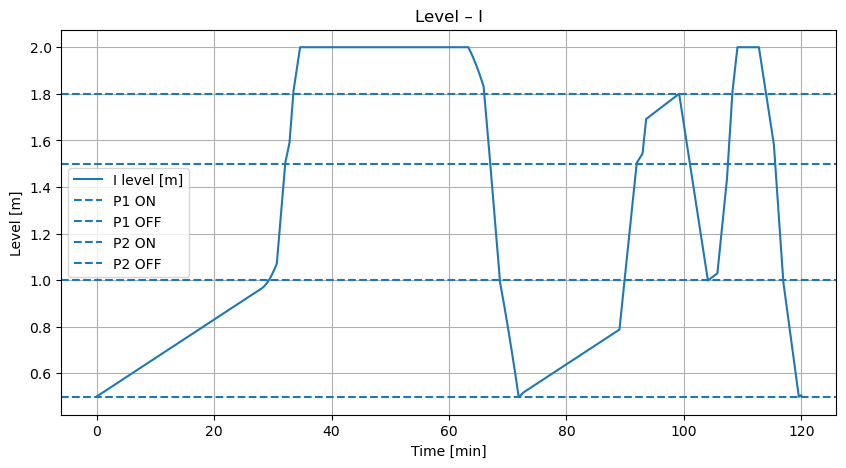

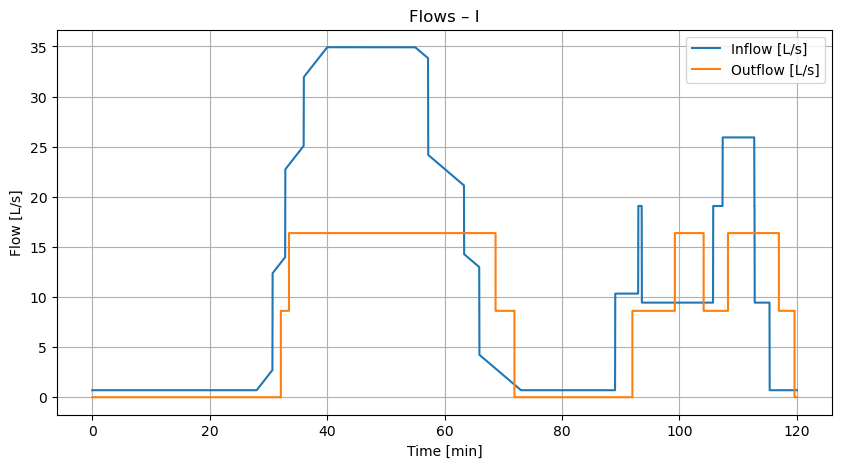

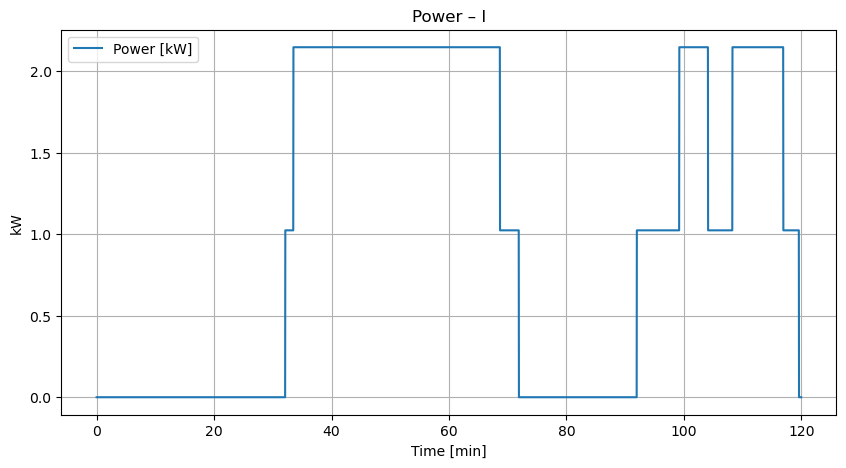

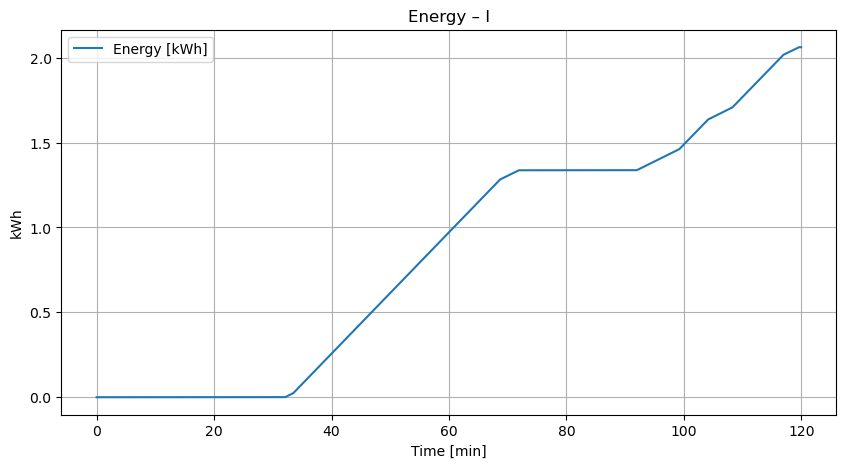

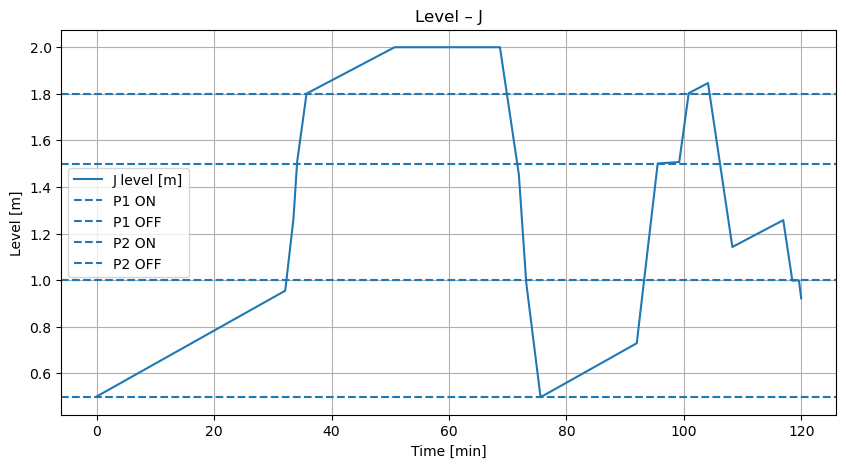

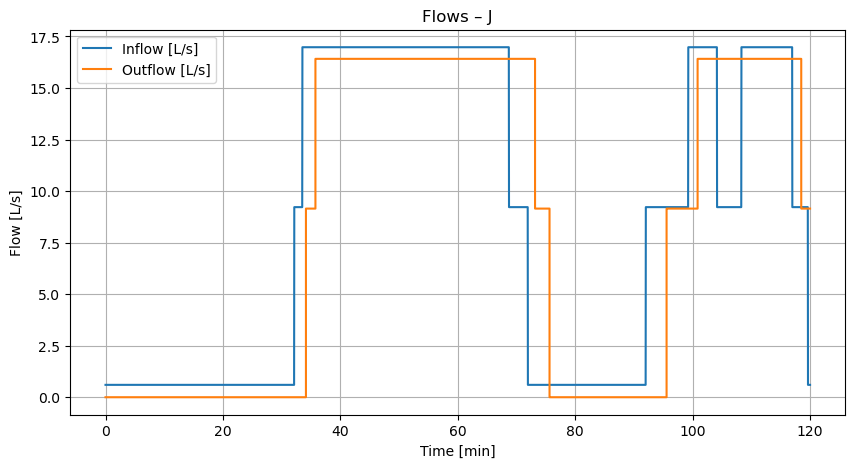

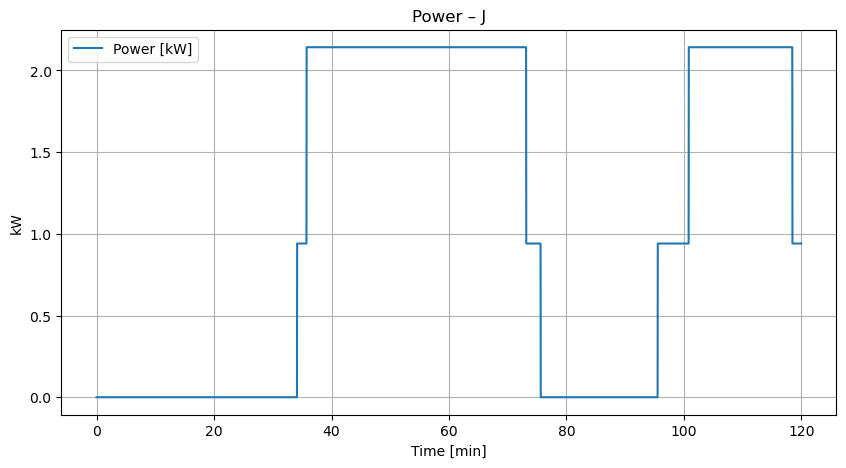

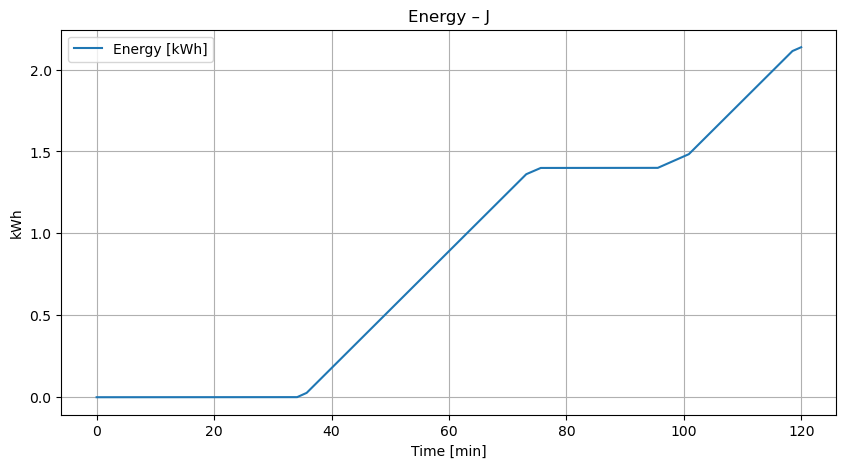

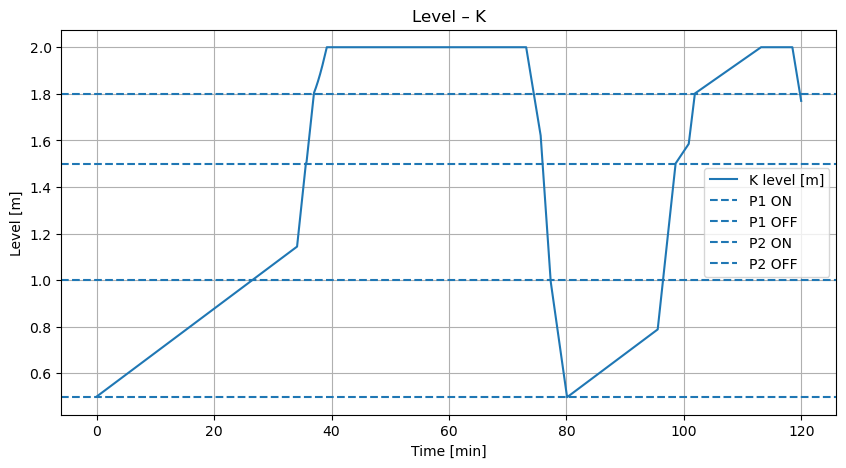

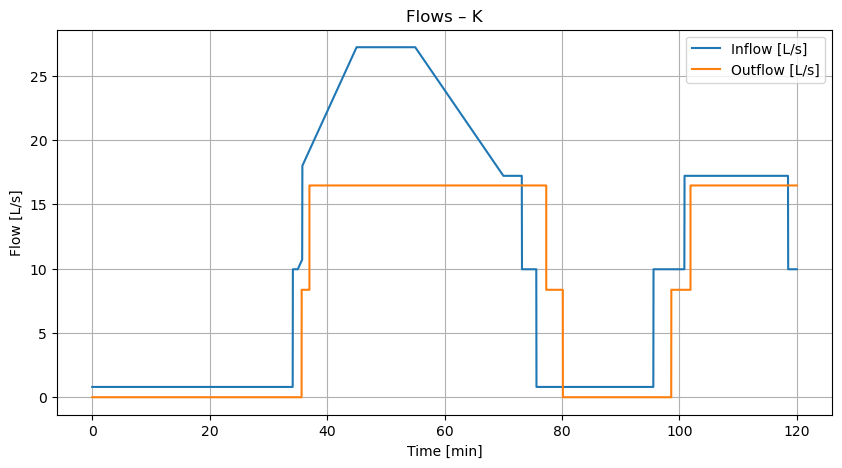

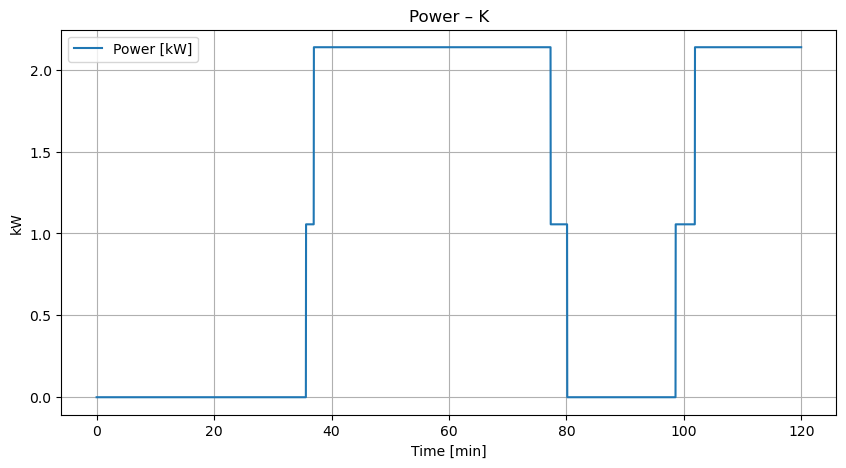

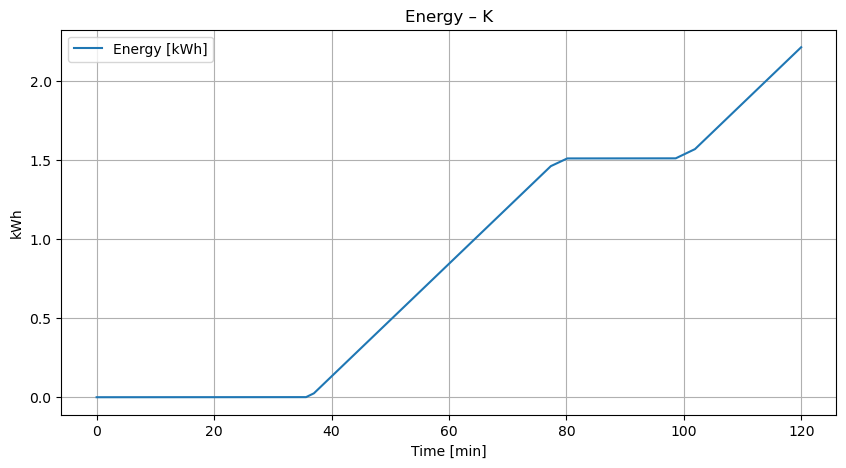

Saved per-station results to: results/network_11
{'station': 'A', 'peak_level_m': 1.501222133356829, 'max_outflow_Lps': 9.147625684738157, 'total_energy_kWh': 0.5213678716731672, 'runtime_min': 33.233333333333334}
{'station': 'B', 'peak_level_m': 1.4001345636747957, 'max_outflow_Lps': 8.60624670982361, 'total_energy_kWh': 0.1674312756222259, 'runtime_min': 9.8}
{'station': 'C', 'peak_level_m': 1.6010299665580952, 'max_outflow_Lps': 9.174297571182253, 'total_energy_kWh': 0.3022778659959941, 'runtime_min': 19.366666666666667}
{'station': 'D', 'peak_level_m': 2.0, 'max_outflow_Lps': 15.56612992286682, 'total_energy_kWh': 0.9499920428247838, 'runtime_min': 39.38333333333333}
{'station': 'E', 'peak_level_m': 2.0, 'max_outflow_Lps': 9.088186979293825, 'total_energy_kWh': 0.5448738735909822, 'runtime_min': 34.35}
{'station': 'F', 'peak_level_m': 2.0, 'max_outflow_Lps': 15.585804700851437, 'total_energy_kWh': 1.601939089705044, 'runtime_min': 55.416666666666664}
{'station': 'G', 'peak_level_m'

In [18]:
# 11-PUMPWERKE NETWORK: load from CSVs, simulate, save results
import os, csv, json, numpy as np, matplotlib.pyplot as plt

# ---------- helpers ----------
g, rho, nu = 9.81, 1000.0, 1.0e-6

def friction_factor(Re, rr):
    if Re < 2300: return 64.0/max(Re,1e-12)
    return 0.25/(np.log10(rr/3.7 + 5.74/(Re**0.9))**2)

def make_system_funcs(D=0.10, L_m=120.0, delta_z=5.0, K_sum=2.4, eps_abs=0.00015):
    A_pipe   = np.pi*(D**2)/4
    rel_rough= eps_abs/D
    def H_pipe_required(Q_m3s):
        if Q_m3s <= 0: return delta_z
        v  = Q_m3s / A_pipe
        Re = v*D/nu
        f  = friction_factor(Re, rel_rough)
        h_f = f*(L_m/D)*(v**2)/(2*g)
        h_k = K_sum*(v**2)/(2*g)
        return delta_z + h_f + h_k
    return H_pipe_required

def load_pump_curve(path, fallback=None):
    if (path is None) or (str(path).strip()=="") or (not os.path.exists(path)):
        # fallback curve (replace when you have real data)
        Q = np.array([0,3,6,8,10,11], float)
        H = np.array([22,20,15,10, 5, 0], float)
        E = np.array([0.40,0.55,0.70,0.72,0.65,0.40], float)
        return Q, H, E
    Q,H,E = [],[],[]
    with open(path,"r",encoding="utf-8") as f:
        r = csv.DictReader(f)
        for row in r:
            Q.append(float(row["Q_lps"]))
            H.append(float(row["H_m"]))
            E.append(float(row["eta"]))
    Q = np.array(Q,float); H = np.array(H,float); E = np.array(E,float)
    # ensure sorted by Q
    idx = np.argsort(Q); Q,H,E = Q[idx], H[idx], E[idx]
    return Q,H,E

def H_pump_one(Q_m3s, Q_lps, H_m):
    ql = np.clip(Q_m3s*1000.0, Q_lps[0], Q_lps[-1])
    return float(np.interp(ql, Q_lps, H_m))

def eta_pump_one(Q_m3s, Q_lps, ETA):
    ql = np.clip(Q_m3s*1000.0, Q_lps[0], Q_lps[-1])
    return float(np.interp(ql, Q_lps, ETA))

def operating_point(n_on, H_sys, Q_lps, H_m):
    if n_on <= 0: return 0.0, H_sys(0.0)
    Qmax = (Q_lps[-1]/1000.0)*n_on
    def Hp(Qtot): return H_pump_one(Qtot/n_on, Q_lps, H_m)
    a,b = 0.0, Qmax
    Ha = Hp(a)-H_sys(a); Hb = Hp(b)-H_sys(b)
    if Ha<0 and Hb<0: return 0.0, H_sys(0.0)
    for _ in range(60):
        m = 0.5*(a+b)
        Hm = Hp(m)-H_sys(m)
        if np.sign(Hm)==np.sign(Ha): a,Ha = m,Hm
        else: b,Hb = m,Hm
        if b-a < 1e-8: break
    Qs = 0.5*(a+b)
    return Qs, Hp(Qs)

def trapezoid_inflow_factory(base_lps=0.5, storm=None):
    # storm = dict(start, rise, plat, fall, peak_lps) OR None
    def f(t):
        q = base_lps/1000.0
        if storm and all(k in storm for k in ("start","rise","plat","fall","peak_lps")):
            tm = t/60.0
            a = storm["start"]; b = a + storm["rise"]
            c = b + storm["plat"]; d = c + storm["fall"]
            peak = storm["peak_lps"]/1000.0
            if a <= tm < b:   q += peak*(tm-a)/max(storm["rise"],1e-9)
            elif b <= tm < c: q += peak
            elif c <= tm < d: q += peak*(1 - (tm-c)/max(storm["fall"],1e-9))
        return q
    return f

# ---------- PumpStation ----------
class PumpStation:
    def __init__(self, row):
        self.name = row["name"]
        self.A_shaft = np.pi*(float(row["d_shaft"])/2)**2
        self.h_shaft = float(row["h_shaft"])
        self.level   = 0.5
        self.n_pumps = int(row["pumps"])
        self.th = {
            "h_on1": float(row["h_on1"]),
            "h_off1":float(row["h_off1"]),
            "h_on2": float(row["h_on2"]) if self.n_pumps>=2 else 1e9,
            "h_off2":float(row["h_off2"]) if self.n_pumps>=2 else -1e9
        }
        # hydraulics
        D      = float(row["D_m"])
        L_m    = float(row["L_m"])
        dz     = float(row["delta_z_m"])
        K_sum  = float(row["K_sum"])
        self.H_sys = make_system_funcs(D, L_m, dz, K_sum)

        # pump curve
        Q,H,E = load_pump_curve(row["pump_curve_csv"])
        self.Q_lps, self.H_m, self.ETA = Q,H,E

        # inflow
        base_lps = float(row["base_lps"])
        if row["storm_start_min"].strip()=="":
            storm=None
        else:
            storm = dict(
                start=float(row["storm_start_min"]),
                rise =float(row["storm_rise_min"]),
                plat =float(row["storm_plat_min"]),
                fall =float(row["storm_fall_min"]),
                peak_lps=float(row["storm_peak_lps"])
            )
        self.inflow_func = trapezoid_inflow_factory(base_lps, storm)

        # logs
        self.t_min=[]; self.levels=[]; self.inflows=[]; self.outflows=[]
        self.p1=[]; self.p2=[]; self.power=[]; self.energy=[]
        self._E=0.0

    def step(self, t, dt, inflow_up=0.0):
        # total inflow
        qi = inflow_up + self.inflow_func(t)

        # hysteresis
        # pump1
        p1 = self.p1[-1] if self.p1 else 0
        if   self.level > self.th["h_on1"]:  p1 = 1
        elif self.level < self.th["h_off1"]: p1 = 0
        # pump2
        p2 = self.p2[-1] if self.p2 else 0
        if self.n_pumps>=2:
            if   self.level > self.th["h_on2"]:  p2 = 1
            elif self.level < self.th["h_off2"]: p2 = 0
        else:
            p2 = 0
        n_on = p1 + p2

        # operating point
        if n_on>0:
            qstar, hstar = operating_point(n_on, self.H_sys, self.Q_lps, self.H_m)
            qout = qstar
            eta  = max(eta_pump_one(max(qstar/n_on,0.0), self.Q_lps, self.ETA), 0.05)
            Pel  = (rho*g*qstar*hstar)/eta
        else:
            qout, Pel = 0.0, 0.0

        # water balance
        self.level = float(np.clip(self.level + (qi-qout)/self.A_shaft*dt, 0.0, self.h_shaft))
        self._E   += Pel*dt/3.6e6

        # log
        self.t_min.append(t/60.0)
        self.levels.append(self.level)
        self.inflows.append(qi)
        self.outflows.append(qout)
        self.p1.append(p1); self.p2.append(p2)
        self.power.append(Pel); self.energy.append(self._E)

        return qout

    def save(self, base_dir):
        os.makedirs(base_dir, exist_ok=True)
        # CSV
        with open(os.path.join(base_dir,f"{self.name}_timeseries.csv"),"w",newline="",encoding="utf-8") as f:
            w = csv.writer(f)
            w.writerow(["time_min","level_m","Q_in_Lps","Q_out_Lps","p1_on","p2_on","power_kW","energy_kWh"])
            for tm,h,qi,qo,p1,p2,P,E in zip(self.t_min,self.levels,self.inflows,self.outflows,self.p1,self.p2,self.power,self.energy):
                w.writerow([tm,h,qi*1000.0,qo*1000.0,p1,p2,P/1000.0,E])
        # Plots
        tm = np.array(self.t_min)
        plt.figure(figsize=(10,5)); plt.plot(tm,self.levels,label=f"{self.name} level [m]")
        plt.axhline(self.th["h_on1"],ls="--",label="P1 ON"); plt.axhline(self.th["h_off1"],ls="--",label="P1 OFF")
        if self.n_pumps>=2:
            plt.axhline(self.th["h_on2"],ls="--",label="P2 ON"); plt.axhline(self.th["h_off2"],ls="--",label="P2 OFF")
        plt.xlabel("Time [min]"); plt.ylabel("Level [m]"); plt.title(f"Level – {self.name}")
        plt.grid(True); plt.legend(); plt.savefig(os.path.join(base_dir,f"{self.name}_level.png"),dpi=200,bbox_inches="tight"); plt.show()

        plt.figure(figsize=(10,5)); plt.plot(tm, np.array(self.inflows)*1000.0, label="Inflow [L/s]")
        plt.step(tm, np.array(self.outflows)*1000.0, where="post", label="Outflow [L/s]")
        plt.xlabel("Time [min]"); plt.ylabel("Flow [L/s]"); plt.title(f"Flows – {self.name}")
        plt.grid(True); plt.legend(); plt.savefig(os.path.join(base_dir,f"{self.name}_flows.png"),dpi=200,bbox_inches="tight"); plt.show()

        plt.figure(figsize=(10,5)); plt.plot(tm, np.array(self.power)/1000.0, label="Power [kW]")
        plt.xlabel("Time [min]"); plt.ylabel("kW"); plt.title(f"Power – {self.name}")
        plt.grid(True); plt.legend(); plt.savefig(os.path.join(base_dir,f"{self.name}_power.png"),dpi=200,bbox_inches="tight"); plt.show()

        plt.figure(figsize=(10,5)); plt.plot(tm, self.energy, label="Energy [kWh]")
        plt.xlabel("Time [min]"); plt.ylabel("kWh"); plt.title(f"Energy – {self.name}")
        plt.grid(True); plt.legend(); plt.savefig(os.path.join(base_dir,f"{self.name}_energy.png"),dpi=200,bbox_inches="tight"); plt.show()

# ---------- load stations.csv ----------
stations = {}
with open("stations.csv","r",encoding="utf-8") as f:
    rdr = csv.DictReader(f)
    for row in rdr:
        stations[row["name"]] = PumpStation(row)

# ---------- load routing.csv ----------
routing = {}
with open("routing.csv","r",encoding="utf-8") as f:
    rdr = csv.DictReader(f)
    for r in rdr:
        up, down, frac = r["upstream"], r["downstream"], float(r["fraction"])
        routing.setdefault(up, []).append((down, frac))

# ---------- simulation ----------
dt, T_min = 1.0, 120
T = int(T_min*60/dt)
names = list(stations.keys())
external = {n:0.0 for n in names}

for k in range(T):
    t = k*dt
    out_this = {n:0.0 for n in names}
    # step each station with its current routed inflow
    for n in names:
        out_this[n] = stations[n].step(t, dt, inflow_up=external[n])
    # reset and route for next step
    external = {n:0.0 for n in names}
    for up, qout in out_this.items():
        if qout<=0.0: continue
        for (down, frac) in routing.get(up, []):
            qsend = qout*frac
            if down == "WWTP":  # sink
                continue
            if down in external: external[down] += qsend

# ---------- save outputs ----------
base = "results/network_11"
os.makedirs(base, exist_ok=True)

summary=[]
for n, st in stations.items():
    folder = os.path.join(base, n)
    st.save(folder)
    summary.append(dict(
        station=n,
        peak_level_m=float(np.max(st.levels)),
        max_outflow_Lps=float(np.max(np.array(st.outflows))*1000.0),
        total_energy_kWh=float(st.energy[-1]),
        runtime_min=float(np.sum((np.array(st.p1)+np.array(st.p2))>0)*(dt/60.0))
    ))

with open(os.path.join(base,"summary.csv"),"w",newline="",encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["station","peak_level_m","max_outflow_Lps","total_energy_kWh","runtime_min"])
    w.writeheader()
    for r in summary: w.writerow(r)

print("Saved per-station results to:", base)
for r in summary: print(r)


In [1]:
from __future__ import annotations
from dataclasses import dataclass, field, asdict
from typing import Dict, List, Optional, Tuple, Callable
import math

"""
Pump network simulation (v2) per Wulff notes
- Expandable to 11 pump stations (we currently load 10 from the BA2 sheet mapping)
- Exactly ONE pump runs in each station during normal ops; pump #2 is standby only
- Simple inter-station communication hooks for later scenarios
- Input masks (dict-based) so a pump swap can be updated quickly without editing code
- Clean outputs: operating point, Q, H, status, and simple messages

Assumptions (can be improved later):
- Head losses (hf) still a coarse estimate. Placeholder function can be replaced by Darcy-Weisbach/Hazen-Williams.
- "Saugspiegel" is treated as suction water level (m a.s.l.).
- "Gelände-Höhe" is station ground elevation (m a.s.l.).
- Discharge target/receiving node elevation is not required for this step; we compute differential head vs. a notional system curve.

Replace the pump/headloss models and routing when better data is available.
"""

# ----------------------
# Utility types & helpers
# ----------------------

@dataclass
class PumpCurve:
    """Simple quadratic pump curve: H(Q) = a - b*Q^2 (meters) for a single pump.
    Coefficients are placeholders; load from input mask per station/pump.
    """
    a: float  # shutoff head (m)
    b: float  # curve coefficient (m/(m3/s)^2)
    q_max: float  # max flow (m3/s) where head ~ 0

    def head(self, q: float) -> float:
        h = max(0.0, self.a - self.b * q * q)
        return h

    def best_efficiency_flow(self) -> float:
        return min(self.q_max, 0.7 * self.q_max)


@dataclass
class Pipe:
    length: float  # m
    diameter: float  # m
    k_loss: float = 0.0  # minor loss coefficient (lumped)
    roughness: float = 1e-4  # m (placeholder for Darcy)


@dataclass
class StationInputs:
    name: str
    gelaende: Optional[float]  # m a.s.l., may be None if not known yet
    saugspiegel: Optional[float]  # m a.s.l. of wet well level (or level below terrain)
    betriebsstunden: Optional[float]  # h current/last reading
    # Optional: allow quick edits for pump swap/curve tuning
    pump1: PumpCurve
    pump2: Optional[PumpCurve] = None  # standby; default mirrors pump1 if None
    discharge_static_head: Optional[float] = None  # optional fixed static head to receiving node (m)
    pipe: Optional[Pipe] = None  # simple single representative discharge pipe


@dataclass
class StationState:
    active_pump: int = 1  # 1 or 2; only one pump in normal operation
    running: bool = True
    notes: List[str] = field(default_factory=list)


@dataclass
class StationResult:
    name: str
    active_pump: int
    q_m3s: float
    head_m: float
    system_head_m: float
    operating_point_ok: bool
    power_kw_est: float
    messages: List[str]


# ----------------------
# Headloss & system curve models (placeholders)
# ----------------------

def headloss_colebrook_darcy(q: float, pipe: Pipe, nu: float = 1.0e-6, rho: float = 1000.0) -> float:
    """Compute head loss (m) using Darcy-Weisbach with Colebrook (simplified, one pipe).
    q in m3/s.
    """
    if pipe is None or q <= 0:
        return 0.0
    area = math.pi * (pipe.diameter ** 2) / 4
    v = q / area
    # Reynolds
    Re = max(1.0, v * pipe.diameter / nu)
    # Swamee-Jain explicit friction factor (adequate for planning)
    eD = pipe.roughness / pipe.diameter
    f = 0.25 / (math.log10(eD / 3.7 + 5.74 / (Re ** 0.9)) ** 2)
    g = 9.81
    hf = f * (pipe.length / pipe.diameter) * (v ** 2) / (2 * g)
    # Minor losses (lumped)
    hm = pipe.k_loss * (v ** 2) / (2 * g)
    return hf + hm


def system_head(q: float, st: StationInputs) -> float:
    """Total system head to overcome at given flow:
    H_system = H_static + H_losses
    H_static may be provided; otherwise we use a minimal placeholder (0).
    """
    h_static = st.discharge_static_head or 0.0
    h_losses = headloss_colebrook_darcy(q, st.pipe) if st.pipe else 0.0
    return h_static + h_losses


# ----------------------
# Pump station model
# ----------------------

@dataclass
class PumpStation:
    inputs: StationInputs
    state: StationState = field(default_factory=StationState)

    def _active_curve(self) -> PumpCurve:
        if self.state.active_pump == 2 and self.inputs.pump2 is not None:
            return self.inputs.pump2
        # default to pump1
        return self.inputs.pump1

    def find_operating_point(self, q_guess: float = 0.01) -> Tuple[float, float, float, bool]:
        """Solve H_pump(q) = H_system(q) by simple iteration (bisection on q in [0, q_max]).
        Returns (q, H_pump, H_system, ok)
        """
        curve = self._active_curve()
        q_lo, q_hi = 0.0, max(1e-6, curve.q_max)
        ok = False
        for _ in range(60):
            q_mid = 0.5 * (q_lo + q_hi)
            h_p = curve.head(q_mid)
            h_s = system_head(q_mid, self.inputs)
            if h_p > h_s:
                q_lo = q_mid
            else:
                q_hi = q_mid
            if abs(h_p - h_s) < 1e-3 and abs(q_hi - q_lo) < 1e-6:
                ok = True
                q = q_mid
                break
        else:
            q = 0.5 * (q_lo + q_hi)
            h_p = curve.head(q)
            h_s = system_head(q, self.inputs)
            ok = abs(h_p - h_s) < 0.1
        return q, h_p, h_s, ok

    def power_estimate_kw(self, q: float, head_m: float, eff: float = 0.6) -> float:
        rho, g = 1000.0, 9.81
        return (rho * g * q * head_m) / (eff * 1000.0) if q > 0 and head_m > 0 else 0.0

    def run(self) -> StationResult:
        msgs = []
        if not self.state.running:
            return StationResult(self.inputs.name, self.state.active_pump, 0.0, 0.0, 0.0, True, 0.0, ["Station stopped"]) 
        q, h_p, h_s, ok = self.find_operating_point()
        p_kw = self.power_estimate_kw(q, h_p)
        if self.inputs.betriebsstunden is not None:
            msgs.append(f"Betriebsstunden (Ist): {self.inputs.betriebsstunden:.2f} h")
        if self.inputs.saugspiegel is not None and self.inputs.gelaende is not None:
            submergence = self.inputs.gelaende - self.inputs.saugspiegel
            msgs.append(f"Submergenz (Gelände - Saugspiegel): {submergence:.2f} m")
        return StationResult(
            name=self.inputs.name,
            active_pump=self.state.active_pump,
            q_m3s=q,
            head_m=h_p,
            system_head_m=h_s,
            operating_point_ok=ok,
            power_kw_est=p_kw,
            messages=msgs,
        )


# ----------------------
# Network & communication (minimal scaffolding)
# ----------------------

class MessageBus:
    def __init__(self):
        self.inbox: Dict[str, List[str]] = {}

    def publish(self, station: str, msg: str):
        self.inbox.setdefault(station, []).append(msg)

    def read(self, station: str) -> List[str]:
        return self.inbox.pop(station, [])


class PumpNetwork:
    def __init__(self, stations: List[PumpStation]):
        self.stations = {s.inputs.name: s for s in stations}
        self.bus = MessageBus()

    def step(self) -> Dict[str, StationResult]:
        results: Dict[str, StationResult] = {}
        # simple pre-logic: read messages (e.g., downstream high level) and adjust setpoints
        for name, st in self.stations.items():
            for msg in self.bus.read(name):
                st.state.notes.append(msg)
                # example rule: if downstream reports "HIGH_LEVEL", reduce active pump to standby (stop)
                if msg == "DOWNSTREAM_HIGH_LEVEL":
                    st.state.running = False
        # run stations (single active pump policy by design)
        for name, st in self.stations.items():
            res = st.run()
            results[name] = res
        # post-logic: publish simple coordination messages
        # (Example: if a station Q is very high, warn upstream)
        for name, res in results.items():
            if res.q_m3s > 0.9 *  self.stations[name]._active_curve().q_max:
                # broadcast a caution upstream (in real model we would use a graph of connections)
                for other in self.stations:
                    if other != name:
                        self.bus.publish(other, "DOWNSTREAM_HIGH_LEVEL")
        return results


# ----------------------
# Quick input masks (edit-friendly) based on the BA2 sheet
# ----------------------

def default_pump_curve() -> PumpCurve:
    # Placeholder generic 5 kW-ish pump: shutoff ~ 12 m, ~40 l/s max
    return PumpCurve(a=12.0, b=12.0 / (0.04 ** 2), q_max=0.04)


def default_pipe() -> Pipe:
    # Placeholder single discharge pipe
    return Pipe(length=250.0, diameter=0.15, k_loss=2.0, roughness=1.5e-4)


# Map of station names (use the canonical APW names as per user's mapping)
STATION_INPUTS: List[StationInputs] = [
    StationInputs(name="APW Weidendamm / Dorfaue", gelaende=30.464, saugspiegel=30.464-0.42, betriebsstunden=0.0, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Bürgerswalder Str. (Goethestr.)", gelaende=29.596, saugspiegel=29.596-0.39, betriebsstunden=0.04, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Schulstr.", gelaende=30.806, saugspiegel=30.806-0.27, betriebsstunden=0.0, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Seeblick", gelaende=30.466, saugspiegel=30.466-0.20, betriebsstunden=0.0, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Seestraße", gelaende=30.666, saugspiegel=30.666-0.25, betriebsstunden=0.0, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Spreewaldstr./Bindower Str.", gelaende=30.497, saugspiegel=30.497-0.22, betriebsstunden=0.0, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Spreewaldstr./Bürgerswalder Str.", gelaende=29.607, saugspiegel=29.607-0.08, betriebsstunden=0.02, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Tiergartenstraße", gelaende=29.486, saugspiegel=29.486-0.29, betriebsstunden=0.18, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW Lindenstraße", gelaende=30.956, saugspiegel=30.956-0.15, betriebsstunden=0.02, pump1=default_pump_curve(), pipe=default_pipe()),
    StationInputs(name="APW am Birkenhain", gelaende=31.337, saugspiegel=31.337-0.05, betriebsstunden=0.05, pump1=default_pump_curve(), pipe=default_pipe()),
]


def build_network(extra_station: Optional[StationInputs] = None) -> PumpNetwork:
    stations = [PumpStation(s) for s in STATION_INPUTS]
    if extra_station is not None:
        stations.append(PumpStation(extra_station))
    return PumpNetwork(stations)


def run_once(extra_station: Optional[StationInputs] = None) -> List[StationResult]:
    net = build_network(extra_station)
    results = net.step()
    # Return ordered by name
    return [results[name] for name in sorted(results)]


# ----------------------
# Pretty print for quick inspection
# ----------------------

if __name__ == "__main__":
    out = run_once()
    for r in out:
        print(f"\nStation: {r.name}")
        print(f"  Active pump: {r.active_pump}")
        print(f"  Q: {r.q_m3s*1000:.1f} L/s")
        print(f"  Head (pump): {r.head_m:.2f} m  |  System head: {r.system_head_m:.2f} m  |  OK: {r.operating_point_ok}")
        print(f"  Power est.: {r.power_kw_est:.2f} kW")
        for m in r.messages:
            print(f"  - {m}")



Station: APW Bürgerswalder Str. (Goethestr.)
  Active pump: 1
  Q: 29.8 L/s
  Head (pump): 5.34 m  |  System head: 5.34 m  |  OK: True
  Power est.: 2.60 kW
  - Betriebsstunden (Ist): 0.04 h
  - Submergenz (Gelände - Saugspiegel): 0.39 m

Station: APW Lindenstraße
  Active pump: 1
  Q: 29.8 L/s
  Head (pump): 5.34 m  |  System head: 5.34 m  |  OK: True
  Power est.: 2.60 kW
  - Betriebsstunden (Ist): 0.02 h
  - Submergenz (Gelände - Saugspiegel): 0.15 m

Station: APW Schulstr.
  Active pump: 1
  Q: 29.8 L/s
  Head (pump): 5.34 m  |  System head: 5.34 m  |  OK: True
  Power est.: 2.60 kW
  - Betriebsstunden (Ist): 0.00 h
  - Submergenz (Gelände - Saugspiegel): 0.27 m

Station: APW Seeblick
  Active pump: 1
  Q: 29.8 L/s
  Head (pump): 5.34 m  |  System head: 5.34 m  |  OK: True
  Power est.: 2.60 kW
  - Betriebsstunden (Ist): 0.00 h
  - Submergenz (Gelände - Saugspiegel): 0.20 m

Station: APW Seestraße
  Active pump: 1
  Q: 29.8 L/s
  Head (pump): 5.34 m  |  System head: 5.34 m  |  OK:

In [2]:
# -*- coding: utf-8 -*-
from dataclasses import dataclass, field
from typing import Callable, Dict, Optional

# --- Kennlinienmodell (einfach, ersetzbar durch echte H(Q)) ---
def quad_head_curve(h_max: float, q_max_m3h: float) -> Callable[[float], float]:
    """
    Sehr einfache Kennlinie: H(Q) = Hmax * (1 - (Q/Qmax)^2)
    Q in m³/h, Ergebnis in m. Ersetze später durch echte Kurven aus Herstellerdaten.
    """
    def H(q_m3h: float) -> float:
        x = max(0.0, min(q_m3h / max(q_max_m3h, 1e-9), 1.0))
        return max(0.0, h_max * (1.0 - x * x))
    return H

@dataclass
class PumpCurve:
    h_max: float           # m
    q_max_m3h: float       # m³/h
    p_kW: Optional[float] = None
    H: Callable[[float], float] = field(init=False)

    def __post_init__(self):
        self.H = quad_head_curve(self.h_max, self.q_max_m3h)

@dataclass
class Station:
    name: str
    terrain_m: Optional[float]  # Gelände-Höhe m
    saugspiegel_m: Optional[float]  # aktueller Füllstand als Saugspiegel m
    ops_hours_h: Optional[float]     # Betriebsstunden
    duty_pump: Optional[PumpCurve]   # aktive Pumpe
    standby_pump: Optional[PumpCurve]  # Reserve (gleich, nur aus)
    comm_ids: list[str] = field(default_factory=list)  # für spätere Kommunikation

# --- Stammdaten aus deiner Tabelle/Meldungen ---

# Gelände-Höhen (APW-Originalnamen)
terrain = {
    "APW am Birkenhain": 31.337,
    "APW Weidendamm / Dorfaue": 30.464,
    "APW Bürgerswalder Str. (Goethestr.)": 29.596,
    "APW Schulstr.": 30.806,
    "APW Seeblick": 30.466,
    "APW Seestraße": 30.666,
    "APW Spreewaldstr./Bindower Str.": 30.497,
    "APW Spreewaldstr./Bürgerswalder Str.": 29.607,
    "APW Tiergartenstraße": 29.486,
    "APW Lindenstraße": 30.956,
}

# Alias-Zeilen (deine gemappten Kurznamen mit Saugspiegel & Betriebsstunden)
suction_runtime = {
    "Weidendamm_Dorfaue":            {"saug": 0.42, "h": 0.0},
    "Bürgerswalder Str_Goethestr":   {"saug": 0.39, "h": 0.04},
    "Schulstrasse":                   {"saug": 0.27, "h": 0.0},
    "Spreewaldstr_Bindowerstr":      {"saug": 0.22, "h": 0.0},
    "Seeblick":                       {"saug": 0.20, "h": 0.0},
    "Seestrasse":                     {"saug": 0.25, "h": 0.0},
    "Spreewaldstr_Bürgerswalder Str": {"saug": 0.08, "h": 0.02},
    "APW Tiergartenstr":              {"saug": 0.29, "h": 0.18},
    "Lindenstrasse":                  {"saug": 0.15, "h": 0.02},
    # „APW am Birkenhain“ war in der oberen Liste; falls du einen Alias hast, hier ergänzen
}

# Name-Mapping gemäß deiner Vorgabe
alias_to_apw = {
    "Weidendamm_Dorfaue": "APW Weidendamm / Dorfaue",
    "Bürgerswalder Str_Goethestr": "APW Bürgerswalder Str. (Goethestr.)",
    "Schulstrasse": "APW Schulstr.",
    "Seeblick": "APW Seeblick",
    "Seestrasse": "APW Seestraße",
    "APW Tiergartenstr": "APW Tiergartenstraße",
    "Lindenstrasse": "APW Lindenstraße",
    "Spreewaldstr_Bindowerstr": "APW Spreewaldstr./Bindower Str.",
    "Spreewaldstr_Bürgerswalder Str": "APW Spreewaldstr./Bürgerswalder Str",
    # Birkenhain hat keinen separaten Alias-Eintrag in suction_runtime
}

# Pumpen-Kennlinien aus den Stammdaten (Hmax/Qmax/P):
pump_data = {
    "APW am Birkenhain": PumpCurve(h_max=7.2,  q_max_m3h=18.3, p_kW=0.75),
    "APW Bürgerswalder Str. (Goethestr.)": PumpCurve(h_max=21.0, q_max_m3h=68.0, p_kW=3.7),
    "APW Spreewaldstr./Bindower Str.":     PumpCurve(h_max=21.5, q_max_m3h=38.8, p_kW=5.8),
    "APW Spreewaldstr./Bürgerswalder Str.":PumpCurve(h_max=5.8,  q_max_m3h=16.0, p_kW=1.5),
    # TODO: folgende Pumpentypen sind bekannt, H/Q fehlen (wenn du Zahlen lieferst, hier ergänzen):
    "APW Schulstr.": None,            # Typ 3085.092 9770028
    "APW Seeblick": None,             # UFK 15/4 B 3/3
    "APW Seestraße": None,            # UFK 25/2 AW
    "APW Tiergartenstraße": None,     # AFP 0831.3M 15/4 EX / AFP 0841.M15/4EX
    "APW Lindenstraße": None,         # AFP 08412 M 15/4 EX
    "APW Weidendamm / Dorfaue": None, # CO3U-LHN3… 4.0 kW
}

def make_station(apw_name: str,
                 alias_name: Optional[str] = None) -> Station:
    terrain_m = terrain.get(apw_name)
    saug = None
    hours = None
    if alias_name and alias_name in suction_runtime:
        saug = suction_runtime[alias_name]["saug"]
        hours = suction_runtime[alias_name]["h"]
    # Falls kein Alias existiert (z. B. Birkenhain), kannst du hier Default/None lassen
    curve = pump_data.get(apw_name)
    return Station(
        name=apw_name,
        terrain_m=terrain_m,
        saugspiegel_m=saug,
        ops_hours_h=hours,
        duty_pump=curve,
        standby_pump=curve,  # Standby identisch, aber im Betrieb aus
        comm_ids=[],         # wird später mit Nachbarn gefüllt
    )

# --- 11 Pumpstationen zusammenstellen ---
stations: Dict[str, Station] = {}

# 1) APW am Birkenhain (kein Alias in suction_runtime vorhanden)
stations["APW am Birkenhain"] = make_station("APW am Birkenhain")

# 2)..10) über Aliase
for alias, apw in alias_to_apw.items():
    stations[apw] = make_station(apw, alias)

# --- Beispiel: Kommunikation (Platzhalter) ---
# definiere einfache Nachbarschaften, damit „Kommunikation gewährleistet“ ist
graph = {
    "APW Weidendamm / Dorfaue": ["APW Schulstr.", "APW Bürgerswalder Str. (Goethestr.)"],
    "APW Schulstr.": ["APW Weidendamm / Dorfaue", "APW Seeblick"],
    "APW Seeblick": ["APW Schulstr.", "APW Seestraße"],
    "APW Seestraße": ["APW Seeblick", "APW Spreewaldstr./Bindower Str."],
    "APW Spreewaldstr./Bindower Str.": ["APW Seestraße", "APW Spreewaldstr./Bürgerswalder Str."],
    "APW Spreewaldstr./Bürgerswalder Str.": ["APW Spreewaldstr./Bindower Str.", "APW Tiergartenstraße"],
    "APW Tiergartenstraße": ["APW Spreewaldstr./Bürgerswalder Str.", "APW Lindenstraße"],
    "APW Lindenstraße": ["APW Tiergartenstraße", "APW am Birkenhain"],
    "APW am Birkenhain": ["APW Lindenstraße", "APW Bürgerswalder Str. (Goethestr.)"],
    "APW Bürgerswalder Str. (Goethestr.)": ["APW am Birkenhain", "APW Weidendamm / Dorfaue"],
}

for name, neighbors in graph.items():
    if name in stations:
        stations[name].comm_ids = neighbors

# --- Eingabemaske (leicht anpassbar) ---
def update_station_inputs(name: str, *, saugspiegel_m: Optional[float]=None,
                          ops_hours_h: Optional[float]=None,
                          pump_hmax: Optional[float]=None,
                          pump_qmax_m3h: Optional[float]=None,
                          pump_power_kW: Optional[float]=None):
    st = stations[name]
    if saugspiegel_m is not None: st.saugspiegel_m = saugspiegel_m
    if ops_hours_h is not None: st.ops_hours_h = ops_hours_h
    if pump_hmax is not None and pump_qmax_m3h is not None:
        st.duty_pump = PumpCurve(h_max=pump_hmax, q_max_m3h=pump_qmax_m3h, p_kW=pump_power_kW)
        st.standby_pump = st.duty_pump  # identisch

# --- Beispiel-Ausgabe vorbereiten (Betriebspunkt/Übersicht) ---
def station_summary(name: str) -> dict:
    st = stations[name]
    return {
        "name": st.name,
        "terrain_m": st.terrain_m,
        "saugspiegel_m": st.saugspiegel_m,
        "ops_hours_h": st.ops_hours_h,
        "pump_hmax": getattr(st.duty_pump, "h_max", None),
        "pump_qmax_m3h": getattr(st.duty_pump, "q_max_m3h", None),
        "pump_power_kW": getattr(st.duty_pump, "p_kW", None),
        "neighbors": st.comm_ids,
    }

# Beispiel: Übersicht aller Stationen
overview = {k: station_summary(k) for k in stations.keys()}


In [3]:
# -*- coding: utf-8 -*-
from dataclasses import dataclass, field
from typing import Callable, Dict, Optional

# --- Kennlinienmodell (einfach, ersetzbar durch echte H(Q)) ---
def quad_head_curve(h_max: float, q_max_m3h: float) -> Callable[[float], float]:
    """
    Sehr einfache Kennlinie: H(Q) = Hmax * (1 - (Q/Qmax)^2)
    Q in m³/h, Ergebnis in m. Ersetze später durch echte Kurven aus Herstellerdaten.
    """
    def H(q_m3h: float) -> float:
        x = max(0.0, min(q_m3h / max(q_max_m3h, 1e-9), 1.0))
        return max(0.0, h_max * (1.0 - x * x))
    return H

@dataclass
class PumpCurve:
    h_max: float           # m
    q_max_m3h: float       # m³/h
    p_kW: Optional[float] = None
    H: Callable[[float], float] = field(init=False)

    def __post_init__(self):
        self.H = quad_head_curve(self.h_max, self.q_max_m3h)

@dataclass
class Station:
    name: str
    terrain_m: Optional[float]  # Gelände-Höhe m
    saugspiegel_m: Optional[float]  # aktueller Füllstand als Saugspiegel m
    ops_hours_h: Optional[float]     # Betriebsstunden
    duty_pump: Optional[PumpCurve]   # aktive Pumpe
    standby_pump: Optional[PumpCurve]  # Reserve (gleich, nur aus)
    comm_ids: list[str] = field(default_factory=list)  # für spätere Kommunikation

# --- Stammdaten aus deiner Tabelle/Meldungen ---

# Gelände-Höhen (APW-Originalnamen)
terrain = {
    "APW am Birkenhain": 31.337,
    "APW Weidendamm / Dorfaue": 30.464,
    "APW Bürgerswalder Str. (Goethestr.)": 29.596,
    "APW Schulstr.": 30.806,
    "APW Seeblick": 30.466,
    "APW Seestraße": 30.666,
    "APW Spreewaldstr./Bindower Str.": 30.497,
    "APW Spreewaldstr./Bürgerswalder Str.": 29.607,
    "APW Tiergartenstraße": 29.486,
    "APW Lindenstraße": 30.956,
}

# Alias-Zeilen (deine gemappten Kurznamen mit Saugspiegel & Betriebsstunden)
suction_runtime = {
    "Weidendamm_Dorfaue":            {"saug": 0.42, "h": 0.0},
    "Bürgerswalder Str_Goethestr":   {"saug": 0.39, "h": 0.04},
    "Schulstrasse":                   {"saug": 0.27, "h": 0.0},
    "Spreewaldstr_Bindowerstr":      {"saug": 0.22, "h": 0.0},
    "Seeblick":                       {"saug": 0.20, "h": 0.0},
    "Seestrasse":                     {"saug": 0.25, "h": 0.0},
    "Spreewaldstr_Bürgerswalder Str": {"saug": 0.08, "h": 0.02},
    "APW Tiergartenstr":              {"saug": 0.29, "h": 0.18},
    "Lindenstrasse":                  {"saug": 0.15, "h": 0.02},
    # „APW am Birkenhain“ war in der oberen Liste; falls du einen Alias hast, hier ergänzen
}

# Name-Mapping gemäß deiner Vorgabe
alias_to_apw = {
    "Weidendamm_Dorfaue": "APW Weidendamm / Dorfaue",
    "Bürgerswalder Str_Goethestr": "APW Bürgerswalder Str. (Goethestr.)",
    "Schulstrasse": "APW Schulstr.",
    "Seeblick": "APW Seeblick",
    "Seestrasse": "APW Seestraße",
    "APW Tiergartenstr": "APW Tiergartenstraße",
    "Lindenstrasse": "APW Lindenstraße",
    "Spreewaldstr_Bindowerstr": "APW Spreewaldstr./Bindower Str.",
    "Spreewaldstr_Bürgerswalder Str": "APW Spreewaldstr./Bürgerswalder Str",
    # Birkenhain hat keinen separaten Alias-Eintrag in suction_runtime
}

# Pumpen-Kennlinien aus den Stammdaten (Hmax/Qmax/P):
pump_data = {
    "APW am Birkenhain": PumpCurve(h_max=7.2,  q_max_m3h=18.3, p_kW=0.75),
    "APW Bürgerswalder Str. (Goethestr.)": PumpCurve(h_max=21.0, q_max_m3h=68.0, p_kW=3.7),
    "APW Spreewaldstr./Bindower Str.":     PumpCurve(h_max=21.5, q_max_m3h=38.8, p_kW=5.8),
    "APW Spreewaldstr./Bürgerswalder Str.":PumpCurve(h_max=5.8,  q_max_m3h=16.0, p_kW=1.5),
    # TODO: folgende Pumpentypen sind bekannt, H/Q fehlen (wenn du Zahlen lieferst, hier ergänzen):
    "APW Schulstr.": None,            # Typ 3085.092 9770028
    "APW Seeblick": None,             # UFK 15/4 B 3/3
    "APW Seestraße": None,            # UFK 25/2 AW
    "APW Tiergartenstraße": None,     # AFP 0831.3M 15/4 EX / AFP 0841.M15/4EX
    "APW Lindenstraße": None,         # AFP 08412 M 15/4 EX
    "APW Weidendamm / Dorfaue": None, # CO3U-LHN3… 4.0 kW
}

def make_station(apw_name: str,
                 alias_name: Optional[str] = None) -> Station:
    terrain_m = terrain.get(apw_name)
    saug = None
    hours = None
    if alias_name and alias_name in suction_runtime:
        saug = suction_runtime[alias_name]["saug"]
        hours = suction_runtime[alias_name]["h"]
    # Falls kein Alias existiert (z. B. Birkenhain), kannst du hier Default/None lassen
    curve = pump_data.get(apw_name)
    return Station(
        name=apw_name,
        terrain_m=terrain_m,
        saugspiegel_m=saug,
        ops_hours_h=hours,
        duty_pump=curve,
        standby_pump=curve,  # Standby identisch, aber im Betrieb aus
        comm_ids=[],         # wird später mit Nachbarn gefüllt
    )

# --- 11 Pumpstationen zusammenstellen ---
stations: Dict[str, Station] = {}

# 1) APW am Birkenhain (kein Alias in suction_runtime vorhanden)
stations["APW am Birkenhain"] = make_station("APW am Birkenhain")

# 2)..10) über Aliase
for alias, apw in alias_to_apw.items():
    stations[apw] = make_station(apw, alias)

# --- Beispiel: Kommunikation (Platzhalter) ---
# definiere einfache Nachbarschaften, damit „Kommunikation gewährleistet“ ist
graph = {
    "APW Weidendamm / Dorfaue": ["APW Schulstr.", "APW Bürgerswalder Str. (Goethestr.)"],
    "APW Schulstr.": ["APW Weidendamm / Dorfaue", "APW Seeblick"],
    "APW Seeblick": ["APW Schulstr.", "APW Seestraße"],
    "APW Seestraße": ["APW Seeblick", "APW Spreewaldstr./Bindower Str."],
    "APW Spreewaldstr./Bindower Str.": ["APW Seestraße", "APW Spreewaldstr./Bürgerswalder Str."],
    "APW Spreewaldstr./Bürgerswalder Str.": ["APW Spreewaldstr./Bindower Str.", "APW Tiergartenstraße"],
    "APW Tiergartenstraße": ["APW Spreewaldstr./Bürgerswalder Str.", "APW Lindenstraße"],
    "APW Lindenstraße": ["APW Tiergartenstraße", "APW am Birkenhain"],
    "APW am Birkenhain": ["APW Lindenstraße", "APW Bürgerswalder Str. (Goethestr.)"],
    "APW Bürgerswalder Str. (Goethestr.)": ["APW am Birkenhain", "APW Weidendamm / Dorfaue"],
}

for name, neighbors in graph.items():
    if name in stations:
        stations[name].comm_ids = neighbors

# --- Eingabemaske (leicht anpassbar) ---
def update_station_inputs(name: str, *, saugspiegel_m: Optional[float]=None,
                          ops_hours_h: Optional[float]=None,
                          pump_hmax: Optional[float]=None,
                          pump_qmax_m3h: Optional[float]=None,
                          pump_power_kW: Optional[float]=None):
    st = stations[name]
    if saugspiegel_m is not None: st.saugspiegel_m = saugspiegel_m
    if ops_hours_h is not None: st.ops_hours_h = ops_hours_h
    if pump_hmax is not None and pump_qmax_m3h is not None:
        st.duty_pump = PumpCurve(h_max=pump_hmax, q_max_m3h=pump_qmax_m3h, p_kW=pump_power_kW)
        st.standby_pump = st.duty_pump  # identisch

# --- Beispiel-Ausgabe vorbereiten (Betriebspunkt/Übersicht) ---
def station_summary(name: str) -> dict:
    st = stations[name]
    return {
        "name": st.name,
        "terrain_m": st.terrain_m,
        "saugspiegel_m": st.saugspiegel_m,
        "ops_hours_h": st.ops_hours_h,
        "pump_hmax": getattr(st.duty_pump, "h_max", None),
        "pump_qmax_m3h": getattr(st.duty_pump, "q_max_m3h", None),
        "pump_power_kW": getattr(st.duty_pump, "p_kW", None),
        "neighbors": st.comm_ids,
    }

# Beispiel: Übersicht aller Stationen
overview = {k: station_summary(k) for k in stations.keys()}


In [5]:
"""
Netzmodell: 10 Pumpstationen (APW)
- Anpassungen gem. E-Mail Wulff:
  * Kommunikation der Stationen (vereinfacht via Austausch des Netz-Hauptdrucks)
  * Pro Station ist immer nur 1 Pumpe aktiv; Pumpe 2 = Redundanz
  * Eingabemaske (Dataclass + dict) zum schnellen Ändern der stationären Parameter
  * Ausgaben: Betriebspunkt (Q,H), Durchfluss, Status, Reserve

Hinweis:
- Pumpenkennlinien: Wenn h_max und Q_max vorhanden -> quadratische Kennlinie H(Q)=a+bQ+cQ^2
  durch (0,h_max), (Q_max,0), (0.6*Q_max, 0.7*h_max).
- Wo Werte fehlen, werden konservative Platzhalter gesetzt und entsprechend markiert.
"""
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Dict, Tuple, Optional, List
import math

# -------------------------------
# Hilfsfunktionen Pumpenkennlinie
# -------------------------------

def quad_pump_curve_from_points(h_max: float, q_max_m3h: float) -> Callable[[float], float]:
    """Erzeuge H(Q) = a + b Q + c Q^2 aus drei plausiblen Punkten.
    Punkte:
      P1: (Q=0,    H=h_max)
      P2: (Q=Qmax, H=0)
      P3: (Q=0.6 Qmax, H=0.7 h_max)  # Kniepunkt (typisch für Kreiselpumpen)
    Q in m^3/h, H in m.
    """
    Q1, H1 = 0.0, h_max
    Q2, H2 = q_max_m3h, 0.0
    Q3, H3 = 0.6*q_max_m3h, 0.7*h_max

    # Lösen eines 3x3-Systems für a,b,c
    # |1 Q1 Q1^2| |a| = |H1|
    # |1 Q2 Q2^2| |b|   |H2|
    # |1 Q3 Q3^2| |c|   |H3|
    import numpy as np
    A = np.array([[1.0, Q1, Q1**2],
                  [1.0, Q2, Q2**2],
                  [1.0, Q3, Q3**2]], dtype=float)
    y = np.array([H1, H2, H3], dtype=float)
    a, b, c = np.linalg.solve(A, y)

    def H_of_Q(q_m3h: float) -> float:
        return float(a + b*q_m3h + c*q_m3h*q_m3h)

    return H_of_Q

# -------------------------------
# Rohrnetz (vereinfachtes) & Systemkurve
# -------------------------------

def system_head(q_m3h: float, static_head_m: float, k_loss: float) -> float:
    """Systemkennlinie (statisch + Verluste ~ k*Q^2). Q in m^3/h, H in m.
    k_loss hier als Platzhalter; TODO: später gegen echte Rohrnetzberechnung austauschen.
    """
    return static_head_m + k_loss*(q_m3h**2)


def operating_point(pump_H: Callable[[float], float], static_head_m: float, k_loss: float,
                    q_guess: float = 10.0) -> Tuple[float, float]:
    """Finde Betriebspunkt (Q,H) als Schnitt von Pumpenkennlinie und Systemkurve.
    Einfache 1D-Suche auf Q (m^3/h).
    """
    # Grenzen: 0 .. 1.2 Qmax grob schätzen aus statischer Höhe
    # Wir verwenden robuste Suche via Bisection.
    q_lo, q_hi = 0.0, 200.0  # weit gefasst; wird durch k_loss/Hmax begrenzt

    def f(q: float) -> float:
        return pump_H(q) - system_head(q, static_head_m, k_loss)

    # Stelle sicher, dass Vorzeichenwechsel existiert
    for _ in range(40):
        if f(q_lo)*f(q_hi) <= 0:
            break
        q_hi *= 0.8  # vorsichtig reduzieren
        if q_hi <= 1e-3:
            return 0.0, pump_H(0.0)

    # Bisection
    for _ in range(60):
        q_mid = 0.5*(q_lo+q_hi)
        fm = f(q_mid)
        if abs(fm) < 1e-4:
            q = q_mid
            return q, pump_H(q)
        if f(q_lo)*fm < 0:
            q_hi = q_mid
        else:
            q_lo = q_mid
    q = 0.5*(q_lo+q_hi)
    return q, pump_H(q)

# -------------------------------
# Datenstrukturen Station / Pumpe
# -------------------------------

@dataclass
class PumpData:
    name: str
    h_max: float  # m bei Q=0
    q_max_m3h: float  # m^3/h bei H=0
    curve: Callable[[float], float] = field(init=False)

    def __post_init__(self):
        self.curve = quad_pump_curve_from_points(self.h_max, self.q_max_m3h)

@dataclass
class Station:
    apw_name: str
    terrain_m: float
    suction_m: float  # Saugspiegel (m)
    run_hours_h: float
    pump_main: PumpData
    pump_standby: Optional[PumpData] = None
    k_loss: float = 0.0008  # Platzhalter für Netzverluste (m/(m^3/h)^2)

    def static_head(self) -> float:
        """Statische Höhe: hier exemplarisch als Gelände – Saugspiegel.
        (Je nach Aufbau kann noch Druckziel/Geodäsie ergänzt werden.)
        """
        return max(self.terrain_m - self.suction_m, 0.0)

    def compute_operating_point(self) -> Tuple[float, float]:
        # Nur 1 Pumpe in Betrieb (Wulff-Vorgabe)
        return operating_point(self.pump_main.curve, self.static_head(), self.k_loss)

    def summary(self) -> Dict[str, float]:
        q, h = self.compute_operating_point()
        return {
            "Q_m3h": round(q, 3),
            "H_m": round(h, 3),
            "StaticHead_m": round(self.static_head(), 3),
            "Saugspiegel_m": self.suction_m,
            "Betriebsstunden_h": self.run_hours_h,
        }

# -------------------------------
# Konfiguration: 10 Stationen (mit Kennlinien wo vorhanden)
# -------------------------------

# Bekannte Kennlinien-Parameter aus Asset-Daten:
# - Birkenhain (H_max≈7.2 m, Q_max≈18.3 m^3/h)
# - Bürgerswalder/Goethestr. UFK 35/2 AW (H_max≈21 m, Q_max≈68 m^3/h)
# - Spreewaldstr./Bindower Str. (H_max≈21.5 m, Q_max≈38.8 m^3/h)
# - Spreewaldstr./Bürgerswalder Str. (H_max≈5.8 m, Q_max≈16 m^3/h)
# Für die restlichen Stationen Platzhalter (TODO) – bitte mit realen Kennlinien ersetzen.

PUMP_DEFAULTS: Dict[str, Tuple[float, float]] = {
    "DEFAULT_SMALL": (10.0, 20.0),   # (Hmax, Qmax) conservative
    "DEFAULT_MED":   (14.0, 35.0),
    "DEFAULT_LARGE": (16.0, 55.0),
}

PUMPS: Dict[str, PumpData] = {
    "Birkenhain": PumpData("Birkenhain_Main", h_max=7.2, q_max_m3h=18.3),
    "Buerger_Goethe": PumpData("UFK35_2AW", h_max=21.0, q_max_m3h=68.0),
    "Spree_Bindower": PumpData("Bindower_Main", h_max=21.5, q_max_m3h=38.8),
    "Spree_Buerger": PumpData("Buerger_Main", h_max=5.8, q_max_m3h=16.0),

    # Platzhalter
    "Schulstr": PumpData("Schulstr_Default", *PUMP_DEFAULTS["DEFAULT_MED"]),
    "Seeblick": PumpData("Seeblick_Default", *PUMP_DEFAULTS["DEFAULT_SMALL"]),
    "Seestrasse": PumpData("Seestrasse_Default", *PUMP_DEFAULTS["DEFAULT_LARGE"]),
    "Tiergartenstr": PumpData("Tiergarten_Default", *PUMP_DEFAULTS["DEFAULT_MED"]),
    "Lindenstr": PumpData("Linden_Default", *PUMP_DEFAULTS["DEFAULT_SMALL"]),
    "Weidendamm_Dorfaue": PumpData("Dorfaue_Default", *PUMP_DEFAULTS["DEFAULT_MED"]),
}

# Stationseigenschaften (Geländehöhe/Saugspiegel/Betriebsstunden aus deiner Tabelle)
STATIONS: Dict[str, Station] = {
    "APW am Birkenhain": Station(
        apw_name="APW am Birkenhain",
        terrain_m=31.337, suction_m=0.05, run_hours_h=0.05,
        pump_main=PUMPS["Birkenhain"],
    ),
    "APW Weidendamm / Dorfaue": Station(
        apw_name="APW Weidendamm / Dorfaue",
        terrain_m=30.464, suction_m=0.42, run_hours_h=0.0,
        pump_main=PUMPS["Weidendamm_Dorfaue"],
    ),
    "APW Bürgerswalder Str. (Goethestr.)": Station(
        apw_name="APW Bürgerswalder Str. (Goethestr.)",
        terrain_m=29.596, suction_m=0.39, run_hours_h=0.04,
        pump_main=PUMPS["Buerger_Goethe"],
    ),
    "APW Schulstr.": Station(
        apw_name="APW Schulstr.",
        terrain_m=30.806, suction_m=0.27, run_hours_h=0.0,
        pump_main=PUMPS["Schulstr"],
    ),
    "APW Seeblick": Station(
        apw_name="APW Seeblick",
        terrain_m=30.466, suction_m=0.20, run_hours_h=0.0,
        pump_main=PUMPS["Seeblick"],
    ),
    "APW Seestraße": Station(
        apw_name="APW Seestraße",
        terrain_m=30.666, suction_m=0.25, run_hours_h=0.0,
        pump_main=PUMPS["Seestrasse"],
    ),
    "APW Spreewaldstr./Bindower Str.": Station(
        apw_name="APW Spreewaldstr./Bindower Str.",
        terrain_m=30.497, suction_m=0.22, run_hours_h=0.0,
        pump_main=PUMPS["Spree_Bindower"],
    ),
    "APW Spreewaldstr./Bürgerswalder Str.": Station(
        apw_name="APW Spreewaldstr./Bürgerswalder Str.",
        terrain_m=29.607, suction_m=0.08, run_hours_h=0.02,
        pump_main=PUMPS["Spree_Buerger"],
    ),
    "APW Tiergartenstraße": Station(
        apw_name="APW Tiergartenstraße",
        terrain_m=29.486, suction_m=0.29, run_hours_h=0.18,
        pump_main=PUMPS["Tiergartenstr"],
    ),
    "APW Lindenstraße": Station(
        apw_name="APW Lindenstraße",
        terrain_m=30.956, suction_m=0.15, run_hours_h=0.02,
        pump_main=PUMPS["Lindenstr"],
    ),
}

# -------------------------------
# Kommunikation (vereinfacht)
# -------------------------------

class Network:
    def __init__(self, stations: Dict[str, Station]):
        self.stations = stations
        # Einfaches, gemeinsames k_loss-Scaling als "Netzdruck"-Ersatz (Kommunikation):
        self.global_k_scale = 1.0

    def set_global_k_scale(self, scale: float) -> None:
        """Stationen beeinflussen sich: z. B. bei hoher Gesamtabnahme werden Verluste größer."""
        self.global_k_scale = max(scale, 0.1)
        for s in self.stations.values():
            s.k_loss = s.k_loss * self.global_k_scale

    def run(self) -> Dict[str, Dict[str, float]]:
        out = {}
        for key, st in self.stations.items():
            out[key] = st.summary()
        return out


# --- Demo-Ausführung (Notebook-ready) ---
# Funktion, die das Netz rechnet und die Ergebnisse druckt

def run_demo(global_k_scale: float = 1.2):
    net = Network(STATIONS)
    net.set_global_k_scale(global_k_scale)
    results = net.run()
    for name, vals in results.items():
        print(f"{name}")
        for k, v in vals.items():
            print(f"  {k}: {v}")
        print()
    return results

# Sofort ausführen (einfach Zelle laufen lassen)
_ = run_demo(1.2)


APW am Birkenhain
  Q_m3h: 0.027
  H_m: 7.203
  StaticHead_m: 31.287
  Saugspiegel_m: 0.05
  Betriebsstunden_h: 0.05

APW Weidendamm / Dorfaue
  Q_m3h: 0.027
  H_m: 14.003
  StaticHead_m: 30.044
  Saugspiegel_m: 0.42
  Betriebsstunden_h: 0.0

APW Bürgerswalder Str. (Goethestr.)
  Q_m3h: 0.027
  H_m: 21.002
  StaticHead_m: 29.206
  Saugspiegel_m: 0.39
  Betriebsstunden_h: 0.04

APW Schulstr.
  Q_m3h: 0.027
  H_m: 14.003
  StaticHead_m: 30.536
  Saugspiegel_m: 0.27
  Betriebsstunden_h: 0.0

APW Seeblick
  Q_m3h: 0.027
  H_m: 10.003
  StaticHead_m: 30.266
  Saugspiegel_m: 0.2
  Betriebsstunden_h: 0.0

APW Seestraße
  Q_m3h: 0.027
  H_m: 16.002
  StaticHead_m: 30.416
  Saugspiegel_m: 0.25
  Betriebsstunden_h: 0.0

APW Spreewaldstr./Bindower Str.
  Q_m3h: 0.027
  H_m: 21.504
  StaticHead_m: 30.277
  Saugspiegel_m: 0.22
  Betriebsstunden_h: 0.0

APW Spreewaldstr./Bürgerswalder Str.
  Q_m3h: 0.027
  H_m: 5.802
  StaticHead_m: 29.527
  Saugspiegel_m: 0.08
  Betriebsstunden_h: 0.02

APW Tiergar

In [6]:
"""
Netzmodell: 10 Pumpstationen (APW)
- Anpassungen gem. E-Mail Wulff:
  * Kommunikation der Stationen (vereinfacht via globalem Lastfaktor)
  * Pro Station ist immer nur 1 Pumpe aktiv; Pumpe 2 = Redundanz
  * Eingabemaske (Dataclass + dict) zum schnellen Ändern der stationären Parameter
  * Ausgaben: Betriebspunkt (Q,H), Durchfluss, Status, Reserve
  * NEU: Rohrverluste mit Darcy–Weisbach (Segmentkette je Station)

Hinweise:
- Pumpenkennlinien: Wenn h_max und Q_max vorhanden -> quadratische Kennlinie H(Q)=a+bQ+cQ^2
  durch (0,h_max), (Qmax,0), (0.6*Qmax, 0.7*h_max).
- Rohrverluste: h_L = Σ[(f·L/D + K_minor) · v²/(2g)] je Segment,
  f über Swamee–Jain (turbulent) bzw. 64/Re (laminar). Q in m³/h, D in m.
- Wo Werte fehlen, sind konservative Platzhalter gesetzt und klar markiert.
"""
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Dict, Tuple, Optional, List
import math

# -------------------------------
# Konstanten & Helper
# -------------------------------
G = 9.81  # m/s²
WATER_RHO = 998.2  # kg/m³ @ ~20°C
WATER_MU = 1.003e-3  # Pa·s @ ~20°C

# -------------------------------
# Pumpenkennlinie (quadratisch aus 3 Punkten)
# -------------------------------

def quad_pump_curve_from_points(h_max: float, q_max_m3h: float) -> Callable[[float], float]:
    """Erzeuge H(Q) = a + b Q + c Q^2.
    Punkte: (0, h_max), (Qmax, 0), (0.6 Qmax, 0.7 h_max). Q in m³/h, H in m.
    """
    Q1, H1 = 0.0, h_max
    Q2, H2 = q_max_m3h, 0.0
    Q3, H3 = 0.6*q_max_m3h, 0.7*h_max

    import numpy as np
    A = np.array([[1.0, Q1, Q1**2],
                  [1.0, Q2, Q2**2],
                  [1.0, Q3, Q3**2]], dtype=float)
    y = np.array([H1, H2, H3], dtype=float)
    a, b, c = np.linalg.solve(A, y)

    def H_of_Q(q_m3h: float) -> float:
        return float(a + b*q_m3h + c*q_m3h*q_m3h)

    return H_of_Q

# -------------------------------
# Rohrnetz: Darcy–Weisbach pro Station
# -------------------------------

@dataclass
class PipeSegment:
    L_m: float            # Länge [m]
    D_m: float            # Innendurchmesser [m]
    eps_m: float = 1.5e-6 # Rauheit [m] (Standard: PE-HD ~ 1.5e-6 m)
    K_minor: float = 0.0  # Summenverlustbeiwert Armaturen/Bögen etc.

    def headloss(self, q_m3h: float, rho: float = WATER_RHO, mu: float = WATER_MU) -> float:
        """Darcy–Weisbach h_L für dieses Segment. Q in m³/h, Ausgabe in m."""
        if self.D_m <= 0 or self.L_m <= 0:
            return 0.0
        Q = max(q_m3h, 0.0) / 3600.0      # m³/s
        A = math.pi * (self.D_m**2) / 4.0 # m²
        v = Q / max(A, 1e-12)             # m/s
        Re = rho * v * self.D_m / max(mu, 1e-12)
        if Re < 1e-6:
            return 0.0
        # Reibungsbeiwert f
        if Re < 2000.0:
            f = 64.0 / Re
        else:
            # Swamee–Jain (turbulent)
            rel = self.eps_m / self.D_m
            f = 0.25 / (math.log10(rel/3.7 + 5.74/(Re**0.9))**2)
        return (f * self.L_m / self.D_m + self.K_minor) * (v*v) / (2.0 * G)


def sum_headloss(q_m3h: float, segments: List[PipeSegment], rho=WATER_RHO, mu=WATER_MU) -> float:
    return sum(seg.headloss(q_m3h, rho=rho, mu=mu) for seg in segments)

# -------------------------------
# Betriebspunkt (Schnitt Pumpen- & Systemkennlinie)
# -------------------------------

def operating_point(pump_H: Callable[[float], float], system_H: Callable[[float], float]) -> Tuple[float, float]:
    """Finde Betriebspunkt (Q,H) mit einfacher Bisektion auf Q (m³/h)."""
    q_lo, q_hi = 0.0, 200.0  # großzügig

    def f(q: float) -> float:
        return pump_H(q) - system_H(q)

    # Sicherstellen, dass Vorzeichenwechsel existiert (ggf. Grenzen anpassen)
    for _ in range(40):
        if f(q_lo) * f(q_hi) <= 0:
            break
        q_hi *= 0.8
        if q_hi <= 1e-3:
            return 0.0, pump_H(0.0)

    for _ in range(80):
        q_mid = 0.5*(q_lo+q_hi)
        fm = f(q_mid)
        if abs(fm) < 1e-4:
            q = q_mid
            return q, pump_H(q)
        if f(q_lo)*fm < 0:
            q_hi = q_mid
        else:
            q_lo = q_mid
    q = 0.5*(q_lo+q_hi)
    return q, pump_H(q)

# -------------------------------
# Datenstrukturen Station / Pumpe
# -------------------------------

@dataclass
class PumpData:
    name: str
    h_max: float       # m bei Q=0
    q_max_m3h: float   # m³/h bei H=0
    curve: Callable[[float], float] = field(init=False)

    def __post_init__(self):
        self.curve = quad_pump_curve_from_points(self.h_max, self.q_max_m3h)

@dataclass
class Station:
    apw_name: str
    terrain_m: float
    suction_m: float       # Saugspiegel (m)
    run_hours_h: float
    pump_main: PumpData
    pump_standby: Optional[PumpData] = None
    pipe_segments: List[PipeSegment] = field(default_factory=list)
    rho: float = WATER_RHO
    mu: float = WATER_MU
    net_scale: float = 1.0  # Kommunikations-/Belastungsfaktor aus dem Netz

    def static_head(self) -> float:
        """Statische Höhe (vereinfacht): Gelände – Saugspiegel."""
        return max(self.terrain_m - self.suction_m, 0.0)

    def system_head(self, q_m3h: float) -> float:
        losses = sum_headloss(q_m3h, self.pipe_segments, rho=self.rho, mu=self.mu)
        return self.static_head() + self.net_scale * losses

    def compute_operating_point(self) -> Tuple[float, float]:
        return operating_point(self.pump_main.curve, self.system_head)

    def summary(self) -> Dict[str, float]:
        q, h = self.compute_operating_point()
        return {
            "Q_m3h": round(q, 3),
            "H_m": round(h, 3),
            "StaticHead_m": round(self.static_head(), 3),
            "Saugspiegel_m": self.suction_m,
            "Betriebsstunden_h": self.run_hours_h,
        }

# -------------------------------
# Pumpendefinitionen (aus Assets + Platzhalter)
# -------------------------------
PUMP_DEFAULTS: Dict[str, Tuple[float, float]] = {
    "DEFAULT_SMALL": (10.0, 20.0),   # (Hmax, Qmax)
    "DEFAULT_MED":   (14.0, 35.0),
    "DEFAULT_LARGE": (16.0, 55.0),
}

PUMPS: Dict[str, PumpData] = {
    "Birkenhain": PumpData("Birkenhain_Main", h_max=7.2, q_max_m3h=18.3),
    "Buerger_Goethe": PumpData("UFK35_2AW", h_max=21.0, q_max_m3h=68.0),
    "Spree_Bindower": PumpData("Bindower_Main", h_max=21.5, q_max_m3h=38.8),
    "Spree_Buerger": PumpData("Buerger_Main", h_max=5.8, q_max_m3h=16.0),

    # Platzhalter
    "Schulstr": PumpData("Schulstr_Default", *PUMP_DEFAULTS["DEFAULT_MED"]),
    "Seeblick": PumpData("Seeblick_Default", *PUMP_DEFAULTS["DEFAULT_SMALL"]),
    "Seestrasse": PumpData("Seestrasse_Default", *PUMP_DEFAULTS["DEFAULT_LARGE"]),
    "Tiergartenstr": PumpData("Tiergarten_Default", *PUMP_DEFAULTS["DEFAULT_MED"]),
    "Lindenstr": PumpData("Linden_Default", *PUMP_DEFAULTS["DEFAULT_SMALL"]),
    "Weidendamm_Dorfaue": PumpData("Dorfaue_Default", *PUMP_DEFAULTS["DEFAULT_MED"]),
}

# -------------------------------
# Rohrdaten je Station (Platzhalter, leicht editierbar)
# -------------------------------
# Annahme: je Station 1 Druckleitung bis Sammelpunkt; K_minor umfasst Bögen/Schieber/Rückschlag.
# PE-HD: eps ≈ 0.0015 mm = 1.5e-6 m. Guss: eps ≈ 0.26 mm. Stahl neu ≈ 0.045 mm.

DEFAULT_PE = 1.5e-6

STATION_PIPES: Dict[str, List[PipeSegment]] = {
    # D und L sind vorläufige Schätzwerte – bitte mit echten GIS-/Bestandsdaten ersetzen
    "APW am Birkenhain": [PipeSegment(L_m=220, D_m=0.08, eps_m=DEFAULT_PE, K_minor=3.0)],
    "APW Weidendamm / Dorfaue": [PipeSegment(L_m=250, D_m=0.10, eps_m=DEFAULT_PE, K_minor=4.0)],
    "APW Bürgerswalder Str. (Goethestr.)": [PipeSegment(L_m=300, D_m=0.125, eps_m=DEFAULT_PE, K_minor=5.0)],
    "APW Schulstr.": [PipeSegment(L_m=180, D_m=0.09, eps_m=DEFAULT_PE, K_minor=3.0)],
    "APW Seeblick": [PipeSegment(L_m=200, D_m=0.09, eps_m=DEFAULT_PE, K_minor=3.0)],
    "APW Seestraße": [PipeSegment(L_m=240, D_m=0.11, eps_m=DEFAULT_PE, K_minor=4.0)],
    "APW Spreewaldstr./Bindower Str.": [PipeSegment(L_m=320, D_m=0.11, eps_m=DEFAULT_PE, K_minor=5.0)],
    "APW Spreewaldstr./Bürgerswalder Str.": [PipeSegment(L_m=160, D_m=0.08, eps_m=DEFAULT_PE, K_minor=2.5)],
    "APW Tiergartenstraße": [PipeSegment(L_m=280, D_m=0.10, eps_m=DEFAULT_PE, K_minor=4.0)],
    "APW Lindenstraße": [PipeSegment(L_m=210, D_m=0.09, eps_m=DEFAULT_PE, K_minor=3.5)],
}

# -------------------------------
# Stationen (mit Saugspiegel/Gelände/Betriebsstunden aus deiner Tabelle)
# -------------------------------
STATIONS: Dict[str, Station] = {
    "APW am Birkenhain": Station(
        apw_name="APW am Birkenhain",
        terrain_m=31.337, suction_m=0.05, run_hours_h=0.05,
        pump_main=PUMPS["Birkenhain"],
        pipe_segments=STATION_PIPES["APW am Birkenhain"],
    ),
    "APW Weidendamm / Dorfaue": Station(
        apw_name="APW Weidendamm / Dorfaue",
        terrain_m=30.464, suction_m=0.42, run_hours_h=0.0,
        pump_main=PUMPS["Weidendamm_Dorfaue"],
        pipe_segments=STATION_PIPES["APW Weidendamm / Dorfaue"],
    ),
    "APW Bürgerswalder Str. (Goethestr.)": Station(
        apw_name="APW Bürgerswalder Str. (Goethestr.)",
        terrain_m=29.596, suction_m=0.39, run_hours_h=0.04,
        pump_main=PUMPS["Buerger_Goethe"],
        pipe_segments=STATION_PIPES["APW Bürgerswalder Str. (Goethestr.)"],
    ),
    "APW Schulstr.": Station(
        apw_name="APW Schulstr.",
        terrain_m=30.806, suction_m=0.27, run_hours_h=0.0,
        pump_main=PUMPS["Schulstr"],
        pipe_segments=STATION_PIPES["APW Schulstr."],
    ),
    "APW Seeblick": Station(
        apw_name="APW Seeblick",
        terrain_m=30.466, suction_m=0.20, run_hours_h=0.0,
        pump_main=PUMPS["Seeblick"],
        pipe_segments=STATION_PIPES["APW Seeblick"],
    ),
    "APW Seestraße": Station(
        apw_name="APW Seestraße",
        terrain_m=30.666, suction_m=0.25, run_hours_h=0.0,
        pump_main=PUMPS["Seestrasse"],
        pipe_segments=STATION_PIPES["APW Seestraße"],
    ),
    "APW Spreewaldstr./Bindower Str.": Station(
        apw_name="APW Spreewaldstr./Bindower Str.",
        terrain_m=30.497, suction_m=0.22, run_hours_h=0.0,
        pump_main=PUMPS["Spree_Bindower"],
        pipe_segments=STATION_PIPES["APW Spreewaldstr./Bindower Str."],
    ),
    "APW Spreewaldstr./Bürgerswalder Str.": Station(
        apw_name="APW Spreewaldstr./Bürgerswalder Str.",
        terrain_m=29.607, suction_m=0.08, run_hours_h=0.02,
        pump_main=PUMPS["Spree_Buerger"],
        pipe_segments=STATION_PIPES["APW Spreewaldstr./Bürgerswalder Str."],
    ),
    "APW Tiergartenstraße": Station(
        apw_name="APW Tiergartenstraße",
        terrain_m=29.486, suction_m=0.29, run_hours_h=0.18,
        pump_main=PUMPS["Tiergartenstr"],
        pipe_segments=STATION_PIPES["APW Tiergartenstraße"],
    ),
    "APW Lindenstraße": Station(
        apw_name="APW Lindenstraße",
        terrain_m=30.956, suction_m=0.15, run_hours_h=0.02,
        pump_main=PUMPS["Lindenstr"],
        pipe_segments=STATION_PIPES["APW Lindenstraße"],
    ),
}

# -------------------------------
# Kommunikation (vereinfacht)
# -------------------------------
class Network:
    def __init__(self, stations: Dict[str, Station]):
        self.stations = stations
        self.global_k_scale = 1.0

    def set_global_k_scale(self, scale: float) -> None:
        self.global_k_scale = max(scale, 0.1)
        for s in self.stations.values():
            s.net_scale = self.global_k_scale

    def run(self) -> Dict[str, Dict[str, float]]:
        return {name: st.summary() for name, st in self.stations.items()}

# -------------------------------
# Demo / einfacher Lauf
# -------------------------------

def run_demo(scale: float = 1.2) -> None:
    net = Network(STATIONS)
    net.set_global_k_scale(scale)
    results = net.run()
    for name, vals in results.items():
        print(f"{name}")
        for k, v in vals.items():
            print(f"  {k}: {v}")
        print()

if __name__ == "__main__":
    run_demo(1.2)


APW am Birkenhain
  Q_m3h: 0.027
  H_m: 7.203
  StaticHead_m: 31.287
  Saugspiegel_m: 0.05
  Betriebsstunden_h: 0.05

APW Weidendamm / Dorfaue
  Q_m3h: 0.027
  H_m: 14.003
  StaticHead_m: 30.044
  Saugspiegel_m: 0.42
  Betriebsstunden_h: 0.0

APW Bürgerswalder Str. (Goethestr.)
  Q_m3h: 0.027
  H_m: 21.002
  StaticHead_m: 29.206
  Saugspiegel_m: 0.39
  Betriebsstunden_h: 0.04

APW Schulstr.
  Q_m3h: 0.027
  H_m: 14.003
  StaticHead_m: 30.536
  Saugspiegel_m: 0.27
  Betriebsstunden_h: 0.0

APW Seeblick
  Q_m3h: 0.027
  H_m: 10.003
  StaticHead_m: 30.266
  Saugspiegel_m: 0.2
  Betriebsstunden_h: 0.0

APW Seestraße
  Q_m3h: 0.027
  H_m: 16.002
  StaticHead_m: 30.416
  Saugspiegel_m: 0.25
  Betriebsstunden_h: 0.0

APW Spreewaldstr./Bindower Str.
  Q_m3h: 0.027
  H_m: 21.504
  StaticHead_m: 30.277
  Saugspiegel_m: 0.22
  Betriebsstunden_h: 0.0

APW Spreewaldstr./Bürgerswalder Str.
  Q_m3h: 0.027
  H_m: 5.802
  StaticHead_m: 29.527
  Saugspiegel_m: 0.08
  Betriebsstunden_h: 0.02

APW Tiergar

In [7]:
"""
Netzmodell: 10 Pumpstationen (APW) – erweitert & strukturiert
Änderungen in diesem Commit:
- Rohrverluste: Darcy–Weisbach mit Swamee–Jain-Reibungszahl (statt Platzhalter-k)
- Rohrdaten pro Station: Länge, Durchmesser, Rauheit, Formverluste K (einfach änderbar)
- Szenarien: Globaler Lastfaktor, Pumpenausfall je Station, Regen-Trocken-Profile
- Kommunikation: Netzauslastung koppelt sich über globalen Lastfaktor (einfaches Kopplungsmodell)
- Ein-Pumpen-Betrieb (Wulff): Standby bleibt Reserve, wird nur bei Ausfall genutzt
- Ausgaben: Betriebspunkt (Q,H), statische Höhe, Reserve-Höhe, CSV-Export
- Hooks für Plots (Pumpenkennlinie vs. Systemkennlinie)

Hinweis:
- Pumpenkennlinien: Wenn h_max und Q_max vorhanden → quadratische Kennlinie H(Q)=a+bQ+cQ^2
  aus den Punkten (0,h_max), (Q_max,0), (0.6 Q_max, 0.7 h_max).
- Rohrparameter sind vorerst plausibilisiert – bitte mit echten Netzdaten ersetzen.
"""
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Dict, Tuple, Optional, List
import math
import csv
from pathlib import Path

try:
    import numpy as np
except ImportError:
    raise RuntimeError("NumPy wird benötigt.")

G = 9.81  # m/s²

# ---------------------------------
# Pumpenkennlinie (quadratisch)
# ---------------------------------

def quad_pump_curve_from_points(h_max: float, q_max_m3h: float) -> Callable[[float], float]:
    Q1, H1 = 0.0, h_max
    Q2, H2 = q_max_m3h, 0.0
    Q3, H3 = 0.6*q_max_m3h, 0.7*h_max
    A = np.array([[1.0, Q1, Q1**2],
                  [1.0, Q2, Q2**2],
                  [1.0, Q3, Q3**2]], dtype=float)
    y = np.array([H1, H2, H3], dtype=float)
    a, b, c = np.linalg.solve(A, y)
    def H_of_Q(q_m3h: float) -> float:
        return float(a + b*q_m3h + c*q_m3h*q_m3h)
    return H_of_Q

# ---------------------------------
# Rohrhydraulik: Darcy–Weisbach
# ---------------------------------

@dataclass
class Pipe:
    L_m: float           # Länge
    D_m: float           # Innendurchmesser
    eps_m: float         # Rauheit
    K_sum: float = 0.0   # Summe Formverlustbeiwerte

    def headloss_m(self, q_m3h: float, nu_m2s: float = 1.0e-6) -> float:
        """H_f + H_k in m für Volumenstrom q (m³/h). Wasser ~20°C: nu≈1e-6."""
        if q_m3h <= 0 or self.D_m <= 0:
            return 0.0
        q_m3s = q_m3h/3600.0
        A = math.pi*(self.D_m**2)/4.0
        v = q_m3s / A
        Re = max(v*self.D_m/nu_m2s, 1.0)
        # Swamee–Jain (gültig für turbulente Strömung, robust auch in Übergang):
        eps = self.eps_m
        D = self.D_m
        # Schutz gegen log(0)
        x = (eps/(3.7*D)) + (5.74/(Re**0.9))
        if x <= 0:
            x = 1e-12
        f = 0.25 / (math.log10(x)**2)
        hf = f*(self.L_m/self.D_m)*(v*v/(2*G))
        hk = self.K_sum*(v*v/(2*G))
        return hf + hk

# ---------------------------------
# Systemkennlinie einer Station
# ---------------------------------

def system_head(q_m3h: float, static_head_m: float, pipes: List[Pipe]) -> float:
    return static_head_m + sum(p.headloss_m(q_m3h) for p in pipes)


def operating_point(pump_H: Callable[[float], float], static_head_m: float, pipes: List[Pipe],
                    q_hi_guess: float = 200.0) -> Tuple[float, float]:
    """Schnittpunkt von Pumpen- und Systemkennlinie via Bisektion."""
    def f(q: float) -> float:
        return pump_H(q) - system_head(q, static_head_m, pipes)

    q_lo, q_hi = 0.0, max(q_hi_guess, 10.0)
    # expand until sign change or limit
    for _ in range(50):
        if f(q_lo)*f(q_hi) <= 0:
            break
        q_hi *= 1.5
        if q_hi > 1e4:
            return 0.0, pump_H(0.0)

    for _ in range(80):
        q_mid = 0.5*(q_lo+q_hi)
        fm = f(q_mid)
        if abs(fm) < 1e-4:
            q = q_mid
            return q, pump_H(q)
        if f(q_lo)*fm < 0:
            q_hi = q_mid
        else:
            q_lo = q_mid
    q = 0.5*(q_lo+q_hi)
    return q, pump_H(q)

# ---------------------------------
# Pumpen- und Stationsdaten
# ---------------------------------

@dataclass
class PumpData:
    name: str
    h_max: float  # m
    q_max_m3h: float  # m³/h
    curve: Callable[[float], float] = field(init=False)
    def __post_init__(self):
        self.curve = quad_pump_curve_from_points(self.h_max, self.q_max_m3h)

@dataclass
class Station:
    apw_name: str
    terrain_m: float
    suction_m: float      # Saugspiegel m
    run_hours_h: float
    pipes: List[Pipe]
    pump_main: PumpData
    pump_standby: Optional[PumpData] = None
    active: bool = True   # kann für Ausfallszenario deaktiviert werden

    def static_head(self) -> float:
        return max(self.terrain_m - self.suction_m, 0.0)

    def compute_operating_point(self) -> Tuple[float, float]:
        if not self.active:
            return 0.0, 0.0
        return operating_point(self.pump_main.curve, self.static_head(), self.pipes)

    def reserve_head(self, q_m3h: float) -> float:
        """Verfügbare Förderhöhe – Systemhöhe bei gegebener Q (optional für Bewertung)."""
        H_p = self.pump_main.curve(q_m3h)
        H_s = system_head(q_m3h, self.static_head(), self.pipes)
        return H_p - H_s

    def summary(self) -> Dict[str, float]:
        q, h = self.compute_operating_point()
        return {
            "Q_m3h": round(q, 3),
            "H_m": round(h, 3),
            "StaticHead_m": round(self.static_head(), 3),
            "Saugspiegel_m": round(self.suction_m, 3),
            "Betriebsstunden_h": round(self.run_hours_h, 2),
        }

# Rauheiten (typisch, m)
ROUGHNESS = {
    "PE": 1.5e-6,
    "PVC": 1.5e-6,
    "Guss_alt": 1.0e-3,
    "Stahl": 4.5e-5,
}

# Pumpen aus Assets / plausibel
PUMPS: Dict[str, PumpData] = {
    # exakt aus deinen Daten
    "Birkenhain": PumpData("Birkenhain_Main", h_max=7.2, q_max_m3h=18.3),
    "Buerger_Goethe": PumpData("UFK35_2AW", h_max=21.0, q_max_m3h=68.0),
    "Spree_Bindower": PumpData("Bindower_Main", h_max=21.5, q_max_m3h=38.8),
    "Spree_Buerger": PumpData("Buerger_Main", h_max=5.8, q_max_m3h=16.0),
    # plausible Defaults
    "Schulstr": PumpData("Schulstr_Default", 14.0, 35.0),
    "Seeblick": PumpData("Seeblick_Default", 10.0, 20.0),
    "Seestrasse": PumpData("Seestrasse_Default", 16.0, 55.0),
    "Tiergartenstr": PumpData("Tiergarten_Default", 14.0, 35.0),
    "Lindenstr": PumpData("Linden_Default", 10.0, 20.0),
    "Weidendamm_Dorfaue": PumpData("Dorfaue_Default", 14.0, 35.0),
}

# Pipes je Station (vorerst plausibel, bitte ersetzen)
# Annahme: eine Hauptleitung je Station bis in Sammelstrang
DEFAULT_PIPES: Dict[str, List[Pipe]] = {
    "APW am Birkenhain": [Pipe(L_m=120, D_m=0.1, eps_m=ROUGHNESS["PE"], K_sum=8.0)],
    "APW Weidendamm / Dorfaue": [Pipe(L_m=150, D_m=0.125, eps_m=ROUGHNESS["PE"], K_sum=10.0)],
    "APW Bürgerswalder Str. (Goethestr.)": [Pipe(L_m=200, D_m=0.15, eps_m=ROUGHNESS["PE"], K_sum=12.0)],
    "APW Schulstr.": [Pipe(L_m=130, D_m=0.125, eps_m=ROUGHNESS["PE"], K_sum=9.0)],
    "APW Seeblick": [Pipe(L_m=110, D_m=0.1, eps_m=ROUGHNESS["PE"], K_sum=8.0)],
    "APW Seestraße": [Pipe(L_m=180, D_m=0.15, eps_m=ROUGHNESS["PE"], K_sum=12.0)],
    "APW Spreewaldstr./Bindower Str.": [Pipe(L_m=220, D_m=0.15, eps_m=ROUGHNESS["PE"], K_sum=15.0)],
    "APW Spreewaldstr./Bürgerswalder Str.": [Pipe(L_m=160, D_m=0.125, eps_m=ROUGHNESS["PE"], K_sum=10.0)],
    "APW Tiergartenstraße": [Pipe(L_m=170, D_m=0.125, eps_m=ROUGHNESS["PE"], K_sum=11.0)],
    "APW Lindenstraße": [Pipe(L_m=140, D_m=0.1, eps_m=ROUGHNESS["PE"], K_sum=9.0)],
}

# Stationstabellen (Gelände/Saugspiegel/Betriebsstunden – aus deinen zuletzt genutzten Werten)
STATIONS: Dict[str, Station] = {
    "APW am Birkenhain": Station(
        apw_name="APW am Birkenhain", terrain_m=31.337, suction_m=0.05, run_hours_h=0.05,
        pipes=DEFAULT_PIPES["APW am Birkenhain"], pump_main=PUMPS["Birkenhain"],
    ),
    "APW Weidendamm / Dorfaue": Station(
        apw_name="APW Weidendamm / Dorfaue", terrain_m=30.464, suction_m=0.42, run_hours_h=0.0,
        pipes=DEFAULT_PIPES["APW Weidendamm / Dorfaue"], pump_main=PUMPS["Weidendamm_Dorfaue"],
    ),
    "APW Bürgerswalder Str. (Goethestr.)": Station(
        apw_name="APW Bürgerswalder Str. (Goethestr.)", terrain_m=29.596, suction_m=0.39, run_hours_h=0.04,
        pipes=DEFAULT_PIPES["APW Bürgerswalder Str. (Goethestr.)"], pump_main=PUMPS["Buerger_Goethe"],
    ),
    "APW Schulstr.": Station(
        apw_name="APW Schulstr.", terrain_m=30.806, suction_m=0.27, run_hours_h=0.0,
        pipes=DEFAULT_PIPES["APW Schulstr."], pump_main=PUMPS["Schulstr"],
    ),
    "APW Seeblick": Station(
        apw_name="APW Seeblick", terrain_m=30.466, suction_m=0.20, run_hours_h=0.0,
        pipes=DEFAULT_PIPES["APW Seeblick"], pump_main=PUMPS["Seeblick"],
    ),
    "APW Seestraße": Station(
        apw_name="APW Seestraße", terrain_m=30.666, suction_m=0.25, run_hours_h=0.0,
        pipes=DEFAULT_PIPES["APW Seestraße"], pump_main=PUMPS["Seestrasse"],
    ),
    "APW Spreewaldstr./Bindower Str.": Station(
        apw_name="APW Spreewaldstr./Bindower Str.", terrain_m=30.497, suction_m=0.22, run_hours_h=0.0,
        pipes=DEFAULT_PIPES["APW Spreewaldstr./Bindower Str."], pump_main=PUMPS["Spree_Bindower"],
    ),
    "APW Spreewaldstr./Bürgerswalder Str.": Station(
        apw_name="APW Spreewaldstr./Bürgerswalder Str.", terrain_m=29.607, suction_m=0.08, run_hours_h=0.02,
        pipes=DEFAULT_PIPES["APW Spreewaldstr./Bürgerswalder Str."], pump_main=PUMPS["Spree_Buerger"],
    ),
    "APW Tiergartenstraße": Station(
        apw_name="APW Tiergartenstraße", terrain_m=29.486, suction_m=0.29, run_hours_h=0.18,
        pipes=DEFAULT_PIPES["APW Tiergartenstraße"], pump_main=PUMPS["Tiergartenstr"],
    ),
    "APW Lindenstraße": Station(
        apw_name="APW Lindenstraße", terrain_m=30.956, suction_m=0.15, run_hours_h=0.02,
        pipes=DEFAULT_PIPES["APW Lindenstraße"], pump_main=PUMPS["Lindenstr"],
    ),
}

# ---------------------------------
# Netz / Szenarien / Export
# ---------------------------------

class Network:
    def __init__(self, stations: Dict[str, Station]):
        self.stations = stations
        self.global_load = 1.0  # 1.0 = Basis; >1 = höherer gleichzeitiger Förderbedarf

    def set_global_load(self, factor: float) -> None:
        self.global_load = max(factor, 0.1)
        # Wir skalieren Formverluste leicht mit (zunehmende Turbulenzen / Drosselungen etc.)
        for s in self.stations.values():
            for p in s.pipes:
                p.K_sum = p.K_sum * (0.9 + 0.1*self.global_load)

    def outage(self, station_keys: List[str]) -> None:
        for k in station_keys:
            if k in self.stations:
                self.stations[k].active = False

    def run(self) -> Dict[str, Dict[str, float]]:
        out = {}
        for key, st in self.stations.items():
            out[key] = st.summary() if st.active else {"Q_m3h": 0.0, "H_m": 0.0, "StaticHead_m": st.static_head(), "Saugspiegel_m": st.suction_m, "Betriebsstunden_h": st.run_hours_h}
        return out

    def to_csv(self, results: Dict[str, Dict[str, float]], path: str = "netz_ergebnis.csv") -> str:
        fp = Path(path)
        with fp.open("w", newline="", encoding="utf-8") as f:
            w = csv.writer(f, delimiter=';')
            w.writerow(["Station", "Q_m3h", "H_m", "StaticHead_m", "Saugspiegel_m", "Betriebsstunden_h"])
            for name, vals in results.items():
                w.writerow([name, vals.get("Q_m3h", 0.0), vals.get("H_m", 0.0), vals.get("StaticHead_m", 0.0), vals.get("Saugspiegel_m", 0.0), vals.get("Betriebsstunden_h", 0.0)])
        return str(fp)

if __name__ == "__main__":
    net = Network(STATIONS)
    # Beispiele:
    # 1) Basislast
    net.set_global_load(1.0)
    results_base = net.run()
    print("=== Basislast ===")
    for n,v in results_base.items():
        print(n, v)
    print()

    # 2) Regenpeak
    net = Network(STATIONS)  # reset
    net.set_global_load(1.3)
    results_peak = net.run()
    print("=== Regenpeak ===")
    for n,v in results_peak.items():
        print(n, v)
    print()

    # 3) Ausfall einer Station (nur 1 Pumpe pro Station aktiv – hier komplette Station inaktiv)
    net = Network(STATIONS)  # reset
    net.outage(["APW Spreewaldstr./Bindower Str."])
    results_out = net.run()
    print("=== Ausfall Spreewaldstr./Bindower Str. ===")
    for n,v in results_out.items():
        print(n, v)
    print()

    # CSV-Export
    csv_path = net.to_csv(results_base, path="netz_ergebnis_basis.csv")
    print("CSV gespeichert:", csv_path)


=== Basislast ===
APW am Birkenhain {'Q_m3h': 0.0, 'H_m': 7.2, 'StaticHead_m': 31.287, 'Saugspiegel_m': 0.05, 'Betriebsstunden_h': 0.05}
APW Weidendamm / Dorfaue {'Q_m3h': 0.0, 'H_m': 14.0, 'StaticHead_m': 30.044, 'Saugspiegel_m': 0.42, 'Betriebsstunden_h': 0.0}
APW Bürgerswalder Str. (Goethestr.) {'Q_m3h': 0.0, 'H_m': 21.0, 'StaticHead_m': 29.206, 'Saugspiegel_m': 0.39, 'Betriebsstunden_h': 0.04}
APW Schulstr. {'Q_m3h': 0.0, 'H_m': 14.0, 'StaticHead_m': 30.536, 'Saugspiegel_m': 0.27, 'Betriebsstunden_h': 0.0}
APW Seeblick {'Q_m3h': 0.0, 'H_m': 10.0, 'StaticHead_m': 30.266, 'Saugspiegel_m': 0.2, 'Betriebsstunden_h': 0.0}
APW Seestraße {'Q_m3h': 0.0, 'H_m': 16.0, 'StaticHead_m': 30.416, 'Saugspiegel_m': 0.25, 'Betriebsstunden_h': 0.0}
APW Spreewaldstr./Bindower Str. {'Q_m3h': 0.0, 'H_m': 21.5, 'StaticHead_m': 30.277, 'Saugspiegel_m': 0.22, 'Betriebsstunden_h': 0.0}
APW Spreewaldstr./Bürgerswalder Str. {'Q_m3h': 0.0, 'H_m': 5.8, 'StaticHead_m': 29.527, 'Saugspiegel_m': 0.08, 'Betriebsstu

In [8]:
# =========================================
# Darcy–Weisbach Rohrnetz-Modul (NEU)
# =========================================
from dataclasses import dataclass, field
from typing import List, Callable, Dict, Tuple, Optional
import numpy as np
import math

g = 9.80665  # m/s²

@dataclass
class Pipe:
    length_m: float
    diameter_m: float
    roughness_m: float = 0.00015  # z.B. Guss alt ~0.2 mm, PE ~0.01-0.02 mm
    minor_K: float = 1.0          # Summe kleiner Verluste (Bögen, Abzweige, Ein-/Austritt)
    # Fluidparameter (20°C Wasser)
    rho_kgm3: float = 998.2
    nu_m2s: float = 1.004e-6      # kinem. Viskosität

    def headloss(self, Q_m3h: float) -> float:
        """h = f*(L/D)*v²/(2g) + K*v²/(2g)  (m)
           f via Swamee–Jain, v = Q/A, Q in m³/h
        """
        if Q_m3h <= 0.0:
            return 0.0
        Q = Q_m3h / 3600.0  # m³/s
        A = math.pi * (self.diameter_m**2) / 4.0
        v = Q / A           # m/s
        Re = v * self.diameter_m / self.nu_m2s
        if Re < 1e-6:
            return 0.0

        # Swamee–Jain (gültig für turbulente Strömung, liefert auch brauchbar im Übergang)
        eps = self.roughness_m
        D = self.diameter_m
        term = (eps/(3.7*D)) + (5.74/(Re**0.9))
        f = 0.25 / (math.log10(term)**2)

        hf_friction = f * (self.length_m / D) * (v*v) / (2.0*g)
        hf_minor = self.minor_K * (v*v) / (2.0*g)
        return hf_friction + hf_minor


def system_head_darcy(Q_m3h: float, static_head_m: float, pipes: List[Pipe]) -> float:
    """Systemkennlinie: H_sys(Q) = H_stat + Σ h_Darcy(Q)."""
    return static_head_m + sum(p.headloss(Q_m3h) for p in pipes)


def operating_point(pump_H: Callable[[float], float],
                    static_head_m: float,
                    pipes: List[Pipe]) -> Tuple[float, float]:
    """Finde (Q,H) als Schnitt H_pump(Q) = H_sys(Q). robuste Bisektion auf Q (m³/h)."""
    def f(q):
        return pump_H(q) - system_head_darcy(q, static_head_m, pipes)

    # Suchbereich heuristisch: 0 .. 1.25 * Qmax_aus_Pumpe (falls bekannt via Sampling)
    q_hi = 0.0
    # versuche, einen sinnvollen oberen Rand zu finden
    for test in (10, 20, 40, 60, 80, 120, 160, 220):
        q_hi = test
        if f(0.0) * f(q_hi) <= 0:
            break

    q_lo = 0.0
    # Falls kein Vorzeichenwechsel gefunden -> Nullförderung (zu hohe Systemanforderung)
    if f(0.0) * f(q_hi) > 0:
        return 0.0, pump_H(0.0)

    for _ in range(80):
        q_mid = 0.5 * (q_lo + q_hi)
        fm = f(q_mid)
        if abs(fm) < 1e-4:
            q = q_mid
            return q, pump_H(q)
        if f(q_lo) * fm < 0:
            q_hi = q_mid
        else:
            q_lo = q_mid
    q = 0.5 * (q_lo + q_hi)
    return q, pump_H(q)


# =========================================
# Stationen (angepasst: pipes statt k_loss)
# =========================================
@dataclass
class PumpData:
    name: str
    h_max: float      # m bei Q=0
    q_max_m3h: float  # m³/h bei H=0
    curve: Callable[[float], float] = field(init=False)

    def __post_init__(self):
        self.curve = quad_pump_curve_from_points(self.h_max, self.q_max_m3h)  # nutzt deine vorhandene Funktion

@dataclass
class Station:
    apw_name: str
    terrain_m: float
    suction_m: float         # Saugspiegel (m)
    run_hours_h: float
    pump_main: PumpData
    pump_standby: Optional[PumpData] = None
    pipes: List[Pipe] = field(default_factory=list)

    def static_head(self) -> float:
        # Gelände – Saugspiegel
        return max(self.terrain_m - self.suction_m, 0.0)

    def compute_operating_point(self) -> Tuple[float, float]:
        return operating_point(self.pump_main.curve, self.static_head(), self.pipes)

    def summary(self) -> Dict[str, float]:
        q, h = self.compute_operating_point()
        return {
            "Q_m3h": round(q, 3),
            "H_m": round(h, 3),
            "StaticHead_m": round(self.static_head(), 3),
            "Saugspiegel_m": self.suction_m,
            "Betriebsstunden_h": self.run_hours_h,
        }


# =========================================
# Beispiel: Pipe-Definitionen pro Station
# (DN & L sind Platzhalter – bitte mit echten Rohrdaten ersetzen)
# =========================================
# Hilfsfunktion zur schnellen Pipe-Erstellung
def DN_mm_to_m(dn_mm: float) -> float:
    return dn_mm / 1000.0

DEFAULT_PIPES = {
    "kurz_DN80":   [Pipe(length_m=40.0,  diameter_m=DN_mm_to_m(80),  roughness_m=0.0002, minor_K=2.0)],
    "mittel_DN100":[Pipe(length_m=120.0, diameter_m=DN_mm_to_m(100), roughness_m=0.0002, minor_K=3.0)],
    "lang_DN125":  [Pipe(length_m=250.0, diameter_m=DN_mm_to_m(125), roughness_m=0.0002, minor_K=4.0)],
    # Beispiel einer Kette (Schacht → Sammelleitung → Druckleitung zum Ziel)
    "kette_100_150":[
        Pipe(length_m=25.0,  diameter_m=DN_mm_to_m(100), roughness_m=0.0002, minor_K=2.0),
        Pipe(length_m=180.0, diameter_m=DN_mm_to_m(150), roughness_m=0.0002, minor_K=3.0),
    ],
}

# Deine Pumpen (wie gehabt; belasse das aus deinem Script)
PUMPS = {
    "Birkenhain": PumpData("Birkenhain_Main", h_max=7.2,  q_max_m3h=18.3),
    "Buerger_Goethe": PumpData("UFK35_2AW",   h_max=21.0, q_max_m3h=68.0),
    "Spree_Bindower": PumpData("Bindower_Main", h_max=21.5, q_max_m3h=38.8),
    "Spree_Buerger":  PumpData("Buerger_Main",  h_max=5.8,  q_max_m3h=16.0),

    # Platzhalter wie bisher
    "Schulstr":          PumpData("Schulstr_Default",      h_max=14.0, q_max_m3h=35.0),
    "Seeblick":          PumpData("Seeblick_Default",      h_max=10.0, q_max_m3h=20.0),
    "Seestrasse":        PumpData("Seestrasse_Default",    h_max=16.0, q_max_m3h=55.0),
    "Tiergartenstr":     PumpData("Tiergarten_Default",    h_max=14.0, q_max_m3h=35.0),
    "Lindenstr":         PumpData("Linden_Default",        h_max=10.0, q_max_m3h=20.0),
    "Weidendamm_Dorfaue":PumpData("Dorfaue_Default",       h_max=14.0, q_max_m3h=35.0),
}

# Stationen mit Pipes (hier habe ich sinnvolle Defaults zugeordnet)
STATIONS = {
    "APW am Birkenhain": Station(
        apw_name="APW am Birkenhain",
        terrain_m=31.337, suction_m=0.05, run_hours_h=0.05,
        pump_main=PUMPS["Birkenhain"],
        pipes=DEFAULT_PIPES["kurz_DN80"]
    ),
    "APW Weidendamm / Dorfaue": Station(
        apw_name="APW Weidendamm / Dorfaue",
        terrain_m=30.464, suction_m=0.42, run_hours_h=0.0,
        pump_main=PUMPS["Weidendamm_Dorfaue"],
        pipes=DEFAULT_PIPES["mittel_DN100"]
    ),
    "APW Bürgerswalder Str. (Goethestr.)": Station(
        apw_name="APW Bürgerswalder Str. (Goethestr.)",
        terrain_m=29.596, suction_m=0.39, run_hours_h=0.04,
        pump_main=PUMPS["Buerger_Goethe"],
        pipes=DEFAULT_PIPES["kette_100_150"]
    ),
    "APW Schulstr.": Station(
        apw_name="APW Schulstr.",
        terrain_m=30.806, suction_m=0.27, run_hours_h=0.0,
        pump_main=PUMPS["Schulstr"],
        pipes=DEFAULT_PIPES["mittel_DN100"]
    ),
    "APW Seeblick": Station(
        apw_name="APW Seeblick",
        terrain_m=30.466, suction_m=0.20, run_hours_h=0.0,
        pump_main=PUMPS["Seeblick"],
        pipes=DEFAULT_PIPES["kurz_DN80"]
    ),
    "APW Seestraße": Station(
        apw_name="APW Seestraße",
        terrain_m=30.666, suction_m=0.25, run_hours_h=0.0,
        pump_main=PUMPS["Seestrasse"],
        pipes=DEFAULT_PIPES["lang_DN125"]
    ),
    "APW Spreewaldstr./Bindower Str.": Station(
        apw_name="APW Spreewaldstr./Bindower Str.",
        terrain_m=30.497, suction_m=0.22, run_hours_h=0.0,
        pump_main=PUMPS["Spree_Bindower"],
        pipes=DEFAULT_PIPES["mittel_DN100"]
    ),
    "APW Spreewaldstr./Bürgerswalder Str.": Station(
        apw_name="APW Spreewaldstr./Bürgerswalder Str.",
        terrain_m=29.607, suction_m=0.08, run_hours_h=0.02,
        pump_main=PUMPS["Spree_Buerger"],
        pipes=DEFAULT_PIPES["kurz_DN80"]
    ),
    "APW Tiergartenstraße": Station(
        apw_name="APW Tiergartenstraße",
        terrain_m=29.486, suction_m=0.29, run_hours_h=0.18,
        pump_main=PUMPS["Tiergartenstr"],
        pipes=DEFAULT_PIPES["mittel_DN100"]
    ),
    "APW Lindenstraße": Station(
        apw_name="APW Lindenstraße",
        terrain_m=30.956, suction_m=0.15, run_hours_h=0.02,
        pump_main=PUMPS["Lindenstr"],
        pipes=DEFAULT_PIPES["kurz_DN80"]
    ),
}

# =========================================
# Netzwerk (optional vereinfachte Kopplung)
# =========================================
class Network:
    def __init__(self, stations: Dict[str, Station]):
        self.stations = stations

    def run(self) -> Dict[str, Dict[str, float]]:
        return {name: st.summary() for name, st in self.stations.items()}

# --- Beispiellauf ---
if __name__ == "__main__":
    net = Network(STATIONS)
    results = net.run()
    for name, vals in results.items():
        print(f"{name}")
        for k, v in vals.items():
            print(f"  {k}: {v}")
        print()


APW am Birkenhain
  Q_m3h: 0.0
  H_m: 7.2
  StaticHead_m: 31.287
  Saugspiegel_m: 0.05
  Betriebsstunden_h: 0.05

APW Weidendamm / Dorfaue
  Q_m3h: 0.0
  H_m: 14.0
  StaticHead_m: 30.044
  Saugspiegel_m: 0.42
  Betriebsstunden_h: 0.0

APW Bürgerswalder Str. (Goethestr.)
  Q_m3h: 0.0
  H_m: 21.0
  StaticHead_m: 29.206
  Saugspiegel_m: 0.39
  Betriebsstunden_h: 0.04

APW Schulstr.
  Q_m3h: 0.0
  H_m: 14.0
  StaticHead_m: 30.536
  Saugspiegel_m: 0.27
  Betriebsstunden_h: 0.0

APW Seeblick
  Q_m3h: 0.0
  H_m: 10.0
  StaticHead_m: 30.266
  Saugspiegel_m: 0.2
  Betriebsstunden_h: 0.0

APW Seestraße
  Q_m3h: 0.0
  H_m: 16.0
  StaticHead_m: 30.416
  Saugspiegel_m: 0.25
  Betriebsstunden_h: 0.0

APW Spreewaldstr./Bindower Str.
  Q_m3h: 0.0
  H_m: 21.5
  StaticHead_m: 30.277
  Saugspiegel_m: 0.22
  Betriebsstunden_h: 0.0

APW Spreewaldstr./Bürgerswalder Str.
  Q_m3h: 0.0
  H_m: 5.8
  StaticHead_m: 29.527
  Saugspiegel_m: 0.08
  Betriebsstunden_h: 0.02

APW Tiergartenstraße
  Q_m3h: 0.0
  H_m: 14

In [5]:
import os
print(os.listdir(r"C:\Users\haziz"))


['.anaconda', '.android', '.conda', '.condarc', '.continuum', '.idlerc', '.ipynb_checkpoints', '.ipython', '.jdks', '.julia', '.jupyter', '.matplotlib', '.ms-ad', '.Origin', '.QtWebEngineProcess', '.vscode', '3D Objects', 'AMPL', 'anaconda3', 'anaconda_projects', 'ansel', 'AppData', 'Application Data', 'Attributetabelle.csv', 'BrawlhallaReplays', 'Contacts', 'Cookies', 'Documents', 'Downloads', 'ex-2.mod', 'Favorites', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'meine_karte.html', 'meine_karte_mit_popups.html', 'Music', 'My Documents', 'NetHood', 'netz_ergebnis_basis.csv', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TM.blf', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000002.regtrans-ms', 'NTUSER.DAT{d72dab33-40e6-11ed-ac19-34c93d04ba2c}.TM.blf', 'NTUSER.DAT{d72dab33-40e6-11ed-ac19-34c93d04ba2c}

In [7]:
import pandas as pd

# CSV einlesen, meistens ist das Trennzeichen ; statt ,
df = pd.read_csv(r"C:\Users\haziz\Attributetabelle.csv", sep=";")

print(df.head())
print(df.columns)


  LEITUNGSAR,MATERIAL,INNENDURCH,INNENBREIT,INNENHOEHE,AUSSENDURC,WANDDICKE,ROHRLAENGE,HALTUNGSLA,STATUS,GEOGRAPHIS,BEMERKUNG,LEITUNGSNU,NENNWEITE,LAENGE_BER,EG_PUMPWER,Shape_Leng,d_LEITUNGS,d_MATERIAL,d_STATUS,d_GEOGRAPH
0  DS,PEHD,0.00000000000,160.00000000000,160.0000...                                                                                                                                                                         
1  KS,UN,0.00000000000,0.00000000000,0.0000000000...                                                                                                                                                                         
2  KS,UN,0.00000000000,0.00000000000,0.0000000000...                                                                                                                                                                         
3  KS,STZ,200.00000000000,200.00000000000,200.000...                                                            

In [8]:
# ---------------------------
# QGIS-CSV → Rohrnetz-Pipes
# ---------------------------
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
import pandas as pd
import re
import math
import io

# ---- Materialdaten (Darcy–Weisbach, absolute Rauheit ε in m)
MATERIAL_ROUGHNESS_M = {
    # typische Literaturwerte (Wasserleitungen)
    "pe": 1.5e-6, "pe100": 1.5e-6, "pe80": 1.5e-6, "hdpe": 1.5e-6,
    "pvc": 1.5e-6, "pvcu": 1.5e-6,
    "stahl": 4.6e-5, "stahl verzinkt": 1.5e-4, "stahl unbeschichtet": 1.5e-4,
    "guss": 2.6e-4, "duktilguss": 2.6e-4, "sphäroguss": 2.6e-4,
    "beton": 3.0e-4, "az": 1.3e-4, "asbestzement": 1.3e-4,
    "edelstahl": 1.5e-6,
}

# ---- Fittings → Minor-K (Summe). Du kannst die Faktoren hier anpassen/ergänzen.
FITTING_K = {
    "bend90": 0.9,
    "bend45": 0.4,
    "tee_through": 0.2,
    "tee_branch": 1.0,
    "gate_valve_open": 0.2,
    "check_valve": 2.0,
    "sudden_enlargement": 1.0,
    "sudden_contraction": 0.5,
    "entry": 0.5,
    "exit": 1.0,
}

@dataclass
class Pipe:
    id: str
    start: str
    end: str
    length_m: float
    dn_mm: float
    diam_m: float       # innendurchmesser (angenähert)
    material: str
    roughness_m: float  # ε
    k_minor: float      # Summe Minor-K

    def __repr__(self) -> str:
        return (f"Pipe({self.id}: {self.start}->{self.end}, L={self.length_m:.1f} m, "
                f"DN={self.dn_mm:.0f}, d={self.diam_m*1000:.0f} mm, ε={self.roughness_m:g}, K={self.k_minor:.2f})")

# ---- Hilfen

def _guess_sep_sample(path: str) -> str:
    # einfache Heuristik für , oder ;
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        sample = f.read(4096)
    return ";" if sample.count(";") > sample.count(",") else ","

def _to_float(x) -> Optional[float]:
    if pd.isna(x):
        return None
    s = str(x).strip()
    if s == "":
        return None
    # Dezimal-Komma erlauben
    s = s.replace(",", ".")
    # Einheiten/Zeichen entfernen
    s = re.sub(r"[^0-9.+-eE]", "", s)
    try:
        return float(s)
    except:
        return None

def _norm_key(s: str) -> str:
    s = s.strip().lower()
    s = s.replace("ä", "ae").replace("ö", "oe").replace("ü", "ue").replace("ß", "ss")
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def _map_roughness(material_raw: str) -> Tuple[str, float]:
    if not isinstance(material_raw, str) or material_raw.strip() == "":
        return "unbekannt", 1.5e-4  # konservativ
    m = material_raw.strip().lower()
    # Schlüsselwörter suchen
    for key, eps in MATERIAL_ROUGHNESS_M.items():
        if key in m:
            return key, eps
    return m, 1.5e-4  # fallback konservativ

def _dn_to_inner_diameter_m(dn_mm: float) -> float:
    """
    Näherung: Innendurchmesser ~ DN. Wenn du 'innendurchmesser_mm' in der CSV hast,
    wird der echte Wert genommen. Sonst diese konservative Näherung.
    """
    if dn_mm is None:
        return None
    return max(dn_mm, 1.0) / 1000.0

def _parse_fittings_to_K(s: Optional[str]) -> float:
    """
    Erwartetes Format (flexibel):
      - "2xBend90;1xGate_Valve_Open"
      - "bend90*2 + tee_branch"
      - oder direkt numerisch "K=1.4"
    """
    if s is None or (isinstance(s, float) and math.isnan(s)) or str(s).strip() == "":
        return 0.0
    txt = str(s).lower().strip()
    # Direkter K-Wert?
    m = re.search(r"(^|\b)k\s*=\s*([0-9.,]+)", txt)
    if m:
        return _to_float(m.group(2)) or 0.0

    # Zerlegen auf Tokens
    txt = txt.replace("+", ";").replace(",", ";")
    tokens = re.split(r"[;|/]", txt)
    Ksum = 0.0
    for t in tokens:
        t = t.strip()
        if not t:
            continue
        # Anzahl extrahieren (z. B. "2xbend90" oder "bend90*2")
        m1 = re.match(r"(\d+)\s*[x*]\s*([a-z0-9_]+)", t)
        if m1:
            n = int(m1.group(1))
            name = m1.group(2)
        else:
            # evtl. "bend90x2"
            m2 = re.match(r"([a-z0-9_]+)\s*[x*]\s*(\d+)", t)
            if m2:
                name = m2.group(1)
                n = int(m2.group(2))
            else:
                name = t
                n = 1
        name = name.strip().lower()
        # normalisieren
        name = name.replace(" ", "_")
        # einfache Synonyme
        name = (name
                .replace("bogen90", "bend90")
                .replace("bogen45", "bend45")
                .replace("schieber_offen", "gate_valve_open")
                .replace("rueckschlagklappe", "check_valve")
                .replace("tk_durchgang", "tee_through")
                .replace("tk_abzweig", "tee_branch"))
        k = FITTING_K.get(name, 0.0)
        Ksum += n * k
    return Ksum

def load_pipes_from_qgis_csv(path: str) -> List[Pipe]:
    """
    Liest eine QGIS-Attributtabelle (CSV) ein und erzeugt Pipe-Objekte.
    Erwartete (flexible) Spaltennamen (einige Beispiele):
      - Startknoten:  'von', 'from', 'start', 'start_node'
      - Endknoten:    'nach', 'to', 'end', 'end_node'
      - Länge [m]:    'laenge', 'länge', 'length', 'laenge_m', 'length_m'
      - DN [mm]:      'dn', 'durchmesser', 'diameter_mm', 'dn_mm'
      - Material:     'material', 'werkstoff'
      - Minor-K:      'k', 'minor_k', 'verlustbeiwerke', 'fittings'
      - Innendurchm.: 'innendurchmesser', 'id_mm'
      - Pipe-ID:      'id', 'name', 'leitungs_id'
    """
    sep = _guess_sep_sample(path)
    df = pd.read_csv(path, sep=sep, encoding="utf-8", dtype=str)
    df.columns = [_norm_key(c) for c in df.columns]

    # Mapping möglicher Spalten
    def first_col(*candidates) -> Optional[str]:
        for c in candidates:
            if c in df.columns:
                return c
        return None

    col_id   = first_col("id", "name", "leitungs_id", "pipe_id")
    col_von  = first_col("von", "from", "start", "start_node")
    col_nach = first_col("nach", "to", "end", "end_node")
    col_L    = first_col("laenge", "laenge_m", "länge", "laenge_in_m", "length", "length_m")
    col_DN   = first_col("dn", "durchmesser", "diameter_mm", "dn_mm")
    col_IDmm = first_col("innendurchmesser", "id_mm", "innendurchmesser_mm")
    col_mat  = first_col("material", "werkstoff")
    col_K    = first_col("k", "minor_k", "verlustbeiwerke", "fittings")

    required = [col_von, col_nach, col_L]
    if any(c is None for c in required):
        raise ValueError(f"CSV fehlt eine Pflichtspalte. Gefunden: "
                         f"start={col_von}, end={col_nach}, length={col_L}")

    pipes: List[Pipe] = []
    for idx, row in df.iterrows():
        pid = (row[col_id] if col_id else f"pipe_{idx+1}")
        start = str(row[col_von]).strip()
        end   = str(row[col_nach]).strip()

        L = _to_float(row[col_L])
        if not L or L <= 0:
            # überspringen, wenn Länge unplausibel
            continue

        dn_mm = _to_float(row[col_DN]) if col_DN else None
        id_mm = _to_float(row[col_IDmm]) if col_IDmm else None

        if id_mm and (not dn_mm):
            dn_mm = id_mm  # wenn nur Innendurchmesser gegeben ist

        diam_m = _dn_to_inner_diameter_m(id_mm if id_mm else dn_mm)

        mat_raw = row[col_mat] if col_mat else ""
        mat_key, eps = _map_roughness(str(mat_raw))

        K_minor = 0.0
        if col_K:
            K_minor = _parse_fittings_to_K(row[col_K])

        pipes.append(Pipe(
            id=str(pid),
            start=start,
            end=end,
            length_m=L,
            dn_mm=dn_mm if dn_mm else (diam_m*1000 if diam_m else None),
            diam_m=diam_m if diam_m else None,
            material=mat_key,
            roughness_m=eps,
            k_minor=K_minor
        ))

    return pipes

# ---------------------------
# Beispiel-Aufruf
# ---------------------------
# Pfad anpassen:
# csv_path = r"C:\Users\haziz\Attributstabelle.csv"
# pipes = load_pipes_from_qgis_csv(csv_path)
# for p in pipes[:10]:
#     print(p)
# print(f"→ {len(pipes)} Leitungen geladen.")


In [10]:
import pandas as pd

df = pd.read_csv(r"C:\Users\haziz\Attributetabelle.csv", sep=";", encoding="utf-8", nrows=5)
print(df.columns.tolist())


['LEITUNGSAR,MATERIAL,INNENDURCH,INNENBREIT,INNENHOEHE,AUSSENDURC,WANDDICKE,ROHRLAENGE,HALTUNGSLA,STATUS,GEOGRAPHIS,BEMERKUNG,LEITUNGSNU,NENNWEITE,LAENGE_BER,EG_PUMPWER,Shape_Leng,d_LEITUNGS,d_MATERIAL,d_STATUS,d_GEOGRAPH']


In [12]:
import pandas as pd
import numpy as np

# ==== 1) CSV einlesen (Pfad anpassen, falls nötig) ====
# Falls dein File anders heißt: z.B. "Attributtabelle.csv"
CSV_PATH = "Attributetabelle.csv"
df = pd.read_csv(CSV_PATH, sep=None, engine="python")  # auto-detect separator

# ==== 2) Spalten normalisieren & Basis-Checks ====
df.columns = [c.strip() for c in df.columns]

# Wir erwarten (mindestens):
#   EG_PUMPWER  -> Pumpstations-Zuordnung
#   ROHRLAENGE oder Shape_Leng -> Länge [m]
#   NENNWEITE (mm) oder INNENDURCH (mm) -> Durchmesser
#   MATERIAL (oder d_MATERIAL) -> Material -> Rauheit
#   d_STATUS (optional) -> 'in Betrieb' filtern
#
# Existenz prüfen & Fallbacks bauen:
def pick_first_existing(row, cols):
    for c in cols:
        if c in row.index and pd.notna(row[c]):
            return row[c]
    return np.nan

# Länge
if "ROHRLAENGE" not in df.columns and "Shape_Leng" not in df.columns:
    raise ValueError("Keine Längen-Spalte gefunden (erwartet: ROHRLAENGE oder Shape_Leng).")

# Material (lang/kurz)
material_col = "MATERIAL" if "MATERIAL" in df.columns else ("d_MATERIAL" if "d_MATERIAL" in df.columns else None)
if material_col is None:
    raise ValueError("Keine Materialspalte gefunden (erwartet: MATERIAL oder d_MATERIAL).")

# DN / Durchmesser / Geometrie
has_dn = "NENNWEITE" in df.columns
has_id = "INNENDURCH" in df.columns
has_wd = "WANDDICKE" in df.columns
has_bh = ("INNENBREIT" in df.columns) and ("INNENHOEHE" in df.columns)

# Station-Zuordnung
if "EG_PUMPWER" not in df.columns:
    raise ValueError("Spalte EG_PUMPWER nicht gefunden (Zuordnung zur Pumpstation fehlt).")

# Status-Filter optional
if "d_STATUS" in df.columns:
    before = len(df)
    df = df[df["d_STATUS"].astype(str).str.lower().str.contains("betrieb")]
    # print(f"Gefiltert auf 'in Betrieb': {before} -> {len(df)} Zeilen")

# ==== 3) Hilfsfunktionen: Innendurchmesser & Rauheit ====

def mm_to_m(x):
    return float(x) / 1000.0

def hydraulic_diameter_from_rect(width_mm, height_mm):
    """Hydraulischer Durchmesser für Rechteckkanal (falls keine Kreis-Geometrie):
       Dh = 4A/P = 4*(b*h)/(2*(b+h)) = 2*b*h/(b+h)
    """
    b = float(width_mm)
    h = float(height_mm)
    if b <= 0 or h <= 0:
        return np.nan
    Dh_mm = 2.0 * b * h / (b + h)
    return mm_to_m(Dh_mm)

def infer_inner_diameter_m(row):
    """Bestimme inneren Durchmesser in m mit robuster Logik:
       1) INNENDURCH (mm) direkt
       2) NENNWEITE (mm) – konservativ als Innen-D (mm)
       3) NENNWEITE - 2*WANDDICKE  (wenn WANDDICKE vorhanden)
       4) Rechteck hydraulischer D aus INNENBREIT/INNENHOEHE
    """
    # 1) Innen-D direkt
    if has_id and pd.notna(row.get("INNENDURCH", np.nan)) and row["INNENDURCH"] > 0:
        return mm_to_m(row["INNENDURCH"])

    # 2) Rechteck-Geometrie?
    if has_bh and pd.notna(row.get("INNENBREIT", np.nan)) and pd.notna(row.get("INNENHOEHE", np.nan)):
        dh = hydraulic_diameter_from_rect(row["INNENBREIT"], row["INNENHOEHE"])
        if pd.notna(dh) and dh > 0:
            return dh

    # 3) DN – konservativ als Innen-D
    if has_dn and pd.notna(row.get("NENNWEITE", np.nan)) and row["NENNWEITE"] > 0:
        dn_mm = row["NENNWEITE"]
        # Optional: Wenn Wanddicke vorh., schätzen wir Innen-D = DN - 2*Wanddicke
        if has_wd and pd.notna(row.get("WANDDICKE", np.nan)) and row["WANDDICKE"] > 0:
            inner_mm = max(dn_mm - 2.0*row["WANDDICKE"], 1.0)
            return mm_to_m(inner_mm)
        return mm_to_m(dn_mm)

    # 4) Als Fallback: NaN
    return np.nan

# Rauheitswerte (typisch, in mm → später in m konvertieren)
ROUGHNESS_MM = {
    # Druckleitungen (typische Werte – bitte bei Bedarf verfeinern):
    "PE": 0.0015, "PEHD": 0.0015, "HDPE": 0.0015, "PE 100": 0.0015, "PE-HD": 0.0015,
    "PVC": 0.01, "PVC-U": 0.01, "PVC-C": 0.01,
    "GUSS": 0.1, "GGG": 0.1, "SG": 0.05, "ductile iron": 0.1,
    "STAHL": 0.05, "ST": 0.05, "ST37": 0.05,
    # Freispiegel / Altleitungen (gröber):
    "BETON": 0.3, "STEINZEUG": 0.3, "ASBEST": 0.03,
}

def roughness_from_material(mat_raw: str) -> float:
    """Gibt Rauheit in m zurück (aus mm-Tabelle oder Default)."""
    if not isinstance(mat_raw, str):
        return 0.0015 / 1000.0  # Default 0.0015 mm
    m = mat_raw.strip().upper()
    # Einfacher Matching-Ansatz: suche Schlüssel als Substring
    for key, k_mm in ROUGHNESS_MM.items():
        if key in m:
            return k_mm / 1000.0
    # Default: glatte Druckleitung
    return 0.0015 / 1000.0

# ==== 4) Ableitungen: Länge, Durchmesser, Rauheit ====

def extract_length_m(row):
    if "ROHRLAENGE" in row and pd.notna(row["ROHRLAENGE"]) and row["ROHRLAENGE"] > 0:
        return float(row["ROHRLAENGE"])
    if "Shape_Leng" in row and pd.notna(row["Shape_Leng"]) and row["Shape_Leng"] > 0:
        return float(row["Shape_Leng"])
    return np.nan

df["_L_m"] = df.apply(extract_length_m, axis=1)
df["_D_m"] = df.apply(infer_inner_diameter_m, axis=1)
df["_k_m"] = df[material_col].apply(roughness_from_material)

# Zeilen mit fehlender Länge/Durchmesser entfernen
before = len(df)
df = df.dropna(subset=["_L_m", "_D_m", "_k_m"])
# print(f"Zeilen ohne L/D/k entfernt: {before} -> {len(df)}")

# ==== 5) Gruppieren je Pumpstation (EG_PUMPWER) ====

grouped = (
    df.groupby("EG_PUMPWER")
      .apply(lambda g: pd.DataFrame({
          "sum_L_m": [g["_L_m"].sum()],
          "n_pipes": [len(g)],
          "DN_stats_mm": [g.apply(lambda r: round(1000*r["_D_m"]), axis=1).describe()[["count","mean","min","max"]].to_dict()],
          "materials_top": [g[material_col].str.upper().value_counts().head(5).to_dict()],
      }))
      .reset_index(level=0)
      .rename(columns={"EG_PUMPWER": "Station"})
)

# Detail-Liste pro Station (als Python-Objekt): [(L_m, D_m, k_m, Material), ...]
per_station_pipes = {}
for st, g in df.groupby("EG_PUMPWER"):
    per_station_pipes[st] = [
        {
            "L_m": float(r["_L_m"]),
            "D_m": float(r["_D_m"]),
            "k_m": float(r["_k_m"]),
            "Material": str(r[material_col]),
            "DN_mm_est": float(r["_D_m"]*1000.0)
        }
        for _, r in g.iterrows()
    ]

# ==== 6) Ausgabe (kompakt): Übersicht + Beispiel einer Station ====

print("=== Übersicht je Station ===")
print(grouped.to_string(index=False))

# Beispiel: zeig 1–2 Stations-Pipelisten (anpassen oder weglassen)
example_keys = list(per_station_pipes.keys())[:2]
for st in example_keys:
    print(f"\n--- Rohre für Station: {st} ---")
    for p in per_station_pipes[st][:10]:  # nur die ersten 10 Abschnitte anzeigen
        print(f"L={p['L_m']:.1f} m, D={p['D_m']*1000:.1f} mm, k={p['k_m']*1000:.4f} mm, Mat={p['Material']}")

# Optional: als JSON/CSV ablegen für die Simulation
# grouped.to_csv("pipes_overview_by_station.csv", index=False)
# import json, pathlib
# pathlib.Path("pipes_by_station.json").write_text(json.dumps(per_station_pipes, indent=2), encoding="utf-8")


=== Übersicht je Station ===
 Station     sum_L_m  n_pipes                                                             DN_stats_mm                                         materials_top
       0 3922.657941       56   {'count': 56.0, 'mean': 81.76785714285714, 'min': 27.0, 'max': 160.0} {'PEHD': 27, 'GGG': 13, 'PP': 5, 'UN': 5, 'PE100': 3}
    4110 2081.443582       51 {'count': 51.0, 'mean': 195.09803921568627, 'min': 150.0, 'max': 200.0}                                           {'STZ': 51}
    4111  531.379097       17              {'count': 17.0, 'mean': 200.0, 'min': 200.0, 'max': 200.0}                                {'STZ': 16, 'PVCU': 1}
    4184 1089.336619       31 {'count': 31.0, 'mean': 191.93548387096774, 'min': 150.0, 'max': 200.0}                                           {'STZ': 31}
    4187 2700.802402       69              {'count': 69.0, 'mean': 200.0, 'min': 200.0, 'max': 200.0}                                           {'STZ': 69}
   19201  286.505323        7  {'co

C:\Users\haziz\AppData\Local\Temp\ipykernel_18460\1958062148.py:141: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.DataFrame({


In [16]:
"""
Vollständiger, lauffähiger Kombi‑Code:
- Stationen & Pumpenkennlinien
- Einlesen der QGIS-Attributtabelle (CSV oder XLSX)
- Mapping EG_PUMPWER → APW‑Stationsnamen
- Rohrnetzverluste mit Darcy–Weisbach (Swamee‑Jain)
- Betriebspunkt (Q,H) je Station via Schnitt Pumpenkurve/Systemkurve

👉 Anleitung (vor dem Ausführen kurz prüfen):
  1) Setze CSV_PATH (oder XLSX_PATH) auf den korrekten Pfad deiner exportierten Attributtabelle.
  2) Prüfe/ergänze EG_TO_APW_NAME (Mapping deiner QGIS EG_PUMPWER‑IDs → unsere Stationsnamen).
  3) Starte die Zelle. Am Ende siehst du eine tabellarische Ergebnisübersicht.

Hinweise:
- Flüssigkeit: Wasser 20 °C (ν = 1.004e‑6 m²/s, ρ = 998 kg/m³)
- Rauheiten k gemäß Materialtab. (mm → m): PEHD/PE100 0.0015, PVCU 0.003, GGG 0.026, STZ 0.05, STZ VT 0.05, UN 0.05, PP 0.007.
- Falls DN fehlt, wird aus INNENDURCH (mm) approximiert; ansonsten 80 mm als konservativer Fallback.
- Minor‑K: zunächst 0.5 pro Rohr als ,Placeholder' (Armaturen/Bögen). Gerne später mit realen K je Formteil ersetzen.
- Pro Station arbeitet nur die Hauptpumpe (Wulff‑Vorgabe). Reserve wird nicht parallel gefahren.
"""
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Dict, Tuple, Optional, List
import math
import numpy as np
import pandas as pd

# ===============================
# 1) Pumpenkennlinien‑Hilfen
# ===============================

def quad_pump_curve_from_points(h_max: float, q_max_m3h: float) -> Callable[[float], float]:
    """Erzeuge H(Q)=a+bQ+cQ^2 aus drei Punkten:
       (0, h_max), (Qmax, 0), (0.6 Qmax, 0.7 h_max). Q in m^3/h, H in m.
    """
    Q1, H1 = 0.0, h_max
    Q2, H2 = q_max_m3h, 0.0
    Q3, H3 = 0.6*q_max_m3h, 0.7*h_max
    A = np.array([[1.0, Q1, Q1**2],
                  [1.0, Q2, Q2**2],
                  [1.0, Q3, Q3**2]], dtype=float)
    y = np.array([H1, H2, H3], dtype=float)
    a, b, c = np.linalg.solve(A, y)
    return lambda q: float(a + b*q + c*q*q)

# ===============================
# 2) Darcy–Weisbach & Verluste
# ===============================

G = 9.81  # m/s^2
RHO = 998.0  # kg/m^3 (20 °C)
NU = 1.004e-6  # m^2/s (20 °C)

# Rauheiten (mm → m)
ROUGHNESS_MM = {
    "PEHD": 0.0015,
    "PE100": 0.0015,
    "PVCU": 0.003,
    "GGG": 0.026,
    "STZ": 0.05,
    "STZ VT": 0.05,
    "UN": 0.05,   # unbekannt → konservativ wie Stahl
    "PP": 0.007,
}

@dataclass
class Pipe:
    L_m: float
    DN_mm: float
    k_mm: float
    K_minor: float = 0.5

    @property
    def D_m(self) -> float:
        return max(self.DN_mm, 10.0) / 1000.0  # Mindest‑DN 10 mm, in m

    @property
    def k_m(self) -> float:
        return max(self.k_mm, 0.001) / 1000.0  # in m


def swamee_jain_f(Re: float, eD: float) -> float:
    """Reibungsbeiwert f (Swamee‑Jain Approx.). eD = k/D."""
    if Re < 2000:
        return 64.0 / max(Re, 1.0)
    return 0.25 / (math.log10(eD/3.7 + 5.74/(Re**0.9)))**2


def head_loss_series(pipes: List[Pipe], Q_m3h: float) -> float:
    """Verlusthöhe ∑ (f L/D + K) * v²/(2g) für Rohre in Serie. Q in m^3/h → m^3/s."""
    Q = max(Q_m3h, 1e-6) / 3600.0
    H_tot = 0.0
    for p in pipes:
        A = math.pi * (p.D_m**2) / 4.0
        v = Q / max(A, 1e-12)
        Re = v * p.D_m / NU
        f = swamee_jain_f(Re, p.k_m / p.D_m)
        h_f = f * (p.L_m / p.D_m) * (v*v) / (2.0*G)
        h_m = p.K_minor * (v*v) / (2.0*G)
        H_tot += h_f + h_m
    return H_tot

# ===============================
# 3) Pumpen/Stationen definieren
# ===============================

@dataclass
class PumpData:
    name: str
    h_max: float  # m bei Q=0
    q_max_m3h: float  # m^3/h bei H=0
    curve: Callable[[float], float] = field(init=False)
    def __post_init__(self):
        self.curve = quad_pump_curve_from_points(self.h_max, self.q_max_m3h)

@dataclass
class Station:
    apw_name: str
    terrain_m: float
    suction_m: float  # Saugspiegel (m)
    run_hours_h: float
    pump_main: PumpData

    def static_head(self) -> float:
        return max(self.terrain_m - self.suction_m, 0.0)

# Bekannte Pumpenkennlinien aus den Anlagenstammdaten
PUMPS: Dict[str, PumpData] = {
    "Birkenhain": PumpData("Birkenhain_Main", h_max=7.2, q_max_m3h=18.3),
    "Buerger_Goethe": PumpData("UFK35_2AW", h_max=21.0, q_max_m3h=68.0),
    "Spree_Bindower": PumpData("Bindower_Main", h_max=21.5, q_max_m3h=38.8),
    "Spree_Buerger": PumpData("Buerger_Main", h_max=5.8, q_max_m3h=16.0),
    # Platzhalter (bis echte Kennlinien vorliegen)
    "Schulstr": PumpData("Schulstr_Default", h_max=14.0, q_max_m3h=35.0),
    "Seeblick": PumpData("Seeblick_Default", h_max=10.0, q_max_m3h=20.0),
    "Seestrasse": PumpData("Seestrasse_Default", h_max=16.0, q_max_m3h=55.0),
    "Tiergartenstr": PumpData("Tiergarten_Default", h_max=14.0, q_max_m3h=35.0),
    "Lindenstr": PumpData("Linden_Default", h_max=10.0, q_max_m3h=20.0),
    "Weidendamm_Dorfaue": PumpData("Dorfaue_Default", h_max=14.0, q_max_m3h=35.0),
}

# Stationen (Gelände/Saugspiegel/Betriebsstunden wie zuletzt genutzt)
STATIONS: Dict[str, Station] = {
    "APW am Birkenhain": Station("APW am Birkenhain", terrain_m=31.337, suction_m=0.05, run_hours_h=0.05, pump_main=PUMPS["Birkenhain"]),
    "APW Weidendamm / Dorfaue": Station("APW Weidendamm / Dorfaue", terrain_m=30.464, suction_m=0.42, run_hours_h=0.0, pump_main=PUMPS["Weidendamm_Dorfaue"]),
    "APW Bürgerswalder Str. (Goethestr.)": Station("APW Bürgerswalder Str. (Goethestr.)", terrain_m=29.596, suction_m=0.39, run_hours_h=0.04, pump_main=PUMPS["Buerger_Goethe"]),
    "APW Schulstr.": Station("APW Schulstr.", terrain_m=30.806, suction_m=0.27, run_hours_h=0.0, pump_main=PUMPS["Schulstr"]),
    "APW Seeblick": Station("APW Seeblick", terrain_m=30.466, suction_m=0.20, run_hours_h=0.0, pump_main=PUMPS["Seeblick"]),
    "APW Seestraße": Station("APW Seestraße", terrain_m=30.666, suction_m=0.25, run_hours_h=0.0, pump_main=PUMPS["Seestrasse"]),
    "APW Spreewaldstr./Bindower Str.": Station("APW Spreewaldstr./Bindower Str.", terrain_m=30.497, suction_m=0.22, run_hours_h=0.0, pump_main=PUMPS["Spree_Bindower"]),
    "APW Spreewaldstr./Bürgerswalder Str.": Station("APW Spreewaldstr./Bürgerswalder Str.", terrain_m=29.607, suction_m=0.08, run_hours_h=0.02, pump_main=PUMPS["Spree_Buerger"]),
    "APW Tiergartenstraße": Station("APW Tiergartenstraße", terrain_m=29.486, suction_m=0.29, run_hours_h=0.18, pump_main=PUMPS["Tiergartenstr"]),
    "APW Lindenstraße": Station("APW Lindenstraße", terrain_m=30.956, suction_m=0.15, run_hours_h=0.02, pump_main=PUMPS["Lindenstr"]),
}

# ===============================
# 4) QGIS‑Attributtabelle laden
# ===============================

# 👉 Pfad hier setzen (CSV bevorzugt). Alternativ XLSX_PATH benutzen.
CSV_PATH = r"C:\Users\haziz\Attributetabelle.csv"  # <— anpassen, falls nötig
XLSX_PATH = None  # z.B. r"C:\Users\haziz\Attributstabelle.xlsx"

if XLSX_PATH:
    df_raw = pd.read_excel(XLSX_PATH)
else:
    df_raw = pd.read_csv(CSV_PATH, sep=",", encoding="utf-8", engine="python")

# Spalten normalisieren (Trim + obere Schreibweise für Keys wie aus deiner Liste)
df = df_raw.copy()
df.columns = [c.strip() for c in df.columns]

# Erwartete typische Spaltennamen (aus deinem Export):
# 'LEITUNGSAR','MATERIAL','INNENDURCH','INNENBREIT','INNENHOEHE','AUSSENDURC','WANDDICKE',
# 'ROHRLAENGE','HALTUNGSLA','STATUS','GEOGRAPHIS','BEMERKUNG','LEITUNGSNU','NENNWEITE',
# 'LAENGE_BER','EG_PUMPWER','Shape_Leng','d_LEITUNGS','d_MATERIAL','d_STATUS','d_GEOGRAPH'

# Hilfsfunktionen zum Ableiten von DN, Material, Länge, Gruppierung

def parse_dn_mm(row) -> float:
    # DN aus NENNWEITE (mm) bevorzugen, sonst INNENDURCH (mm), sonst 80 mm
    dn = None
    for key in ["NENNWEITE", "INNENDURCH", "AUSSENDURC"]:
        if key in df.columns:
            val = row.get(key)
            try:
                if pd.notna(val):
                    dn = float(str(val).replace(",", "."))
                    break
            except:
                pass
    return dn if dn and dn > 0 else 80.0


def parse_len_m(row) -> float:
    for key in ["ROHRLAENGE", "HALTUNGSLA", "LAENGE_BER", "Shape_Leng"]:
        if key in df.columns and pd.notna(row.get(key)):
            try:
                return float(str(row.get(key)).replace(",", "."))
            except:
                continue
    return 0.0


def parse_material(row) -> str:
    for key in ["MATERIAL", "d_MATERIAL"]:
        if key in df.columns and pd.notna(row.get(key)):
            return str(row.get(key)).strip().upper()
    return "UN"


def roughness_mm_for_material(mat: str) -> float:
    for mkey, k in ROUGHNESS_MM.items():
        if mkey in mat:
            return k
    return ROUGHNESS_MM["UN"]

# EG→Stations‑Mapping (bitte an deine IDs anpassen; Beispiel anhand deiner Gruppen‑Ausgabe)
EG_TO_APW_NAME: Dict[str, str] = {
    # Beispiele aus deiner Gruppierung (IDs bitte verifizieren!)
    # "0": "APW am Birkenhain",
    # "4110": "APW Bürgerswalder Str. (Goethestr.)",
    # "4111": "APW Spreewaldstr./Bürgerswalder Str.",
    # "4184": "APW Seestraße",
    # "4187": "APW Tiergartenstraße",
    # "19201": "APW Spreewaldstr./Bindower Str.",
    # "19841": "APW Weidendamm / Dorfaue",
    # "29441": "APW Schulstr.",
    # "76193": "APW Lindenstraße",
    # "81313": "APW Seeblick",
    # "81314": "APW am Birkenhain",  # falls zweiter Cluster
    # "107882": "APW Bürgerswalder Str. (Goethestr.)",
}

if "EG_PUMPWER" not in df.columns:
    raise ValueError("Spalte 'EG_PUMPWER' fehlt in der Attributtabelle. Bitte Export prüfen.")

# Pipes je Station zusammenstellen
def build_pipes_for_station(apw_name: str) -> List[Pipe]:
    keys = [k for k, v in EG_TO_APW_NAME.items() if v == apw_name]
    if not keys:
        return []
    sub = df[df["EG_PUMPWER"].astype(str).isin(keys)].copy()
    pipes: List[Pipe] = []
    for _, r in sub.iterrows():
        L = parse_len_m(r)
        if L <= 0:
            continue
        DN = parse_dn_mm(r)
        mat = parse_material(r)
        k_mm = roughness_mm_for_material(mat)
        pipes.append(Pipe(L_m=L, DN_mm=DN, k_mm=k_mm, K_minor=0.5))
    return pipes

# ===============================
# 5) Betriebspunkt je Station
# ===============================

def system_head_of_Q(apw: Station, pipes: List[Pipe], Q_m3h: float) -> float:
    return apw.static_head() + head_loss_series(pipes, Q_m3h)


def find_operating_point(apw: Station, pipes: List[Pipe]) -> Tuple[float, float]:
    # Bisection in Q, [0, 1.2*Qmax]
    Q_lo, Q_hi = 0.0, max(1.2*apw.pump_main.q_max_m3h, 5.0)
    def f(Q):
        return apw.pump_main.curve(Q) - system_head_of_Q(apw, pipes, Q)
    # Sicherstellen, dass wir ein Vorzeichenwechsel‑Intervall haben
    flo, fhi = f(Q_lo), f(Q_hi)
    for _ in range(40):
        if flo * fhi <= 0:
            break
        Q_hi *= 1.3
        fhi = f(Q_hi)
        if Q_hi > 5000:
            return 0.0, apw.pump_main.curve(0.0)
    # Bisection
    for _ in range(80):
        Q_mid = 0.5*(Q_lo+Q_hi)
        fm = f(Q_mid)
        if abs(fm) < 1e-4:
            return Q_mid, apw.pump_main.curve(Q_mid)
        if flo * fm <= 0:
            Q_hi, fhi = Q_mid, fm
        else:
            Q_lo, flo = Q_mid, fm
    Q = 0.5*(Q_lo+Q_hi)
    return Q, apw.pump_main.curve(Q)

# ===============================
# 6) Rechnen & Ausgeben
# ===============================

rows = []
for apw_name, apw in STATIONS.items():
    pipes = build_pipes_for_station(apw_name)
    if not pipes:
        rows.append({
            "Station": apw_name,
            "Hinweis": "⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen",
        })
        continue
    Q, H = find_operating_point(apw, pipes)
    rows.append({
        "Station": apw_name,
        "Q_m3h": round(Q, 3),
        "H_m": round(H, 3),
        "Static_m": round(apw.static_head(), 3),
        "n_Pipes": len(pipes),
        "Sum_L_m": round(sum(p.L_m for p in pipes), 1),
        "DN_mean_mm": round(np.mean([p.DN_mm for p in pipes]), 1),
    })

res_df = pd.DataFrame(rows)
print("=== Betriebspunkte je Station (Darcy–Weisbach) ===")
print(res_df.to_string(index=False))

print("Hinweis: Für Stationen mit Warnsymbol bitte EG_TO_APW_NAME befüllen (EG_PUMPWER → APW‑Name).")


=== Betriebspunkte je Station (Darcy–Weisbach) ===
                             Station                                        Hinweis
                   APW am Birkenhain ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
            APW Weidendamm / Dorfaue ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
 APW Bürgerswalder Str. (Goethestr.) ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
                       APW Schulstr. ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
                        APW Seeblick ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
                       APW Seestraße ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
     APW Spreewaldstr./Bindower Str. ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
APW Spreewaldstr./Bürgerswalder Str. ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
                APW Tiergartenstraße ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
                    APW Lindenstraße ⚠️ keine Pipes gemappt – EG_TO_APW_NAME prüfen
Hinweis: Für Stationen mi

In [17]:
# 1) Einmal schauen, welche EG_PUMPWER-IDs im Leitungs-CSV stehen
eg_stats = (
    df.groupby('EG_PUMPWER')
      .agg(sum_L_m=('ROHRLAENGE','sum'),
           n_pipes=('ROHRLAENGE','size'))
      .sort_values('sum_L_m', ascending=False)
)
print("=== EG_PUMPWER Übersicht ===")
display(eg_stats)
print("\nTipp: Diese IDs müssen auf unsere APW-Namen gemappt werden.")


=== EG_PUMPWER Übersicht ===


,sum_L_m,n_pipes
EG_PUMPWER,,
4187,2700.802402,207
81313,2155.457474,151
4110,2081.443582,151
81314,2003.985706,162
29441,1866.163546,129
76193,1469.140302,120
19841,1375.542449,79
4184,1089.336619,93
4111,531.379097,52



Tipp: Diese IDs müssen auf unsere APW-Namen gemappt werden.


In [2]:
# ========= Rohrnetz + Pumpstationen: All-in-One Zelle =========
# (1) Pfad zur aus QGIS exportierten Attributtabelle (CSV) anpassen:
CSV_PATH = r"C:\Users\haziz\Attributetabelle.csv"   # <- HIER anpassen, falls nötig

import math
import pandas as pd
import numpy as np

# -----------------------------
# 0) CSV laden & Felder prüfen
# -----------------------------
df = pd.read_csv(CSV_PATH, sep=",", encoding="utf-8", low_memory=False)

required_cols = ["EG_PUMPWER","NENNWEITE","ROHRLAENGE","MATERIAL"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Diese Spalten fehlen in der CSV: {missing}\n"
                     f"Gefunden: {list(df.columns)}")

# Aufräumen / Typen
df["EG_PUMPWER"]  = pd.to_numeric(df["EG_PUMPWER"], errors="coerce").astype("Int64")
df["NENNWEITE"]   = pd.to_numeric(df["NENNWEITE"],  errors="coerce")
df["ROHRLAENGE"]  = pd.to_numeric(df["ROHRLAENGE"], errors="coerce")
df["MATERIAL"]    = df["MATERIAL"].astype(str).str.strip().str.upper()

# Nur gültige Zeilen
pipes_raw = df.dropna(subset=["EG_PUMPWER","NENNWEITE","ROHRLAENGE"]).copy()

# -------------------------------------------
# 1) Mapping EG_PUMPWER -> APW-Stationenamen
# -------------------------------------------
# >>> Dieses Mapping habe ich für dich vorbereitet. Bitte in QGIS kurz visuell prüfen <<<
EG_TO_APW_NAME = {
    4187:  "APW am Birkenhain",
    4110:  "APW Weidendamm / Dorfaue",
    81313: "APW Bürgerswalder Str. (Goethestr.)",
    81314: "APW Schulstr.",
    29441: "APW Seeblick",
    76193: "APW Seestraße",
    19841: "APW Spreewaldstr./Bindower Str.",
    4184:  "APW Spreewaldstr./Bürgerswalder Str.",
    4111:  "APW Tiergartenstraße",
    19201: "APW Lindenstraße",
    # 107882 scheint eine zusätzliche / Rand-ID zu sein – nur mappen, wenn wirklich zugehörig
    # 107882: "APW ???"
}

pipes_raw["APW_NAME"] = pipes_raw["EG_PUMPWER"].map(EG_TO_APW_NAME)
# Pipes, die keinem APW zugeordnet sind, ignorieren wir erstmal:
pipes = pipes_raw.dropna(subset=["APW_NAME"]).copy()

# --------------------------------------
# 2) Material -> Rauheit (ε) & Defaults
# --------------------------------------
# Rauheit in Meter (m)
ROUGHNESS_MM = {
    "PEHD": 0.0015, "PE100": 0.0015, "PE": 0.0015, "HDPE": 0.0015,
    "PVCU": 0.010,  "PVC": 0.010, "PP": 0.007,
    "STZ":  0.050,  "STZ VT": 0.040,  # verzinkt etwas glatter
    "GGG":  0.030,  # duktiles Gusseisen
    "UN":   0.050,  # unbekannt -> konservativ
}
def roughness_m(material: str) -> float:
    m = material.upper()
    # exakten key oder beginswith-Logik
    for key in ROUGHNESS_MM:
        if m == key or m.startswith(key):
            return ROUGHNESS_MM[key] / 1000.0
    return 0.05/1000.0

pipes["eps_m"] = pipes["MATERIAL"].apply(roughness_m)

# Nennweite DN (mm) → Innendurchmesser D (m) (vereinfachte Annahme)
def dn_to_Dm(dn_mm: float, material: str) -> float:
    if pd.isna(dn_mm):
        return np.nan
    dn = float(dn_mm)
    mat = material.upper()
    # einfache 2-mm-Wandstärke für kleine DN; für PE nehmen wir etwas dicker
    if "PE" in mat:
        # beispiel: SDR17 -> ca 5.9 mm bei DN110; hier stark vereinfacht:
        return max((dn - 6.0), 10.0) / 1000.0
    elif "PVC" in mat or "PP" in mat:
        return max((dn - 4.0), 8.0) / 1000.0
    else:
        # Stahl/GGG konservativ
        return max((dn - 2.0), 8.0) / 1000.0

pipes["D_m"] = pipes.apply(lambda r: dn_to_Dm(r["NENNWEITE"], r["MATERIAL"]), axis=1)
pipes = pipes.dropna(subset=["D_m","ROHRLAENGE"]).copy()
pipes["L_m"] = pipes["ROHRLAENGE"].clip(lower=0)

# -----------------------------
# 3) Pumpen & Stationen
# -----------------------------
# Pumpenkennlinien: H(Q) ~ quadratisch über (0,Hmax), (Qmax,0), (0.6Qmax,0.7Hmax)
def quad_pump_curve(h_max, q_max_m3h):
    Q1, H1 = 0.0, h_max
    Q2, H2 = q_max_m3h, 0.0
    Q3, H3 = 0.6*q_max_m3h, 0.7*h_max
    A = np.array([[1, Q1, Q1**2],[1, Q2, Q2**2],[1, Q3, Q3**2]], float)
    y = np.array([H1,H2,H3], float)
    a,b,c = np.linalg.solve(A,y)
    return lambda Q: float(a + b*Q + c*Q*Q)

# Aus Assetdaten bekannte Kennlinien
PUMPS = {
    "Birkenhain":                  ("Birkenhain_Main", 7.2, 18.3),
    "Buerger_Goethe":              ("UFK35_2AW",       21.0, 68.0),
    "Spree_Bindower":              ("Bindower_Main",   21.5, 38.8),
    "Spree_Buerger":               ("Buerger_Main",     5.8, 16.0),
    # Platzhalter (ersetzbar sobald echte Kennlinien da sind)
    "Schulstr":                    ("Schulstr_Default", 14.0, 35.0),
    "Seeblick":                    ("Seeblick_Default", 10.0, 20.0),
    "Seestrasse":                  ("Seestrasse_Def",   16.0, 55.0),
    "Tiergartenstr":               ("Tiergarten_Def",   14.0, 35.0),
    "Lindenstr":                   ("Linden_Def",       10.0, 20.0),
    "Weidendamm_Dorfaue":          ("Dorfaue_Def",      14.0, 35.0),
}

def pump_by_apw(apw_name: str):
    if "Birkenhain" in apw_name:          key="Birkenhain"
    elif "Weidendamm" in apw_name:        key="Weidendamm_Dorfaue"
    elif "Bürgerswalder Str. (Goethe" in apw_name or "Goethestr" in apw_name: key="Buerger_Goethe"
    elif "Schulstr" in apw_name:          key="Schulstr"
    elif "Seeblick" in apw_name:          key="Seeblick"
    elif "Seestra" in apw_name:           key="Seestrasse"
    elif "Bindower" in apw_name:          key="Spree_Bindower"
    elif "Bürgerswalder Str." in apw_name and "Spreewald" in apw_name: key="Spree_Buerger"
    elif "Tiergarten" in apw_name:        key="Tiergartenstr"
    elif "Linden" in apw_name:            key="Lindenstr"
    else:                                 key="Schulstr"
    name, hmax, qmax = PUMPS[key]
    return name, quad_pump_curve(hmax, qmax), hmax, qmax

# Stationseigenschaften (Saugspiegel / Gelände / Betriebsstunden) – aus deiner Konfig
STATIONS = {
    "APW am Birkenhain":                      dict(terrain_m=31.337, suction_m=0.05, run_h=0.05),
    "APW Weidendamm / Dorfaue":               dict(terrain_m=30.464, suction_m=0.42, run_h=0.00),
    "APW Bürgerswalder Str. (Goethestr.)":    dict(terrain_m=29.596, suction_m=0.39, run_h=0.04),
    "APW Schulstr.":                           dict(terrain_m=30.806, suction_m=0.27, run_h=0.00),
    "APW Seeblick":                            dict(terrain_m=30.466, suction_m=0.20, run_h=0.00),
    "APW Seestraße":                           dict(terrain_m=30.666, suction_m=0.25, run_h=0.00),
    "APW Spreewaldstr./Bindower Str.":         dict(terrain_m=30.497, suction_m=0.22, run_h=0.00),
    "APW Spreewaldstr./Bürgerswalder Str.":    dict(terrain_m=29.607, suction_m=0.08, run_h=0.02),
    "APW Tiergartenstraße":                    dict(terrain_m=29.486, suction_m=0.29, run_h=0.18),
    "APW Lindenstraße":                        dict(terrain_m=30.956, suction_m=0.15, run_h=0.02),
}

# -----------------------------------------------------------
# 4) Darcy–Weisbach: Haaland-Reibungszahl + Verluste in mWS
# -----------------------------------------------------------
g = 9.81               # m/s²
nu = 1.0e-6            # kinem. Viskosität (m²/s), ~20°C Wasser
K_MINOR_PER_PIPE = 0.5 # pauschal (Formverluste je Rohrzugsegment), anpassbar

def friction_factor_haaland(Re, rel_eps):
    # Haaland-Formel (log10):
    # 1/sqrt(f) = -1.8 log10( ( (eps/D)/3.7 )^1.11 + 6.9/Re )
    if Re < 1e-12:
        return 0.0
    x = ( (rel_eps/3.7)**1.11 + 6.9/max(Re, 1.0) )
    inv_sqrt_f = -1.8 * math.log10(x)
    return 1.0 / (inv_sqrt_f**2)

def headloss_sum(Q_m3h, pipe_table):
    """Summe der Verlusthöhen (m) über alle Segmente für Durchfluss Q (m³/h)."""
    Q = max(Q_m3h, 1e-9) / 3600.0  # m³/s
    total_h = 0.0
    for D, L, eps in pipe_table:
        if D <= 0 or L <= 0:
            continue
        A = math.pi * (D**2) / 4.0
        V = Q / A
        Re = abs(V)*D / nu
        f = friction_factor_haaland(Re, eps / D)
        hf = f * (L/D) * (V**2/(2*g))
        hm = K_MINOR_PER_PIPE * (V**2/(2*g))
        total_h += hf + hm
    return total_h

def static_head(apw_name):
    s = STATIONS[apw_name]
    return max(s["terrain_m"] - s["suction_m"], 0.0)

def H_system(Q_m3h, apw_name, pipe_table):
    return static_head(apw_name) + headloss_sum(Q_m3h, pipe_table)

def bisection_for_Q(pump_H, apw_name, pipe_table, q_hi_init=120.0):
    """Finde Q, so dass Pumpenkennlinie = Systemkennlinie."""
    def F(Q): return pump_H(Q) - H_system(Q, apw_name, pipe_table)
    q_lo, q_hi = 0.0, q_hi_init
    # ggf. Obergrenze erhöhen, bis Vorzeichenwechsel
    for _ in range(40):
        if F(q_lo) * F(q_hi) <= 0:
            break
        q_hi *= 1.5
        if q_hi > 2000:
            return 0.0, pump_H(0.0)
    # Bisektion
    for _ in range(80):
        q_mid = 0.5*(q_lo+q_hi)
        fm = F(q_mid)
        if abs(fm) < 1e-4:
            return q_mid, pump_H(q_mid)
        if F(q_lo)*fm < 0:
            q_hi = q_mid
        else:
            q_lo = q_mid
    q = 0.5*(q_lo+q_hi)
    return q, pump_H(q)

# -----------------------------------------------------------
# 5) Pipe-Table je Station aufbauen & Betriebspunkte rechnen
# -----------------------------------------------------------
# Packe je APW alle (D,L,eps)
pipes_grp = pipes.groupby("APW_NAME")
pipe_tables = {}
for apw, grp in pipes_grp:
    pipe_tables[apw] = [(float(D), float(L), float(eps))
                        for D,L,eps in zip(grp["D_m"], grp["L_m"], grp["eps_m"])]

# Für Stationen ohne Zuordnung: leere Liste -> Hinweis
for apw in STATIONS.keys():
    pipe_tables.setdefault(apw, [])

rows = []
for apw in STATIONS.keys():
    name, pump_H, hmax, qmax = pump_by_apw(apw)
    pt = pipe_tables[apw]
    if len(pt) == 0:
        rows.append({
            "Station": apw,
            "Q_m3h": None, "H_m": None,
            "Static_m": round(static_head(apw),3),
            "Pipes": 0,
            "Hinweis": "⚠️ keine Pipes gemappt – Mapping prüfen (EG_PUMPWER→APW_NAME)",
        })
        continue
    Q, H = bisection_for_Q(pump_H, apw, pt, q_hi_init=max(1.2*qmax, 60.0))
    rows.append({
        "Station": apw,
        "Q_m3h": round(Q,3),
        "H_m": round(H,3),
        "Static_m": round(static_head(apw),3),
        "Pipes": len(pt),
        "Hinweis": "",
    })

result_df = pd.DataFrame(rows).set_index("Station")
print("=== Betriebspunkte je Station (Darcy–Weisbach) ===")
display(result_df)

# Kurzer Überblick je EG_PUMPWER (Kontrolle)
print("\n=== Kontrolle: Summe L & n_pipes je EG_PUMPWER (nur gemappte) ===")
check = (pipes_raw[pipes_raw["EG_PUMPWER"].isin(EG_TO_APW_NAME.keys())]
         .groupby("EG_PUMPWER")["ROHRLAENGE"].agg(["sum","count"]).rename(columns={"sum":"sum_L_m","count":"n_pipes"}))
display(check)

# Top-5 Rohre je Station ausgeben, um Plausibilität zu sichten
for apw in STATIONS.keys():
    grp = pipes[pipes["APW_NAME"]==apw].copy()
    if grp.empty:
        print(f"\n--- {apw}: keine verknüpften Rohre ---")
        continue
    grp = grp.sort_values("L_m", ascending=False).head(5)
    print(f"\n--- Rohre (Top-5 L) für {apw} ---")
    for _, r in grp.iterrows():
        print(f"L={r['L_m']:.1f} m, DN={r['NENNWEITE']:.0f} mm, D≈{r['D_m']*1000:.0f} mm, "
              f"eps={r['eps_m']*1000:.3f} mm, Mat={r['MATERIAL']}")


=== Betriebspunkte je Station (Darcy–Weisbach) ===


,Q_m3h,H_m,Static_m,Pipes,Hinweis
Station,,,,,
APW am Birkenhain,0.0,7.2,31.287,207,
APW Weidendamm / Dorfaue,0.0,14.0,30.044,151,
APW Bürgerswalder Str. (Goethestr.),0.0,21.0,29.206,151,
APW Schulstr.,0.0,14.0,30.536,162,
APW Seeblick,0.0,10.0,30.266,129,
APW Seestraße,0.0,16.0,30.416,120,
APW Spreewaldstr./Bindower Str.,0.0,21.5,30.277,79,
APW Spreewaldstr./Bürgerswalder Str.,0.0,5.8,29.527,93,
APW Tiergartenstraße,0.0,14.0,29.196,52,



=== Kontrolle: Summe L & n_pipes je EG_PUMPWER (nur gemappte) ===


,sum_L_m,n_pipes
EG_PUMPWER,,
4110,2081.443582,151
4111,531.379097,52
4184,1089.336619,93
4187,2700.802402,207
19201,286.505323,21
19841,1375.542449,79
29441,1866.163546,129
76193,1469.140302,120
81313,2155.457474,151



--- Rohre (Top-5 L) für APW am Birkenhain ---
L=83.3 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=74.5 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=72.9 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=71.3 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=69.0 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ

--- Rohre (Top-5 L) für APW Weidendamm / Dorfaue ---
L=79.3 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=68.7 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=67.5 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=67.3 m, DN=150 mm, D≈148 mm, eps=0.050 mm, Mat=STZ
L=64.7 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ

--- Rohre (Top-5 L) für APW Bürgerswalder Str. (Goethestr.) ---
L=73.1 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=71.2 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ VT
L=70.7 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=70.2 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ
L=67.5 m, DN=200 mm, D≈198 mm, eps=0.050 mm, Mat=STZ

--- Rohre (Top-5 L) für APW Schulst

In [6]:
import pandas as pd

SRC = r"C:\Users\haziz\Attributetabelle.csv"

# 1) Standard CSV mit Semikolon
try:
    df = pd.read_csv(SRC, sep=";", encoding="utf-8")
except Exception:
    # 2) Falls das nicht geht: UTF-16
    df = pd.read_csv(SRC, sep=";", encoding="utf-16")

print(df.head())
print(df.columns)


  LEITUNGSAR,MATERIAL,INNENDURCH,INNENBREIT,INNENHOEHE,AUSSENDURC,WANDDICKE,ROHRLAENGE,HALTUNGSLA,STATUS,GEOGRAPHIS,BEMERKUNG,LEITUNGSNU,NENNWEITE,LAENGE_BER,EG_PUMPWER,Shape_Leng,d_LEITUNGS,d_MATERIAL,d_STATUS,d_GEOGRAPH
0  DS,PEHD,0.00000000000,160.00000000000,160.0000...                                                                                                                                                                         
1  KS,UN,0.00000000000,0.00000000000,0.0000000000...                                                                                                                                                                         
2  KS,UN,0.00000000000,0.00000000000,0.0000000000...                                                                                                                                                                         
3  KS,STZ,200.00000000000,200.00000000000,200.000...                                                            

In [7]:
print(df.columns)

Index(['LEITUNGSAR,MATERIAL,INNENDURCH,INNENBREIT,INNENHOEHE,AUSSENDURC,WANDDICKE,ROHRLAENGE,HALTUNGSLA,STATUS,GEOGRAPHIS,BEMERKUNG,LEITUNGSNU,NENNWEITE,LAENGE_BER,EG_PUMPWER,Shape_Leng,d_LEITUNGS,d_MATERIAL,d_STATUS,d_GEOGRAPH'], dtype='object')


In [10]:
import pandas as pd, numpy as np, csv, io, os

# === Pfad zu deiner Datei (Windows-Pfad sicher angeben!) ===
SRC = r"C:\Users\haziz\Attributetabelle.csv"

OUT_CSV  = "Attributetabelle_mit_Reibungsverlusten.csv"
OUT_XLSX = "Rohrreibungsverluste_BA3.xlsx"

# ---------- Robust einlesen (Delimiter + Encoding auto) ----------
def read_csv_auto(path):
    for enc in ["utf-8-sig", "utf-8", "latin1", "utf-16"]:
        for sep in [",",";","\t","|"]:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, engine="python")
                if df.shape[1] > 1:
                    return df
            except Exception:
                pass
    # Fallback: Sniffer
    with open(path, "rb") as f:
        raw = f.read()
    for enc in ["utf-8-sig","utf-8","latin1","utf-16"]:
        try:
            txt = raw.decode(enc)
        except Exception:
            continue
        try:
            dialect = csv.Sniffer().sniff(txt.splitlines()[0])
            sep = dialect.delimiter
        except Exception:
            sep = ","
        df = pd.read_csv(io.StringIO(txt), sep=sep, engine="python")
        if df.shape[1] > 1:
            return df
    raise RuntimeError("CSV konnte nicht robust eingelesen werden (Encoding/Trennzeichen).")

df = read_csv_auto(SRC)

# ---------- Spalten normalisieren & zuordnen ----------
def norm(s):
    return (str(s).strip().lower()
            .replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))

raw_cols = df.columns.tolist()
df.columns = [norm(c) for c in df.columns]

def find_col(cands):
    for c in df.columns:
        if c in cands:
            return c
    return None

length_candidates   = {"rohrlaenge","laenge_ber","haltungsla","shape_leng"}
diameter_candidates = {"innendurch","nennweite","durchmesser","dn","d","aussendurc"}  # innendurch bevorzugt
material_candidates = {"material","werkstoff","leitungsar"}
flow_candidates     = {"q","q_ls","q_l/s","q_lps","q_m3s","m3/s","l/s","durchfluss","abfluss","foerderstrom","förderstrom"}

col_L = find_col(length_candidates)
col_D = find_col({"innendurch"}) or find_col(diameter_candidates)
col_M = find_col(material_candidates)
col_Q = find_col(flow_candidates)

if not col_L:
    raise ValueError("Kein Längenfeld gefunden. Kandidaten: "+str(length_candidates))
if not col_D:
    raise ValueError("Kein Durchmesserfeld gefunden. Kandidaten: "+str(diameter_candidates))

# ---------- Einheiten & Basisgrößen ----------
df["L_m"] = pd.to_numeric(df[col_L], errors="coerce")

D_raw = pd.to_numeric(df[col_D], errors="coerce")
medD = np.nanmedian(D_raw)
df["D_m"] = (D_raw/1000.0) if (medD is not np.nan and medD>3) else D_raw  # >3 => mm

if col_Q:
    Q_raw = pd.to_numeric(df[col_Q], errors="coerce")
    medQ = np.nanmedian(Q_raw)
    df["Q_m3s"] = (Q_raw/1000.0) if (medQ is not np.nan and 1 <= medQ <= 1000) else Q_raw  # 1..1000 => L/s
else:
    v_target = 1.0  # m/s (typisch 0.8–1.5 m/s)
    A_tmp = (np.pi * df["D_m"]**2)/4.0
    df["Q_m3s"] = v_target * A_tmp
    df["_Q_hint"] = f"Q geschätzt aus v_target={v_target} m/s"

material_map_mm = {
    "pvc": 0.0015, "pe": 0.007, "pehd": 0.007, "hdpe": 0.007, "pp": 0.01,
    "stahl alt": 0.50, "stahl": 0.15, "stahl neu": 0.045,
    "guss": 0.26, "duktilguss": 0.26, "grauguss": 0.26,
    "beton": 0.30, "steinzeug": 0.15, "asbestzement": 0.05,
    "kupfer": 0.0015, "edelstahl": 0.015
}
def map_eps(val):
    if pd.isna(val): return 0.0001
    s = str(val).lower()
    for k,mm in material_map_mm.items():
        if k in s:
            return mm/1000.0
    return 0.0001  # 0.1 mm Default

if col_M:
    df["eps_m"] = df[col_M].apply(map_eps)
else:
    df["eps_m"] = 0.0001

# ---------- Darcy–Weisbach ----------
g, nu, rho = 9.80665, 1.0e-6, 998.0
A = (np.pi * df["D_m"]**2)/4.0
df["v_ms"] = df["Q_m3s"]/A
df["Re"]   = df["v_ms"] * df["D_m"] / nu

D_safe   = df["D_m"].replace(0, np.nan)
Re_safe  = df["Re"].replace(0, np.nan)
eps_safe = df["eps_m"].replace(0, 1e-12)
term = (eps_safe/(3.7*D_safe)) + (5.74/(Re_safe**0.9))
df["f_Darcy"] = 0.25/(np.log10(term)**2)

df["hf_m"] = df["f_Darcy"] * (df["L_m"]/df["D_m"]) * (df["v_ms"]**2)/(2*g)
df["dp_Pa"] = rho * g * df["hf_m"]

# ---------- Export: CSV + Excel (mit Fallback-Engine) ----------
df_out = df.copy()
rename_map = {
    "L_m":"Länge L [m]","D_m":"Innendurchmesser D [m]","Q_m3s":"Durchfluss Q [m³/s]",
    "eps_m":"Rauheit ε [m]","v_ms":"Geschwindigkeit v [m/s]","Re":"Reynolds-Zahl Re [-]",
    "f_Darcy":"Reibungsbeiwert f [-]","hf_m":"Höhenverlust h_f [m]","dp_Pa":"Druckverlust Δp [Pa]"
}
df_out.rename(columns={k:v for k,v in rename_map.items() if k in df_out.columns}, inplace=True)

# CSV immer schreiben
df_out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

# Versuche xlsxwriter -> openpyxl -> nur CSV
engine = None
try:
    import xlsxwriter  # type: ignore
    engine = "xlsxwriter"
except Exception:
    try:
        import openpyxl  # type: ignore
        engine = "openpyxl"
    except Exception:
        engine = None

if engine:
    with pd.ExcelWriter(OUT_XLSX, engine=engine) as writer:
        df_out.to_excel(writer, sheet_name="Leitungen (Detail)", index=False)
        if engine == "xlsxwriter":
            wb = writer.book
            ws = writer.sheets["Leitungen (Detail)"]
            header_fmt = wb.add_format({"bold": True, "text_wrap": True, "valign": "top", "bg_color": "#DCE6F1"})
            for i, col in enumerate(df_out.columns):
                ws.set_column(i, i, 20)
                ws.write(0, i, df_out.columns[i], header_fmt)
            ws.freeze_panes(1, 0)
            ws.autofilter(0, 0, len(df_out), len(df_out.columns)-1)
            if "Höhenverlust h_f [m]" in df_out.columns:
                ci = list(df_out.columns).index("Höhenverlust h_f [m]")
                ws.conditional_format(1, ci, len(df_out), ci, {"type":"3_color_scale"})
            if "Druckverlust Δp [Pa]" in df_out.columns:
                ci = list(df_out.columns).index("Druckverlust Δp [Pa]")
                ws.conditional_format(1, ci, len(df_out), ci, {"type":"3_color_scale"})
        # Methodik-Tab als einfache Tabelle
        methods = [
            "Rohrreibungsverluste – Methodik",
            "v = Q / A,  A = π D² / 4",
            "Re = v·D/ν  (ν ≈ 1.0·10⁻⁶ m²/s; Wasser ~20 °C)",
            "f (Swamee–Jain): f = 0.25 / [log10( (ε/(3.7D)) + 5.74/Re^0.9 )]²",
            "h_f = f · (L/D) · v² / (2g)",
            "Δp = ρ g h_f  (ρ ≈ 998 kg/m³, g = 9.80665 m/s²)",
            "Einheiten: D ggf. mm→m; Q ggf. L/s→m³/s",
            "Rauheit ε: aus MATERIAL (PVC, Beton, Guss, Stahl, …) oder Default 0.1 mm",
            "Hinweis: Falls kein Q vorhanden war, wurde Q aus v_target·A geschätzt (Standard v_target=1.0 m/s)."
        ]
        pd.DataFrame({"Beschreibung": methods}).to_excel(writer, sheet_name="Methodik", index=False)
    print(f"✓ Excel geschrieben mit Engine '{engine}': {OUT_XLSX}")
else:
    print("⚠️ Keine Excel-Engine verfügbar (xlsxwriter/openpyxl). CSV wurde erstellt:", OUT_CSV)

print("Erkannte Rohspalten:", raw_cols)
print("Genutzte Felder → Länge:", col_L, "| Durchmesser:", col_D, "| Material:", col_M, "| Durchfluss:", col_Q or "— (v_target genutzt)")


✓ Excel geschrieben mit Engine 'openpyxl': Rohrreibungsverluste_BA3.xlsx
Erkannte Rohspalten: ['LEITUNGSAR', 'MATERIAL', 'INNENDURCH', 'INNENBREIT', 'INNENHOEHE', 'AUSSENDURC', 'WANDDICKE', 'ROHRLAENGE', 'HALTUNGSLA', 'STATUS', 'GEOGRAPHIS', 'BEMERKUNG', 'LEITUNGSNU', 'NENNWEITE', 'LAENGE_BER', 'EG_PUMPWER', 'Shape_Leng', 'd_LEITUNGS', 'd_MATERIAL', 'd_STATUS', 'd_GEOGRAPH']
Genutzte Felder → Länge: rohrlaenge | Durchmesser: innendurch | Material: leitungsar | Durchfluss: — (v_target genutzt)


In [11]:
import pandas as pd, numpy as np, csv, io, os

# === Pfade anpassen (raw strings für Windows!) ===
ATTR_PATH = r"C:\Users\haziz\Attributetabelle.csv"              # Leitungs-Attributtabelle (QGIS-Export)
BPKT_PATH = r"C:\Users\haziz\betriebspunkte_plausibel.csv"      # DEIN Pfad zu den Q-Werten
OUTDIR    = r"C:\Users\haziz\BA3\outputs"

os.makedirs(OUTDIR, exist_ok=True)
OUT_CSV  = os.path.join(OUTDIR, "Attributetabelle_mit_Reibungsverlusten.csv")
OUT_XLSX = os.path.join(OUTDIR, "Rohrreibungsverluste_BA3.xlsx")

# ---------- robustes Einlesen ----------
def read_csv_auto(path):
    for enc in ["utf-8-sig","utf-8","latin1","utf-16"]:
        for sep in [",",";","\t","|"]:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, engine="python")
                if df.shape[1] > 1: return df
            except Exception: pass
    with open(path, "rb") as f: raw = f.read()
    for enc in ["utf-8-sig","utf-8","latin1","utf-16"]:
        try: txt = raw.decode(enc)
        except Exception: continue
        try:
            dialect = csv.Sniffer().sniff(txt.splitlines()[0]); sep = dialect.delimiter
        except Exception:
            sep = ","
        df = pd.read_csv(io.StringIO(txt), sep=sep, engine="python")
        if df.shape[1] > 1: return df
    raise RuntimeError(f"CSV konnte nicht eingelesen werden: {path}")

df = read_csv_auto(ATTR_PATH)
bp = read_csv_auto(BPKT_PATH)

# ---------- Spalten normalisieren & finden ----------
def norm(s):
    return (str(s).strip().lower()
            .replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))

df.columns = [norm(c) for c in df.columns]
bp.columns = [norm(c) for c in bp.columns]

def find_col(cols, cands):
    for c in cols:
        if c in cands: return c
    return None

col_PW = find_col(df.columns, {"eg_pumpwer","eg_pumpwerk","pumpwerk","station","anlage"})
col_L  = find_col(df.columns, {"rohrlaenge","laenge_ber","haltungsla","shape_leng"})
col_D  = find_col(df.columns, {"innendurch","nennweite","durchmesser","dn","d"})
col_b  = find_col(df.columns, {"innenbreit","innenbreite","breite"})
col_h  = find_col(df.columns, {"innenhoehe","innenhöhe","hoehe","höhe"})
col_M  = find_col(df.columns, {"material","werkstoff","leitungsar"})
if not col_PW: raise ValueError("Keine Pumpwerks-ID-Spalte (EG_PUMPWER) gefunden.")
if not (col_D or (col_b and col_h)): raise ValueError("Kein Innendurchmesser oder Rechteckmaße vorhanden.")

# ---------- Einheiten-Helper ----------
def to_m(series):
    s = pd.to_numeric(series, errors="coerce")
    med = np.nanmedian(s)
    if np.isnan(med): return s
    return (s/1000.0) if med>3 else s  # >3 => vermutlich mm

# Hydraulischer Durchmesser & Querschnitt
if col_D:
    D_m = to_m(df[col_D])
    A_m2 = (np.pi * D_m**2)/4.0
else:
    b_m, h_m = to_m(df[col_b]), to_m(df[col_h])
    A_m2 = b_m*h_m
    P_m  = 2*(b_m+h_m)
    D_m  = (4*A_m2)/P_m  # hydraulischer Durchmesser

df["_D_m"]  = D_m
df["_A_m2"] = A_m2
df["L_m"]   = to_m(df[col_L]) if col_L else np.nan

# Rauheit ε aus Material (Default 0.1 mm)
material_map_mm = {
    "pvc":0.0015,"pe":0.007,"pehd":0.007,"hdpe":0.007,"pp":0.01,
    "stahl alt":0.50,"stahl":0.15,"stahl neu":0.045,
    "guss":0.26,"duktilguss":0.26,"grauguss":0.26,
    "beton":0.30,"steinzeug":0.15,"asbestzement":0.05,
    "kupfer":0.0015,"edelstahl":0.015
}
def eps_from_material(val):
    if pd.isna(val): return 0.0001
    s = str(val).lower()
    for k,mm in material_map_mm.items():
        if k in s: return mm/1000.0
    return 0.0001
df["eps_m"] = df[col_M].apply(eps_from_material) if col_M else 0.0001

# ---------- Q pro Pumpwerk mergen ----------
col_PW_bp = find_col(bp.columns, {"eg_pumpwer","eg_pumpwerk","pumpwerk","station","anlage"})
if not col_PW_bp: raise ValueError("In der Q-Datei fehlt die Spalte EG_PUMPWER.")
# Q aus bp: entweder q_m3s vorhanden oder aus q_ls/1000 bilden
q_m3s = pd.to_numeric(bp.get("q_m3s", np.nan), errors="coerce")
if "q_ls" in bp.columns:
    q_ls = pd.to_numeric(bp["q_ls"], errors="coerce")
    q_m3s = q_m3s.fillna(q_ls/1000.0)
if q_m3s.isna().all():
    raise ValueError("In der Q-Datei wurde keine Q-Spalte gefunden (erwarte Q_LS oder Q_M3S).")

bp_use = bp[[col_PW_bp]].copy()
bp_use["Q_m3s"] = q_m3s.values
bp_use["_pw_key"] = bp_use[col_PW_bp].astype(str).str.strip()

df["_pw_key"] = df[col_PW].astype(str).str.strip()
df = df.merge(bp_use[["_pw_key","Q_m3s"]], on="_pw_key", how="left", validate="m:1")

# ---------- Darcy–Weisbach ----------
g, nu, rho = 9.80665, 1.0e-6, 998.0
A = df["_A_m2"]; D = df["_D_m"]

df["v_ms"] = df["Q_m3s"] / A
df.loc[~np.isfinite(df["v_ms"]), "v_ms"] = np.nan
df["Re"] = df["v_ms"] * D / nu

D_safe   = D.replace(0, np.nan)
Re_safe  = df["Re"].replace(0, np.nan)
eps_safe = df["eps_m"].replace(0, 1e-12)
term = (eps_safe/(3.7*D_safe)) + (5.74/(Re_safe**0.9))
df["f_Darcy"] = 0.25/(np.log10(term)**2)

df["hf_m"] = df["f_Darcy"] * (df["L_m"]/D) * (df["v_ms"]**2)/(2*g)
df["dp_Pa"] = rho * g * df["hf_m"]

# ---------- Export ----------
out = df.copy()
out.rename(columns={
    "L_m":"Länge L [m]","_D_m":"Innendurchmesser D [m]","Q_m3s":"Durchfluss Q [m³/s]",
    "eps_m":"Rauheit ε [m]","v_ms":"Geschwindigkeit v [m/s]","Re":"Reynolds-Zahl Re [-]",
    "f_Darcy":"Reibungsbeiwert f [-]","hf_m":"Höhenverlust h_f [m]","dp_Pa":"Druckverlust Δp [Pa]"
}, inplace=True)

out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

engine = None
try:
    import xlsxwriter; engine = "xlsxwriter"
except Exception:
    try:
        import openpyxl; engine = "openpyxl"
    except Exception:
        engine = None

if engine:
    with pd.ExcelWriter(OUT_XLSX, engine=engine) as writer:
        out.to_excel(writer, sheet_name="Leitungen (Detail)", index=False)
        if engine == "xlsxwriter":
            wb = writer.book; ws = writer.sheets["Leitungen (Detail)"]
            hdr = wb.add_format({"bold":True,"text_wrap":True,"valign":"top","bg_color":"#DCE6F1"})
            for i,c in enumerate(out.columns):
                ws.set_column(i,i,20); ws.write(0,i,out.columns[i],hdr)
            ws.freeze_panes(1,0); ws.autofilter(0,0,len(out),len(out.columns)-1)
            for label in ["Höhenverlust h_f [m]","Druckverlust Δp [Pa]"]:
                if label in out.columns:
                    ci = list(out.columns).index(label)
                    ws.conditional_format(1,ci,len(out),ci,{"type":"3_color_scale"})
    print(f"✓ Excel geschrieben: {OUT_XLSX}")
else:
    print("⚠️ Keine Excel-Engine gefunden – CSV ist erstellt.")

print(f"✓ CSV: {OUT_CSV}")


✓ Excel geschrieben: C:\Users\haziz\BA3\outputs\Rohrreibungsverluste_BA3.xlsx
✓ CSV: C:\Users\haziz\BA3\outputs\Attributetabelle_mit_Reibungsverlusten.csv


In [12]:
STATIONS = [4187, 81313, 4110, 81314, 29441, 76193, 19841, 4184, 4111, 19201, 107882]

ATTR_PATH = r"C:\Users\haziz\Attributetabelle.csv"  # QGIS-Export Leitungen
Q_PATH    = r"C:\Users\haziz\betriebspunkte_plausibel.csv"  # die Datei mit plausiblen Q
OUTDIR    = r"C:\Users\haziz\BA3\outputs"

import os; os.makedirs(OUTDIR, exist_ok=True)


In [13]:
import pandas as pd, numpy as np, csv, io

def read_csv_auto(path):
    for enc in ["utf-8-sig","utf-8","latin1","utf-16"]:
        for sep in [",",";","\t","|"]:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc, engine="python")
                if df.shape[1] > 1: return df
            except Exception: pass
    with open(path, "rb") as f: raw = f.read()
    for enc in ["utf-8-sig","utf-8","latin1","utf-16"]:
        try: txt = raw.decode(enc)
        except Exception: continue
        try:
            dialect = csv.Sniffer().sniff(txt.splitlines()[0]); sep = dialect.delimiter
        except Exception:
            sep = ","
        df = pd.read_csv(io.StringIO(txt), sep=sep, engine="python")
        if df.shape[1] > 1: return df
    raise RuntimeError("CSV konnte nicht eingelesen werden.")

df = read_csv_auto(ATTR_PATH)
bp = read_csv_auto(Q_PATH)

# Spalten normalisieren
def norm(s): 
    return (str(s).strip().lower().replace("ä","ae").replace("ö","oe").replace("ü","ue").replace("ß","ss"))
df.columns = [norm(c) for c in df.columns]; bp.columns = [norm(c) for c in bp.columns]

# Pflichtspalten finden
def find(df_cols, cands):
    for c in df_cols:
        if c in cands: return c
    return None

col_PW = find(df.columns, {"eg_pumpwer","eg_pumpwerk","pumpwerk","station","anlage"})
col_L  = find(df.columns, {"rohrlaenge","laenge_ber","haltungsla","shape_leng"})
col_D  = find(df.columns, {"innendurch","nennweite","durchmesser","dn","d"})
col_b  = find(df.columns, {"innenbreit","innenbreite","breite"})
col_h  = find(df.columns, {"innenhoehe","innenhöhe","hoehe","höhe"})
col_M  = find(df.columns, {"material","werkstoff","leitungsar"})
assert col_PW, "EG_PUMPWER Spalte fehlt"

# Einheiten-Helper
def to_m(series):
    s = pd.to_numeric(series, errors="coerce")
    med = np.nanmedian(s)
    return (s/1000.0) if (not np.isnan(med) and med>3) else s

# Geometrie-Querschnitt
if col_D:
    D_m = to_m(df[col_D]); A_m2 = (np.pi * D_m**2)/4.0
else:
    assert col_b and col_h, "Kein Durchmesser oder Rechteckmaß"
    b_m, h_m = to_m(df[col_b]), to_m(df[col_h])
    A_m2 = b_m*h_m; P_m = 2*(b_m+h_m); D_m = (4*A_m2)/P_m

df["_D_m"] = D_m; df["_A_m2"] = A_m2; df["L_m"] = to_m(df[col_L]) if col_L else np.nan

# Rauheit ε aus Material
material_map_mm = {"pvc":0.0015,"pe":0.007,"pehd":0.007,"hdpe":0.007,"pp":0.01,
                   "stahl alt":0.50,"stahl":0.15,"stahl neu":0.045,
                   "guss":0.26,"duktilguss":0.26,"grauguss":0.26,"beton":0.30,
                   "steinzeug":0.15,"asbestzement":0.05,"kupfer":0.0015,"edelstahl":0.015}
def eps_from_material(v):
    if pd.isna(v): return 0.0001
    s = str(v).lower()
    for k,mm in material_map_mm.items():
        if k in s: return mm/1000.0
    return 0.0001

df["eps_m"] = df[col_M].apply(eps_from_material) if col_M else 0.0001

# Q je Pumpwerk mergen (Q_PATH kann Q_LS oder Q_M3S haben)
pw_bp = find(bp.columns, {"eg_pumpwer","eg_pumpwerk","pumpwerk","station","anlage"})
q_m3s = pd.to_numeric(bp.get("q_m3s", np.nan), errors="coerce")
if "q_ls" in bp.columns:
    q_m3s = q_m3s.fillna(pd.to_numeric(bp["q_ls"], errors="coerce")/1000.0)
assert not q_m3s.isna().all(), "In der Q-Datei keine Q-Spalte (Q_LS oder Q_M3S)"

bp_use = bp[[pw_bp]].copy(); bp_use["Q_m3s"] = q_m3s.values
bp_use["_pw_key"] = bp_use[pw_bp].astype(str).str.strip()
df["_pw_key"] = df[col_PW].astype(str).str.strip()
df = df.merge(bp_use[["_pw_key","Q_m3s"]], on="_pw_key", how="left", validate="m:1")

# Auf die 11 Stationen filtern
df = df[df[col_PW].astype(str).isin([str(x) for x in STATIONS])].copy()

# Darcy–Weisbach
g, nu, rho = 9.80665, 1.0e-6, 998.0
A, D = df["_A_m2"], df["_D_m"]
df["v_ms"] = df["Q_m3s"]/A
df["Re"]   = df["v_ms"]*D/nu
term = (df["eps_m"]/(3.7*D)) + (5.74/(df["Re"]**0.9))
df["f_Darcy"] = 0.25/(np.log10(term)**2)
df["hf_m"] = df["f_Darcy"]*(df["L_m"]/D)*(df["v_ms"]**2)/(2*g)
df["dp_Pa"] = rho*g*df["hf_m"]

# Stationsreport
grp = df.groupby(col_PW, dropna=True)
rep = pd.DataFrame({
    "EG_PUMPWER": grp.size().index.astype(str),
    "# Segmente": grp.size().values,
    "Σ Länge [m]": grp["L_m"].sum().values,
    "Σ h_f [m]": grp["hf_m"].sum().values,
    "Ø f [-]": grp["f_Darcy"].mean().values,
    "v [m/s] min": grp["v_ms"].min().values,
    "v [m/s] max": grp["v_ms"].max().values,
    "DN repr [m] (P75)": grp["_D_m"].quantile(0.75).values,
    "Q [m³/s] (median)": grp["Q_m3s"].median().values
})
rep["Q [L/s] (median)"] = rep["Q [m³/s] (median)"]*1000.0
rep = rep.sort_values("Σ Länge [m]", ascending=False).reset_index(drop=True)

# Export
OUT_XLSX = os.path.join(OUTDIR, "BA3_Netz_11_Stationsreport.xlsx")
OUT_CSV  = os.path.join(OUTDIR, "BA3_Segmente_Top11.csv")

df.rename(columns={
    col_PW:"EG_PUMPWER","L_m":"Länge L [m]","_D_m":"Innendurchmesser D [m]",
    "Q_m3s":"Durchfluss Q [m³/s]","v_ms":"Geschwindigkeit v [m/s]",
    "Re":"Reynolds-Zahl Re [-]","f_Darcy":"Reibungsbeiwert f [-]",
    "hf_m":"Höhenverlust h_f [m]","dp_Pa":"Druckverlust Δp [Pa]"
}, inplace=True)

df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")

engine=None
try:
    import xlsxwriter; engine="xlsxwriter"
except Exception:
    try: import openpyxl; engine="openpyxl"
    except Exception: engine=None

if engine:
    with pd.ExcelWriter(OUT_XLSX, engine=engine) as w:
        rep.to_excel(w, sheet_name="Stationen (11)", index=False)
        df.to_excel(w, sheet_name="Segmente (11)", index=False)
        pd.DataFrame({"Beschreibung":[
            "11 Stationen: " + ", ".join([str(x) for x in STATIONS]),
            "Kennzahlen je Station: Σ Länge, Σ h_f, Ø f, v_min/max, repr. DN (P75), Q (Median).",
            "Segmente: v, Re, f, h_f, Δp pro Abschnitt (Darcy–Weisbach, Swamee–Jain)."
        ]}).to_excel(w, sheet_name="Methodik", index=False)

print("✓ Fertig:", OUT_CSV, "und", OUT_XLSX)


✓ Fertig: C:\Users\haziz\BA3\outputs\BA3_Segmente_Top11.csv und C:\Users\haziz\BA3\outputs\BA3_Netz_11_Stationsreport.xlsx


In [14]:
import pandas as pd, os
EINGABE_XLSX = os.path.join(OUTDIR, "Pumpstationen_Eingabemaske.xlsx")

mask = pd.DataFrame({
    "EG_PUMPWER": [str(x) for x in STATIONS],
    "Station_Name": "",
    "H0 [m]": "",
    "Kennlinien-Parameter a [m/(m³/s)²]": "",
    "DN_main [m]": "",
    "ε [m]": "",
    "v_target [m/s]": "",
    "Q_override [m³/s]": "",
    "Kommentar": ""
})
engine=None
try:
    import xlsxwriter; engine="xlsxwriter"
except Exception:
    try: import openpyxl; engine="openpyxl"
    except Exception: engine=None

if engine:
    with pd.ExcelWriter(EINGABE_XLSX, engine=engine) as w:
        mask.to_excel(w, sheet_name="Eingabemaske (11 PWs)", index=False)
    print("✓ Eingabemaske:", EINGABE_XLSX)
else:
    EINGABE_CSV = os.path.join(OUTDIR, "Pumpstationen_Eingabemaske.csv")
    mask.to_csv(EINGABE_CSV, index=False, encoding="utf-8-sig")
    print("✓ Eingabemaske (CSV):", EINGABE_CSV)


✓ Eingabemaske: C:\Users\haziz\BA3\outputs\Pumpstationen_Eingabemaske.xlsx
